In [1]:
import re
import math
import pickle
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from time import time
import IPython.display as Disp
from wordcloud import WordCloud
from sklearn.metrics.pairwise import cosine_similarity
from gensim import corpora, models, similarities
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from underthesea import word_tokenize
from operator import itemgetter
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('2k_data_Sep.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Feedback ID      2000 non-null   float64
 1   Lookup Text      2000 non-null   object 
 2   Question Text    2000 non-null   object 
 3   Feedback Type    2000 non-null   object 
 4   Feedback Result  2000 non-null   object 
 5   Human Feedback   2000 non-null   object 
 6   Lookup Image     2000 non-null   object 
 7   Question Image   2000 non-null   object 
dtypes: float64(1), object(7)
memory usage: 125.1+ KB


# 1. Cleaning & Preprocessing

In [3]:
def clean_function(text):  
    #lowercase
    text = text.lower()
    
#     #xoá ký tự đặc biệt, ký tự không phải alphanumeric 
#     text = re.sub("[^a-z0-9àáạảãâầấậẩẫăằắặẳẵèéẹẻẽêềếệểễòóọỏõôồốộổỗơờớợởỡìíịỉĩùúụủũưừứựửữỳýỵỷỹđ]",' ', text)
    text = re.sub("[\àáạảãâầấậẩẫăằắặẳẵèéẹẻẽêềếệểễòóọỏõôồốộổỗơờớợởỡìíịỉĩùúụủũưừứựửữỳýỵỷỹđ]",'', text)    
#     #xoá leading zero
#     text = [e.lstrip('0') for e in text.split(' ')]
#     text = (' ').join(text)
    
    #replace extra spaces with single space
    text = re.sub(' +',' ',text)
    
    #xoá khoảng trắng ở đầu và cuối mỗi câu
    text = text.strip()
    
    #word tokenzie
    text = word_tokenize(text, format='text')
    return text

In [4]:
df['index_org'] = df.index

df['clean_lookup'] = df['Lookup Text'].map(lambda x: clean_function(x))
df['clean_question'] = df['Question Text'].map(lambda x: clean_function(x))

df['char_count_lookup'] = df['clean_lookup'].str.len()
df['word_count_lookup'] = df['clean_lookup'].str.split().str.len()
df['average_word_length_lookup'] = df['char_count_lookup'] / df['word_count_lookup']

df['char_count_question'] = df['clean_question'].str.len()
df['word_count_question'] = df['clean_question'].str.split().str.len()
df['average_word_length_question'] = df['char_count_question'] / df['word_count_question']

In [5]:
check_dup = df[['Lookup Text', 'Question Text']][df[['Lookup Text', 'Question Text']].duplicated()]
df = df.drop(check_dup.index)
df = df.reset_index(drop = True)
df.shape

(1962, 17)

In [6]:
df['Human Feedback'].value_counts()

MATCH        996
NOT MATCH    966
Name: Human Feedback, dtype: int64

In [7]:
human_fb = pd.DataFrame(df.groupby('Human Feedback')['Feedback ID'].count()).reset_index()
human_fb

Human Feedback  Feedback ID
0          MATCH          996
1      NOT MATCH          966

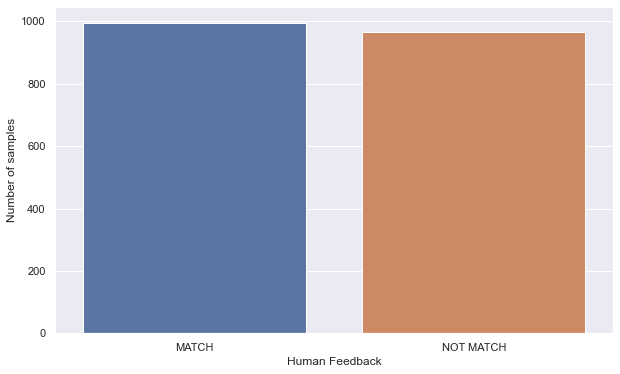

In [8]:
sb.set_theme()
plt.figure(figsize=(10, 6))
sb.barplot(data = human_fb, x = 'Human Feedback', y = 'Feedback ID')
plt.ylabel('Number of samples');

In [9]:
mask1 = df['Human Feedback'] == 'NOT MATCH'
mask2 = df['Human Feedback'] == 'MATCH'

df_neg = df[mask1].reset_index(drop = True)
df_pos = df[mask2].reset_index(drop = True)

print(df_neg.shape)
print(df_pos.shape)

(966, 17)
(996, 17)


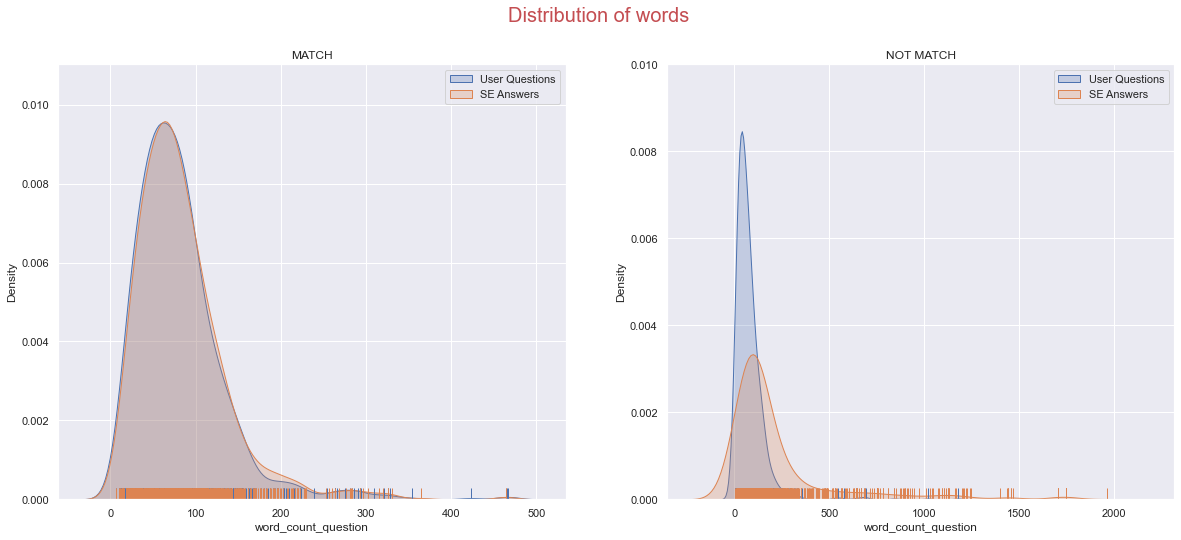

In [10]:
plt.figure(figsize=(20,8))
plt.subplot(121)
sb.distplot(df_pos['word_count_lookup'], hist = False, rug = True, kde_kws={'shade':'kde_kws'}, label='User Questions')
sb.distplot(df_pos['word_count_question'],hist = False, rug = True, kde_kws={'shade':'kde_kws'}, label='SE Answers')
plt.title('MATCH')
plt.legend()
plt.subplot(122)
sb.distplot(df_neg['word_count_lookup'], hist = False, rug = True, kde_kws={'shade':'kde_kws'}, label='User Questions')
sb.distplot(df_neg['word_count_question'],hist = False, rug = True, kde_kws={'shade':'kde_kws'}, label='SE Answers')
plt.ylim([0, 0.01])
plt.title('NOT MATCH')
plt.legend()
plt.suptitle('Distribution of words', fontsize = 20, color = 'r');

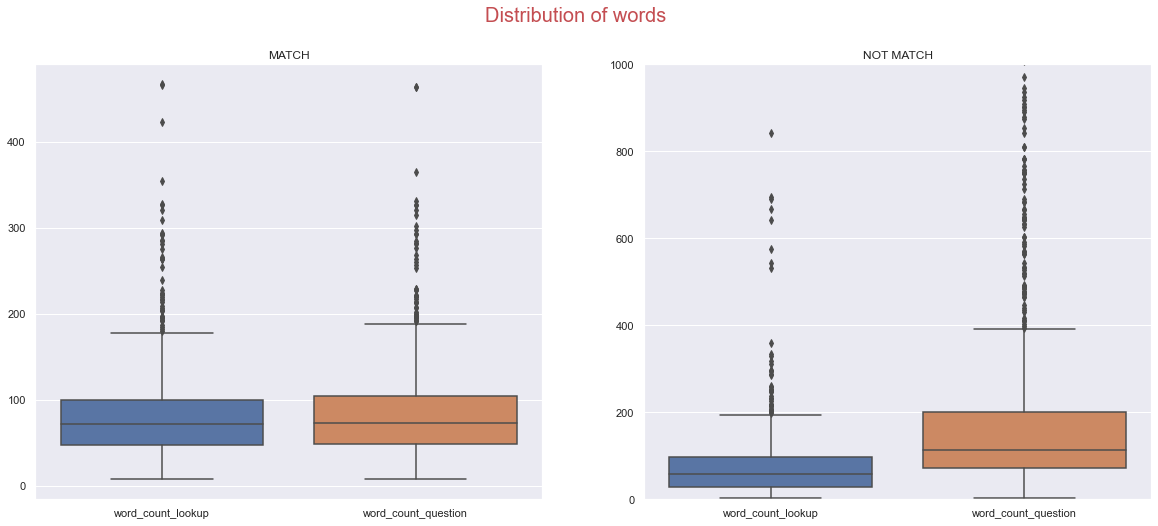

In [11]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
sb.boxplot(data = df_pos[['word_count_lookup', 'word_count_question']])
plt.title('MATCH')
plt.subplot(122)
sb.boxplot(data = df_neg[['word_count_lookup', 'word_count_question']])
plt.ylim([0, 1000])
plt.title('NOT MATCH')
plt.suptitle('Distribution of words', fontsize = 20, color = 'r');

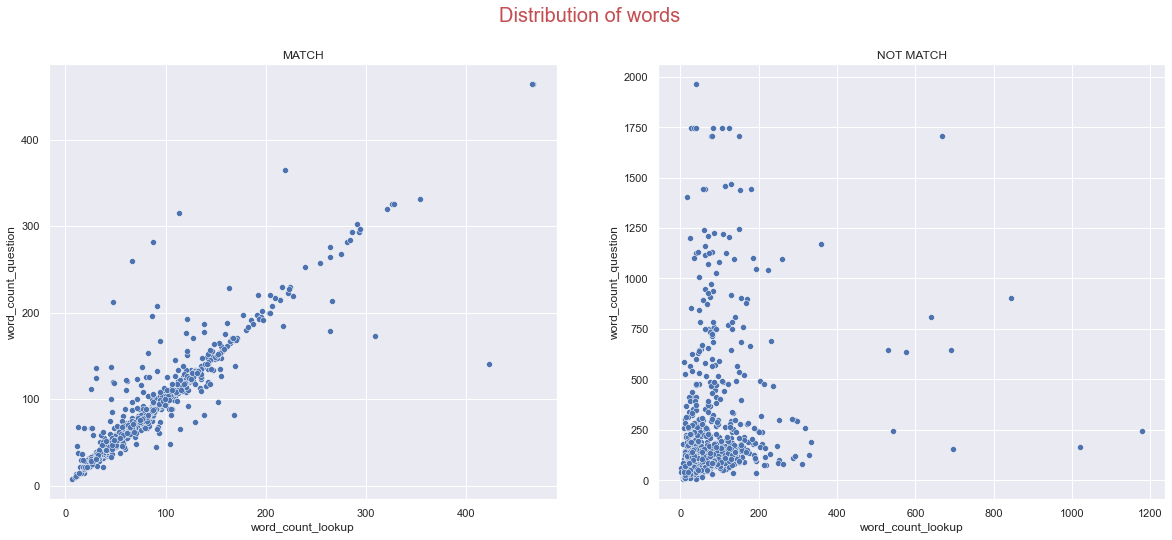

In [12]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
sb.scatterplot(data = df_pos, x = df_pos['word_count_lookup'], y = df_pos['word_count_question'])
plt.title('MATCH')
plt.subplot(122)
sb.scatterplot(data = df_neg, x = df_neg['word_count_lookup'], y = df_neg['word_count_question'])
# plt.ylim([0, 1000])
plt.title('NOT MATCH')
plt.suptitle('Distribution of words', fontsize = 20, color = 'r');

In [13]:
df_neg['diff_word'] = abs(df_neg['word_count_question'] - df_neg['word_count_lookup'])
df_pos['diff_word'] = abs(df_pos['word_count_question'] - df_pos['word_count_lookup'])

my_bins = [-np.inf, 5, 10, 15, 20, np.inf]
my_labels = ['Very low', 'Low', 'Medium', 'High', 'Very high']

df_neg['diff_bin'] = pd.cut(df_neg['diff_word'], bins=my_bins, labels=my_labels)
df_pos['diff_bin'] = pd.cut(df_pos['diff_word'], bins=my_bins, labels=my_labels)

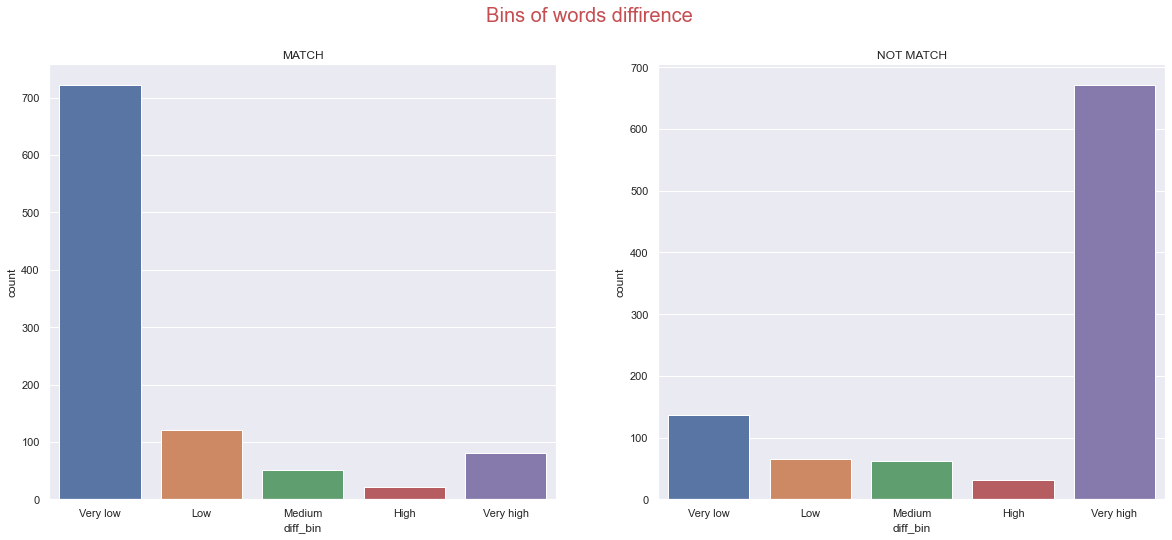

In [14]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
sb.countplot(df_pos['diff_bin'])
plt.title('MATCH')
plt.subplot(122)
sb.countplot(df_neg['diff_bin'])
plt.title('NOT MATCH')
plt.suptitle('Bins of words diffirence', fontsize = 20, color = 'r');

In [15]:
with open('vietnamese-stopwords.txt', 'r', encoding='utf-8') as file:
    vn_stop_words = file.read()
vn_stop_words = vn_stop_words.split('\n') 

# combine Vietnamese stopwords and English stopwords
stop_words = ENGLISH_STOP_WORDS.union(vn_stop_words)

In [16]:
tf_neg = TfidfVectorizer(analyzer = 'word', stop_words = stop_words, max_features = 1200)
tfidf_matrix_neg = tf_neg.fit_transform(df_neg['clean_question'])
tfidf_matrix_neg = pd.DataFrame(tfidf_matrix_neg.toarray(),
                                columns = tf_neg.get_feature_names())
tfidf_matrix_neg.head()
tfidf_matrix_neg.shape

(966, 1200)

In [17]:
tf_pos = TfidfVectorizer(analyzer = 'word', stop_words = stop_words, max_features = 1200)
tfidf_matrix_pos = tf_pos.fit_transform(df_pos['clean_question'])
tfidf_matrix_pos = pd.DataFrame(tfidf_matrix_pos.toarray(),
                                columns = tf_pos.get_feature_names())
tfidf_matrix_pos.head()
tfidf_matrix_pos.shape

(996, 1200)

In [18]:
# query1 = df_neg.iloc[0]['Lookup Text']
# query1_tf = tf.transform([clean_function(query1)])

In [18]:
sums_weight_neg = tfidf_matrix_neg.sum().sort_values(ascending = False)
sums_weight_neg.head(10)

frac      128.789906
sqrt       79.803607
y_         43.940600
3_         43.640388
_left      43.247407
_right     42.625753
a_         42.401152
ca         38.057918
cc         35.465601
sin        32.191570
dtype: float64

In [19]:
sums_weight_pos = tfidf_matrix_pos.sum().sort_values(ascending = False)
sums_weight_pos.head(10)

frac      96.929220
sqrt      63.284425
_right    41.090496
_left     40.009146
ca        38.940653
a_        38.114405
cc        36.555212
3_        31.098525
y_        30.567987
ng        28.963895
dtype: float64

# 2. Cosine search in NOT MATCH Dataset

In [20]:
def cosine_search_all(queries, tf, tfidf_matrix, data, top_result = 5, check_time = True):
    t0 = time()
    results = pd.DataFrame(columns = ['lookup_text', 'question_text', 'sim_score', 
                                      'cosine_word_count_question', 'cosine_diff_bin', 'cosine_image'])
    for q in queries:
        query = clean_function(q)
        query_tf = tf.transform([query])
        query_tf = pd.DataFrame(query_tf.toarray(),
                                columns = tf.get_feature_names())
        cosine_sim = cosine_similarity(query_tf, tfidf_matrix).flatten()
        related_index = cosine_sim.argsort()[-top_result:][::-1]
        cosine_sim = sorted(cosine_sim, reverse = True)
        similarities_score = cosine_sim[:top_result]
        result = pd.DataFrame({'lookup_text': q,
                               'question_text': data.iloc[related_index, :]['Question Text'].values,
                               'sim_score': similarities_score,
                               'cosine_word_count_question': data.iloc[related_index, :]['word_count_question'].values,
                               'cosine_diff_bin': data.iloc[related_index, :]['diff_bin'].values,
                               'cosine_image': data.iloc[related_index, :]['Question Image'].values}).head(1)
        results = pd.concat([results, result], ignore_index = True)
    if check_time:
        print('Time:', time() - t0)
    return results

In [21]:
result_neg = cosine_search_all(df_neg['Lookup Text'], tf_neg, tfidf_matrix_neg, df_neg)

Time: 15.172996997833252


In [61]:
result_neg.loc[result_neg['sim_score'] >= 0.8].shape[0] / 966

0.3581780538302277

In [22]:
df_neg['search_result'] = result_neg['question_text']
df_neg['score'] = result_neg['sim_score']
df_neg['cosine_word_count_question'] = result_neg['cosine_word_count_question']
df_neg['cosine_diff_bin'] = result_neg['cosine_diff_bin']
df_neg['cosine_image'] = result_neg['cosine_image']

In [23]:
mask3 = df_neg['Lookup Text'] != df_neg['search_result']

df_check_neg = df_neg[mask3]
df_check_neg.shape

(947, 24)

In [24]:
def cosine_neg_noPCA(query, tf, tfidf_matrix, data, top_result = 5, check_time = True):
    t0 = time()
    query = clean_function(query)
    query_tf = tf.transform([query])
    query_tf = pd.DataFrame(query_tf.toarray(),
                            columns = tf.get_feature_names())
    
    cosine_sim = cosine_similarity(query_tf, tfidf_matrix).flatten()
    
    related_question = cosine_sim.argsort()[-top_result:][::-1]
    
    cosine_sim = sorted(cosine_sim, reverse = True)
    similarities_score = cosine_sim[:top_result]
    
    result = pd.DataFrame({'question_text': data.iloc[related_question, :]['Question Text'].values,
                           'sim_score': similarities_score})
    if check_time:
        print('Time:', time() - t0)
    return result

In [25]:
def check_wrong_results(indices):
    index_ = df_check_neg.index.tolist()
    no_results = []
    top5_results = []
    for num in indices:
        df_results = cosine_neg_noPCA(df_check_neg.iloc[num]['Lookup Text'], tf_neg, tfidf_matrix_neg, df_neg, check_time = False)
        top_results = df_results['question_text'].values
        if (df_check_neg.iloc[num]['Lookup Text'] in top_results):
            top5_results.append(index_[num])
        else:
            no_results.append(index_[num])
    return top5_results, no_results

In [26]:
top5_result_neg, no_result_neg = check_wrong_results(list(range(0, len(df_check_neg.index))))

In [27]:
print(len(top5_result_neg))
print(len(no_result_neg))

0
947


In [28]:
mask4 = df_neg['Lookup Text'] == df_neg['search_result']

df_match_neg = df_neg[mask4]
df_match_neg.shape

(19, 24)

In [29]:
df_top5_neg = df_neg.iloc[top5_result_neg, :]
df_top5_neg.shape

(0, 24)

In [30]:
df_no_neg = df_neg.iloc[no_result_neg, :]
df_no_neg.shape

(947, 24)

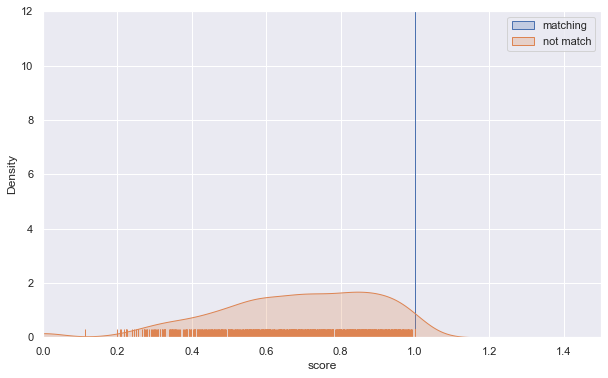

In [31]:
plt.figure(figsize=(10,6))
# plt.subplot(121)
sb.distplot(df_match_neg.score, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = 'matching')
# plt.subplot(121)
# sb.distplot(df_top5_neg.score, label = 'top5_relevance')
# plt.subplot(121)
sb.distplot(df_no_neg.score, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = "not match")
plt.xlim([0, 1.5])
plt.ylim([0, 12])
plt.legend()
# plt.title('Distribution of Consine Similarity score')
plt.show()

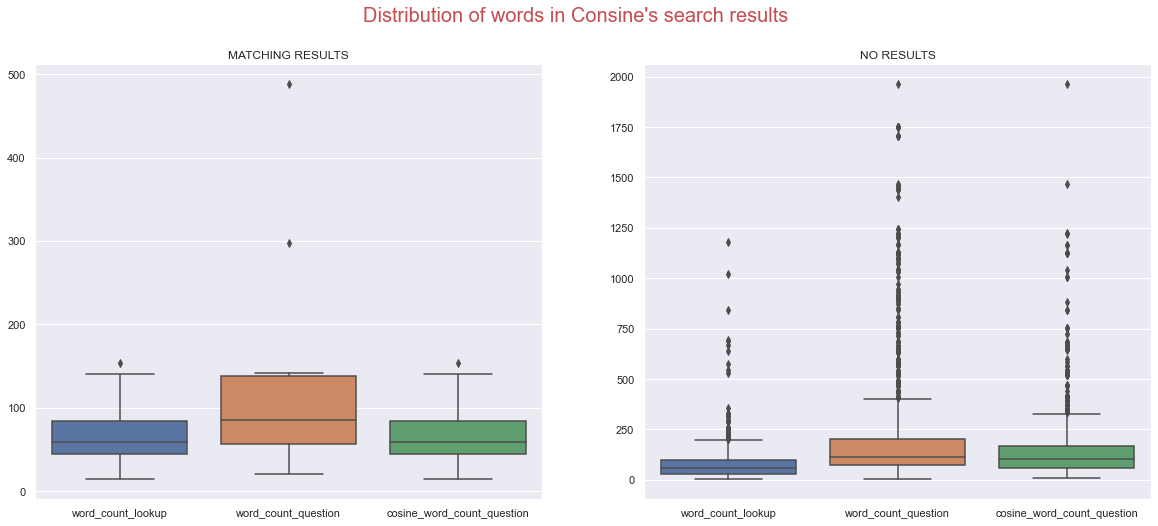

In [32]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
sb.boxplot(data = df_match_neg[['word_count_lookup', 'word_count_question', 'cosine_word_count_question']])
plt.title('MATCHING RESULTS')
plt.subplot(122)
sb.boxplot(data = df_no_neg[['word_count_lookup', 'word_count_question', 'cosine_word_count_question']])
plt.title('NO RESULTS')
plt.suptitle("Distribution of words in Consine's search results", fontsize = 20, color = 'r');

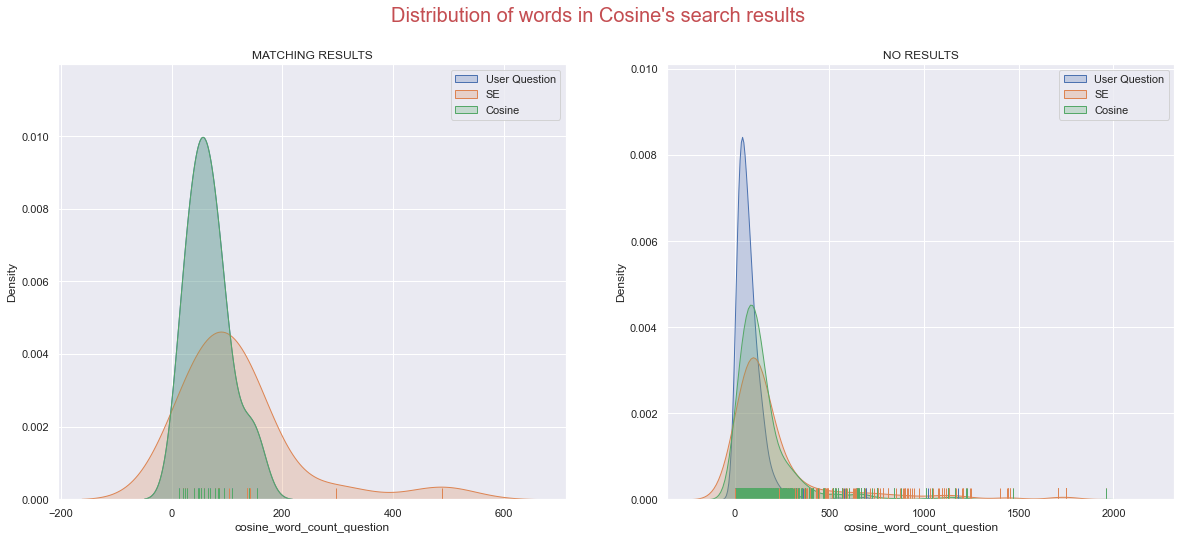

In [33]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
sb.distplot(df_match_neg.word_count_lookup, hist = False, rug = True, kde_kws={'shade':'kde_kws'}, label = "User Question")
sb.distplot(df_match_neg.word_count_question, hist = False, rug = True, kde_kws={'shade':'kde_kws'}, label = "SE")
sb.distplot(df_match_neg.cosine_word_count_question, hist = False, rug = True, kde_kws={'shade':'kde_kws'}, label = "Cosine")
plt.legend()
plt.title('MATCHING RESULTS')
plt.subplot(122)
sb.distplot(df_no_neg.word_count_lookup, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = "User Question")
sb.distplot(df_no_neg.word_count_question, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = "SE")
sb.distplot(df_no_neg.cosine_word_count_question, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = "Cosine")
plt.legend()
plt.title('NO RESULTS')
plt.suptitle("Distribution of words in Cosine's search results", fontsize = 20, color = 'r')
plt.show()

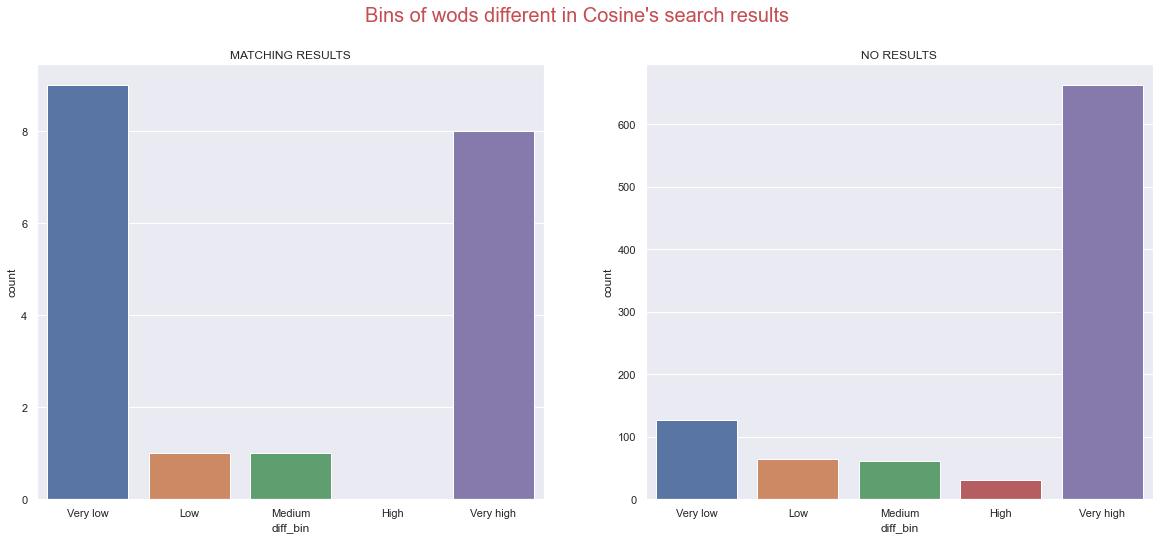

In [34]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
sb.countplot(df_match_neg['diff_bin'])
plt.title('MATCHING RESULTS')
plt.subplot(122)
sb.countplot(df_no_neg['diff_bin'])
plt.title('NO RESULTS')
plt.suptitle("Bins of wods different in Cosine's search results", fontsize = 20, color = 'r');

# 3. Cosine search in MATCH Dataset

In [35]:
result_pos = cosine_search_all(df_pos['Lookup Text'], tf_pos, tfidf_matrix_pos, df_pos)

Time: 17.01970076560974


In [36]:
df_pos['search_result'] = result_pos['question_text']
df_pos['score'] = result_pos['sim_score']
df_pos['cosine_word_count_question'] = result_pos['cosine_word_count_question']
df_pos['cosine_diff_bin'] = result_pos['cosine_diff_bin']
df_pos['cosine_image'] = result_pos['cosine_image']

In [37]:
mask5 = df_pos['Question Text'] != df_pos['search_result']

df_check_pos = df_pos[mask5]
df_check_pos.shape

(62, 24)

In [70]:
def cosine_pos_noPCA(query, tf, tfidf_matrix, data, top_result = 5, check_time = True):
    t0 = time()
    query = clean_function(query)
    query_tf = tf.transform([query])
    query_tf = pd.DataFrame(query_tf.toarray(),
                            columns = tf.get_feature_names())
    
    cosine_sim = cosine_similarity(query_tf, tfidf_matrix).flatten()
    
    related_question = cosine_sim.argsort()[-top_result:][::-1]
    
    cosine_sim = sorted(cosine_sim, reverse = True)
    similarities_score = cosine_sim[:top_result]
    
    result = pd.DataFrame({'question_text_plain': data.iloc[related_question, :]['question_plain'].values,
                           'sim_score': similarities_score})
    if check_time:
        print('Time:', time() - t0)
    return result

In [39]:
def check_wrong_results(indices):
    index_ = df_check_pos.index.tolist()
    no_results = []
    top5_results = []
    for num in indices:
        df_results = cosine_pos_noPCA(df_check_pos.iloc[num]['Lookup Text'], tf_pos, tfidf_matrix_pos, df_pos, check_time = False)
        top_results = df_results['question_text'].values
        if (df_check_pos.iloc[num]['Lookup Text'] in top_results) or (df_check_pos.iloc[num]['Question Text'] in top_results):
            top5_results.append(index_[num])
        else:
            no_results.append(index_[num])
    return top5_results, no_results

top5_result_pos, no_result_pos = check_wrong_results(list(range(0, len(df_check_pos.index))))

In [40]:
print(len(top5_result_pos))
print(len(no_result_pos))

37
25


In [41]:
mask6 = df_pos['Question Text'] == df_pos['search_result']

df_match_pos = df_pos[mask6]
df_match_pos.shape

(934, 24)

In [42]:
df_top5_pos = df_pos.iloc[top5_result_pos, :]
df_top5_pos.shape

(37, 24)

In [43]:
df_no_pos = df_pos.iloc[no_result_pos, :]
df_no_pos.shape

(25, 24)

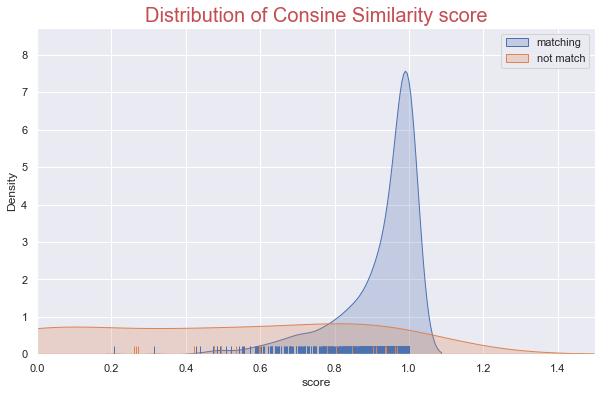

In [44]:
plt.figure(figsize=(10,6))
sb.distplot(df_match_pos.score, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = 'matching')
sb.distplot(df_no_pos.score, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = "not match")
plt.xlim([0, 1.5])
# plt.ylim([0, 12])
plt.legend()
plt.title('Distribution of Consine Similarity score', fontsize = 20, color = 'r')
plt.show()

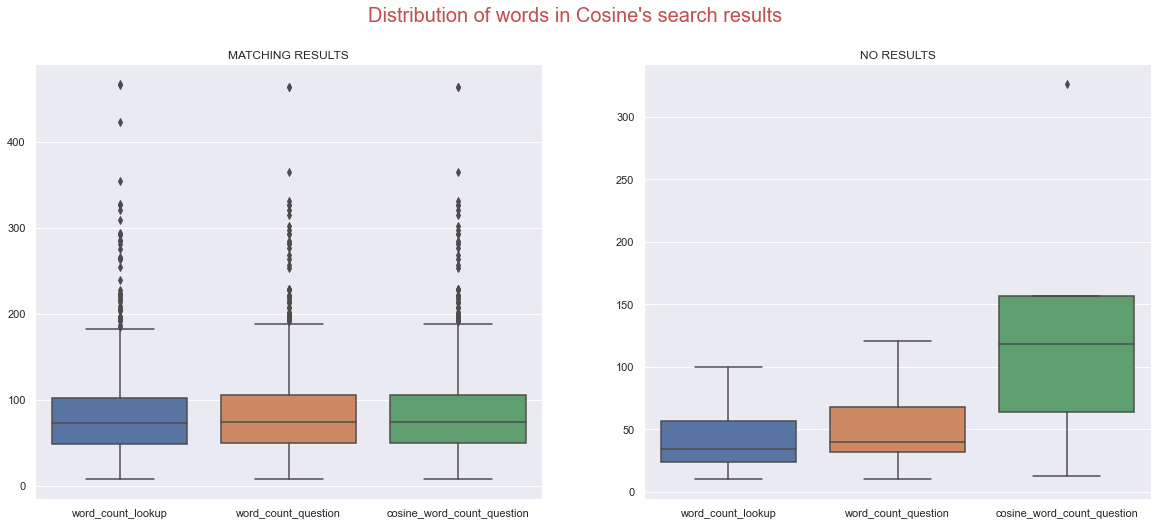

In [45]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
sb.boxplot(data = df_match_pos[['word_count_lookup', 'word_count_question', 'cosine_word_count_question']])
plt.title('MATCHING RESULTS')
plt.subplot(122)
sb.boxplot(data = df_no_pos[['word_count_lookup', 'word_count_question', 'cosine_word_count_question']])
plt.title('NO RESULTS')
plt.suptitle("Distribution of words in Cosine's search results", fontsize = 20, color = 'r');

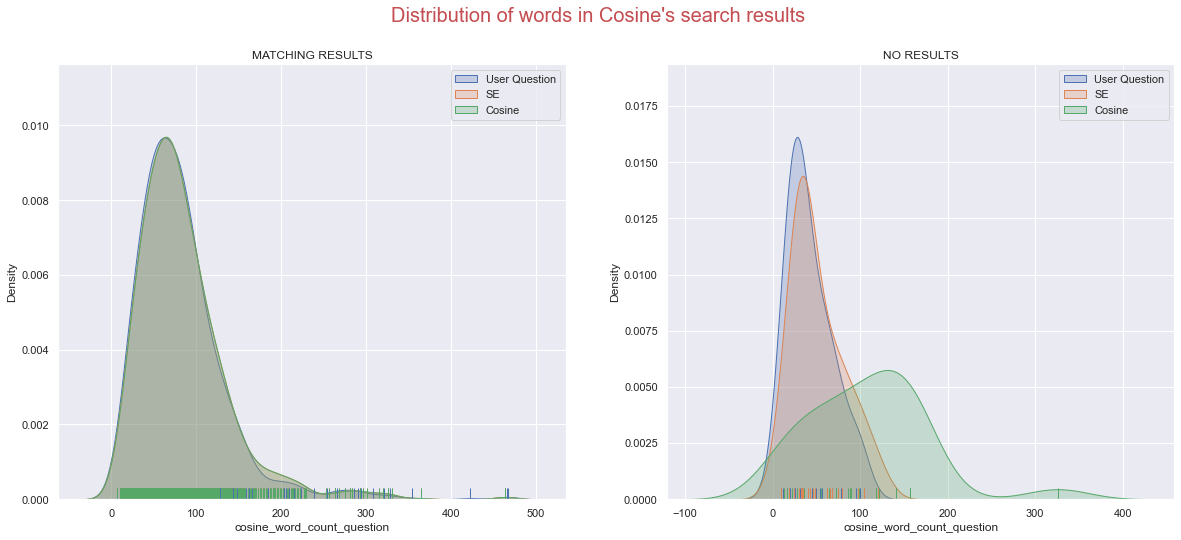

In [46]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
sb.distplot(df_match_pos.word_count_lookup, hist = False, rug = True, kde_kws={'shade':'kde_kws'}, label = "User Question")
sb.distplot(df_match_pos.word_count_question, hist = False, rug = True, kde_kws={'shade':'kde_kws'}, label = "SE")
sb.distplot(df_match_pos.cosine_word_count_question, hist = False, rug = True, kde_kws={'shade':'kde_kws'}, label = "Cosine")
plt.legend()
plt.title('MATCHING RESULTS')
plt.subplot(122)
sb.distplot(df_no_pos.word_count_lookup, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = "User Question")
sb.distplot(df_no_pos.word_count_question, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = "SE")
sb.distplot(df_no_pos.cosine_word_count_question, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = "Cosine")
plt.legend()
plt.title('NO RESULTS')
plt.suptitle("Distribution of words in Cosine's search results", fontsize = 20, color = 'r')
plt.show()

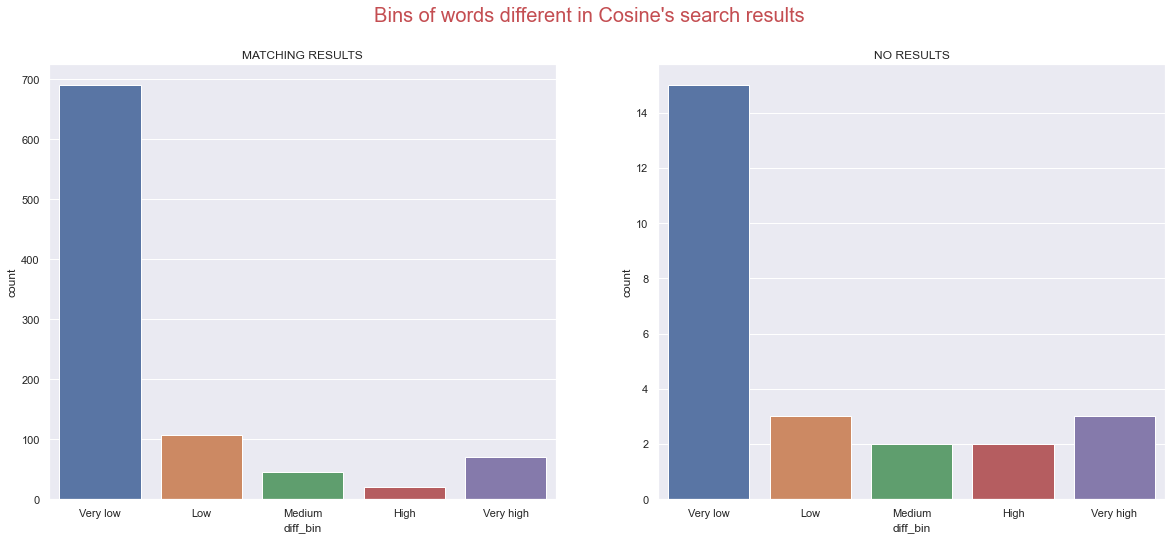

In [47]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
sb.countplot(df_match_pos['diff_bin'])
plt.title('MATCHING RESULTS')
plt.subplot(122)
sb.countplot(df_no_pos['diff_bin'])
plt.title('NO RESULTS')
plt.suptitle("Bins of words different in Cosine's search results", fontsize = 20, color = 'r');

In [74]:
def new_cosine_search_all(queries, tf, tfidf_matrix, data, top_result = 5, check_time = True):
    t0 = time()
    results = pd.DataFrame(columns = ['lookup_text', 'question_text_plain', 'sim_score', 
                                      'cosine_word_count_question', 'cosine_diff_bin', 'cosine_image'])
    for q in queries:
        query = clean_function(q)
        query_tf = tf.transform([query])
        query_tf = pd.DataFrame(query_tf.toarray(),
                                columns = tf.get_feature_names())
        cosine_sim = cosine_similarity(query_tf, tfidf_matrix).flatten()
        related_index = cosine_sim.argsort()[-top_result:][::-1]
        cosine_sim = sorted(cosine_sim, reverse = True)
        similarities_score = cosine_sim[:top_result]
        result = pd.DataFrame({'lookup_text': q,
                               'question_text_plain': data.iloc[related_index, :]['question_plain'].values,
                               'sim_score': similarities_score,
                               'cosine_word_count_question': data.iloc[related_index, :]['word_count_question'].values,
                               'cosine_diff_bin': data.iloc[related_index, :]['diff_bin'].values,
                               'cosine_image': data.iloc[related_index, :]['Question Image'].values}).head(1)
        results = pd.concat([results, result], ignore_index = True)
    if check_time:
        print('Time:', time() - t0)
    return results

In [63]:
from pylatexenc.latex2text import LatexNodes2Text

In [66]:
df_pos['lookup_plain'] = df_pos['Lookup Text'].map(lambda x: LatexNodes2Text().latex_to_text(x))
df_pos['question_plain'] = df_pos['Question Text'].map(lambda x: LatexNodes2Text().latex_to_text(x))

df_pos['clean_lookup_plain'] = df_pos['lookup_plain'].map(lambda x: clean_function(x))
df_pos['clean_question_plain'] = df_pos['question_plain'].map(lambda x: clean_function(x))

In [79]:
tf_question = TfidfVectorizer(analyzer = 'word', stop_words = stop_words, max_features = 1200)
tfidf_question = tf_question.fit_transform(df_pos['clean_question_plain'])
tfidf_question = pd.DataFrame(tfidf_question.toarray(),
                            columns = tf_question.get_feature_names())
tfidf_question.shape

(996, 1200)

In [80]:
result_new = new_cosine_search_all(df_pos['lookup_plain'], tf_question, tfidf_question, df_pos)

Time: 15.059422254562378


In [81]:
result_new

lookup_text  \
0    Đề số 1 .\n1. Tính\nb) √(25)\nc) √(-36)\na) √(...   
1    1. Tính: √(25/4)+(√(1/2))^2:(-√(9)/4) ·√(16/81...   
2    25. Tìm giá trị x (làm tròn đến chữ số thập ph...   
3    Câu 6. Cho x-6/1998+x-4/2000=x-2000/4+x-1998/6...   
4    Câu 7. Các giá trị của x thỏa mã (2/3 x-4/9)(1...   
..                                                 ...   
991  3.36. Cho biết tích của hai số tự nhiên n và m...   
992  Câu 10: Trong hệ trục Oxy, cho u⃗=(-2 ; 3) và ...   
993  6. Hai đoạn ống nước có chiều dài lần lượt là ...   
994  bao nhiêu phần kế hoạch?\n8. Vào tháng 6, giá ...   
995  Uai 2. Cho tam giác A B C. Goi M, N, P lin lươ...   

                                   question_text_plain sim_score  \
0    b) √(25)\nc) √(-36)\na) √(64)\n0=2 s/∂ s e) √(...  0.975269   
1    Đề số 3 .\n1. Tính: √(25/4)+(√(1/2))^2:(-√(9)/...  0.929447   
2    b) Canh BC.\n5. Tìm giá trị x (làm tròn đển ch...   0.76727   
3    Câu 6. Cho x-6/1998+x-4/2000=x-2000/4+x-1998/6...  0.945268   
4    Câu 7. Các giá trị của x thỏa mãn (2/3 x-4/9)(...  0.979277   
..                                                 ...       ...   
991  3.36. Cho biết tích của hai số tự nhiên n và m...  0.977323   
992  Câu 18: Trong mặt phẳng tọa độ O x y, cho u⃗=(...  0.708657   
993  6. Hai đoạn ống nước có chiều dài lần lượt là ...  0.971804   
994  8. Vào tháng 6 , giá niêm yết một chiếc ti vi ...  0.991008   
995  Ví dụ 3: Cho tam giác A B C. Gọi M , N, P lân ...  0.395831   

    cosine_word_count_question cosine_diff_bin  \
0                          131        Very low   
1                           80             Low   
2                           45             Low   
3                           72        Very low   
4                          153        Very low   
..                         ...             ...   
991                         53        Very low   
992                        100        Very low   
993                         61        Very low   
994                         93        Very low   
995                        157          Medium   

                                          cosine_image  
0    https://s3.icankid.io/uploads/question/5a47b89...  
1    https://s3.icankid.io/uploads/question/2d3358a...  
2    https://s3.icankid.io/uploads/question/3c3ec9e...  
3    https://s3.icankid.io/uploads/question/44a094e...  
4    https://s3.icankid.io/uploads/question/eb404dc...  
..                                                 ...  
991  https://s3.stag.icankids.com.vn/uploads/questi...  
992  https://s3.icankid.io/uploads/question/d44ded4...  
993  https://s3.icankid.io/uploads/question/2740c6d...  
994  https://s3.icankid.io/uploads/question/9363c3c...  
995  https://s3.icankid.io/uploads/question/0eb8801...  

[996 rows x 6 columns]

In [82]:
df_pos['new_result'] = result_new['question_text_plain']
df_pos['new_score'] = result_new['sim_score']
df_pos['new_cosine_word_count_question'] = result_new['cosine_word_count_question']
df_pos['new_cosine_diff_bin'] = result_new['cosine_diff_bin']
df_pos['new_cosine_image'] = result_new['cosine_image']

In [83]:
mask6 = df_pos['question_plain'] == df_pos['new_result']

df_match_pos = df_pos[mask6]
df_match_pos.shape

(882, 33)

In [86]:
df_pos[['lookup_plain', 'question_plain', 'new_result']]

lookup_plain  \
0    Đề số 1 .\n1. Tính\nb) √(25)\nc) √(-36)\na) √(...   
1    1. Tính: √(25/4)+(√(1/2))^2:(-√(9)/4) ·√(16/81...   
2    25. Tìm giá trị x (làm tròn đến chữ số thập ph...   
3    Câu 6. Cho x-6/1998+x-4/2000=x-2000/4+x-1998/6...   
4    Câu 7. Các giá trị của x thỏa mã (2/3 x-4/9)(1...   
..                                                 ...   
991  3.36. Cho biết tích của hai số tự nhiên n và m...   
992  Câu 10: Trong hệ trục Oxy, cho u⃗=(-2 ; 3) và ...   
993  6. Hai đoạn ống nước có chiều dài lần lượt là ...   
994  bao nhiêu phần kế hoạch?\n8. Vào tháng 6, giá ...   
995  Uai 2. Cho tam giác A B C. Goi M, N, P lin lươ...   

                                        question_plain  \
0    b) √(25)\nc) √(-36)\na) √(64)\n0=2 s/∂ s e) √(...   
1    Đề số 3 .\n1. Tính: √(25/4)+(√(1/2))^2:(-√(9)/...   
2    b) Canh BC.\n5. Tìm giá trị x (làm tròn đển ch...   
3    Câu 6. Cho x-6/1998+x-4/2000=x-2000/4+x-1998/6...   
4    Câu 7. Các giá trị của x thỏa mãn (2/3 x-4/9)(...   
..                                                 ...   
991  3.36. Cho biết tích của hai số tự nhiên n và m...   
992  Câu 18: Trong mặt phẳng tọa độ O x y, cho u⃗=(...   
993  6. Hai đoạn ống nước có chiều dài lần lượt là ...   
994  8. Vào tháng 6 , giá niêm yết một chiếc ti vi ...   
995  Ví dụ 3: Cho tam giác A B C. Gọi M , N, P lân ...   

                                            new_result  
0    b) √(25)\nc) √(-36)\na) √(64)\n0=2 s/∂ s e) √(...  
1    Đề số 3 .\n1. Tính: √(25/4)+(√(1/2))^2:(-√(9)/...  
2    b) Canh BC.\n5. Tìm giá trị x (làm tròn đển ch...  
3    Câu 6. Cho x-6/1998+x-4/2000=x-2000/4+x-1998/6...  
4    Câu 7. Các giá trị của x thỏa mãn (2/3 x-4/9)(...  
..                                                 ...  
991  3.36. Cho biết tích của hai số tự nhiên n và m...  
992  Câu 18: Trong mặt phẳng tọa độ O x y, cho u⃗=(...  
993  6. Hai đoạn ống nước có chiều dài lần lượt là ...  
994  8. Vào tháng 6 , giá niêm yết một chiếc ti vi ...  
995  Ví dụ 3: Cho tam giác A B C. Gọi M , N, P lân ...  

[996 rows x 3 columns]

# 4. Comparing

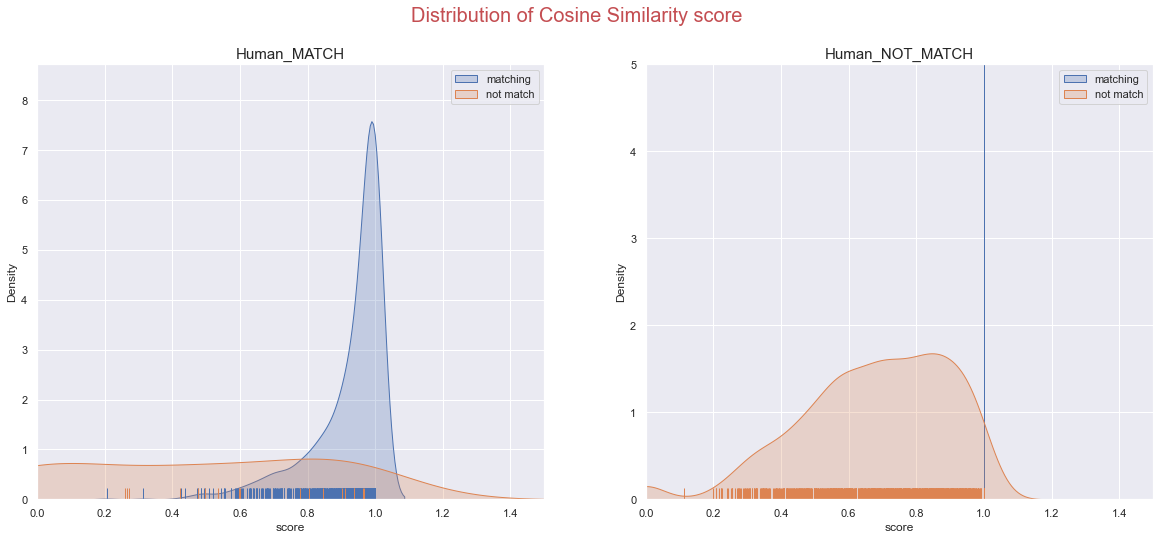

In [48]:
plt.figure(figsize=(20,8))
plt.subplot(121)
sb.distplot(df_match_pos.score, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = 'matching')
# sb.distplot(df_top5_neg.jc_score, label = 'top5_relevance')
sb.distplot(df_no_pos.score, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = "not match")
plt.xlim([0, 1.5])
# plt.ylim([0, 12])
plt.legend()
plt.title('Human_MATCH', fontsize = 15)
plt.subplot(122)
sb.distplot(df_match_neg.score, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = 'matching')
# sb.distplot(df_top5_neg.jc_score, label = 'top5_relevance')
sb.distplot(df_no_neg.score, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = "not match")
plt.xlim([0, 1.5])
plt.ylim([0, 5])
plt.legend()
plt.title('Human_NOT_MATCH', fontsize = 15)
plt.suptitle('Distribution of Cosine Similarity score', fontsize = 20, color = 'r')
plt.show()

In [49]:
df_final = pd.DataFrame({'Group': ['Human_MATCH', 'Human_NOT_MATCH'],
                         'Matching': [df_match_pos.shape[0], df_match_neg.shape[0]],
                         'In top5': [df_top5_pos.shape[0], df_top5_neg.shape[0]],
                         'No result': [df_no_pos.shape[0], df_no_neg.shape[0]]})
df_final

Group  Matching  In top5  No result
0      Human_MATCH       934       37         25
1  Human_NOT_MATCH        19        0        947

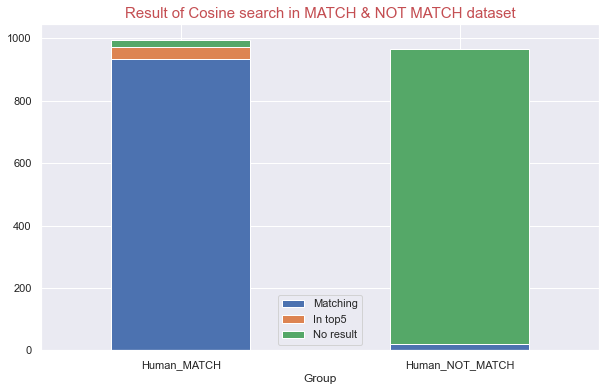

In [50]:
plt.rcParams["figure.figsize"] = [10, 6]
df_final.plot.bar(x = 'Group', stacked = True, rot = 0)
plt.legend()
plt.title('Result of Cosine search in MATCH & NOT MATCH dataset', fontsize = 15, color = 'r');

In [51]:
df_sum1 = pd.DataFrame({'Algorithms': ['Cosine', 'Gensim', 'Jaccard'],
                       'Matching': [934, 933, 957],
                       'In top5': [37, 49, 37],
                       'No results': [25, 14, 2]})
df_sum1

Algorithms  Matching  In top5  No results
0     Cosine       934       37          25
1     Gensim       933       49          14
2    Jaccard       957       37           2

In [52]:
df_sum2 = pd.DataFrame({'Algorithms': ['Cosine', 'Gensim', 'Jaccard'],
                       'Matching': [19, 19, 19],
                       'In top5': [0, 0, 0],
                       'No results': [947, 947, 947]})
df_sum2

Algorithms  Matching  In top5  No results
0     Cosine        19        0         947
1     Gensim        19        0         947
2    Jaccard        19        0         947

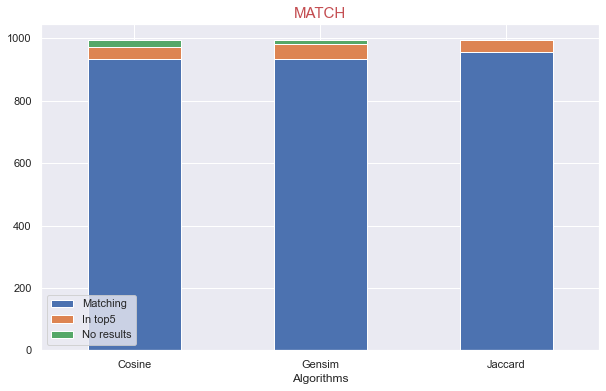

In [53]:
plt.rcParams["figure.figsize"] = [10, 6]
df_sum1.plot.bar(x = 'Algorithms', stacked = True, rot = 0)
plt.legend()
plt.title('MATCH', fontsize = 15, color = 'r');

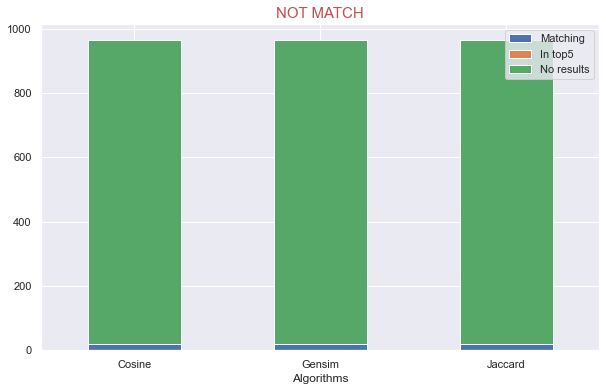

In [54]:
plt.rcParams["figure.figsize"] = [10, 6]
df_sum2.plot.bar(x = 'Algorithms', stacked = True, rot = 0)
plt.legend()
plt.title('NOT MATCH', fontsize = 15, color = 'r');

In [55]:
df_no_pos = df_no_pos.sort_values(by = 'score', ascending = False)

PAIRS: 1 - Cosine score: 0.9671570485799974
-- Number of words: 28


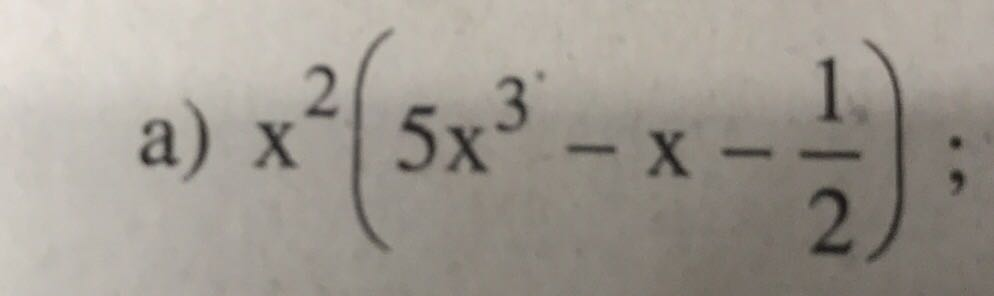

-- Number of words: 32


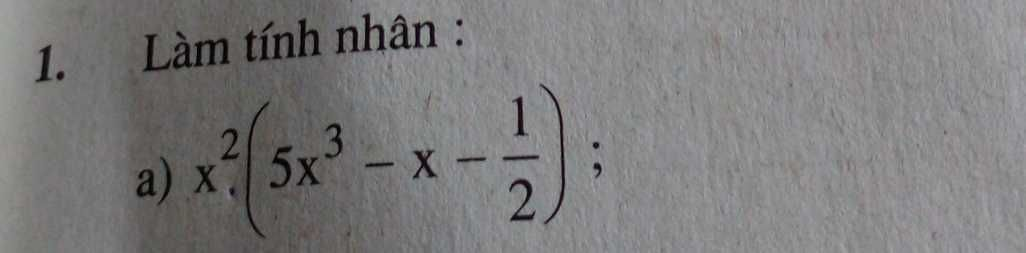

-- Number of words: 141


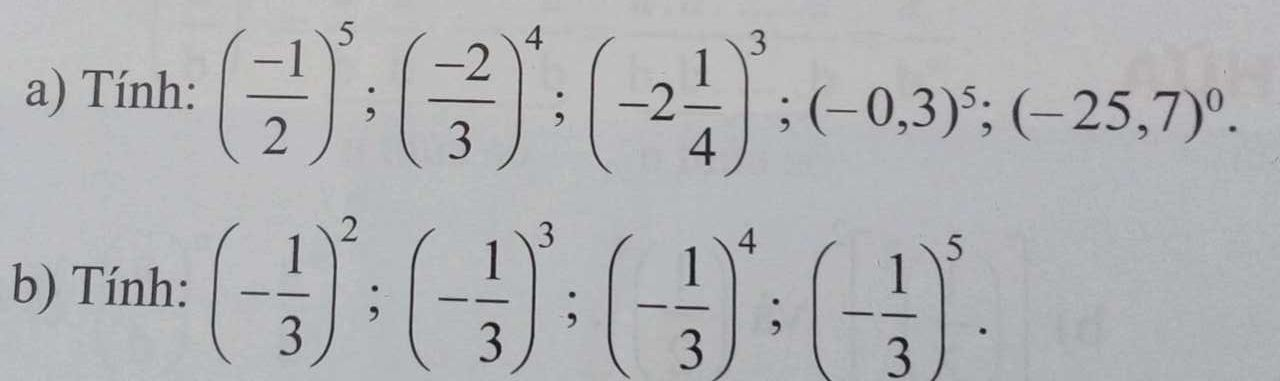

************
PAIRS: 2 - Cosine score: 0.9635933672611194
-- Number of words: 54


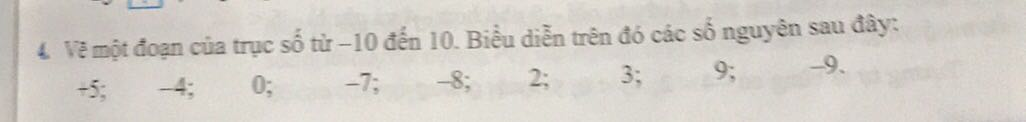

-- Number of words: 68


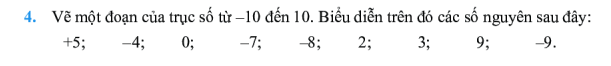

-- Number of words: 55


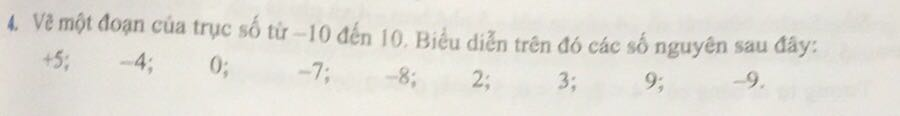

************
PAIRS: 3 - Cosine score: 0.9374140202632864
-- Number of words: 32


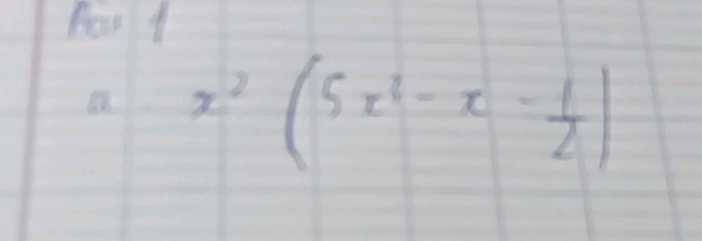

-- Number of words: 32


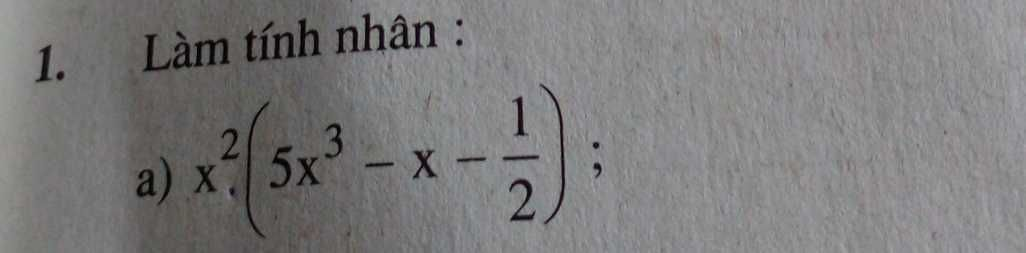

-- Number of words: 141


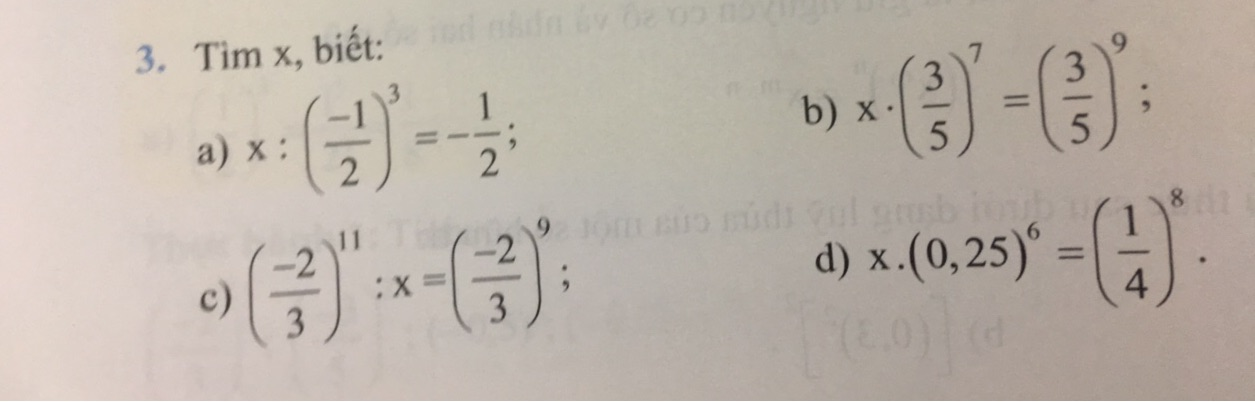

************
PAIRS: 4 - Cosine score: 0.9365591301151677
-- Number of words: 31


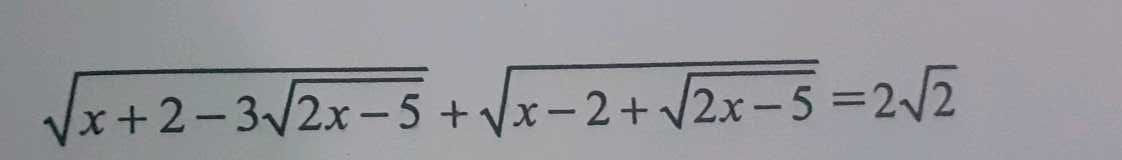

-- Number of words: 33


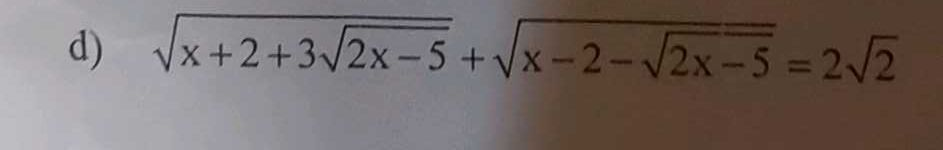

-- Number of words: 72


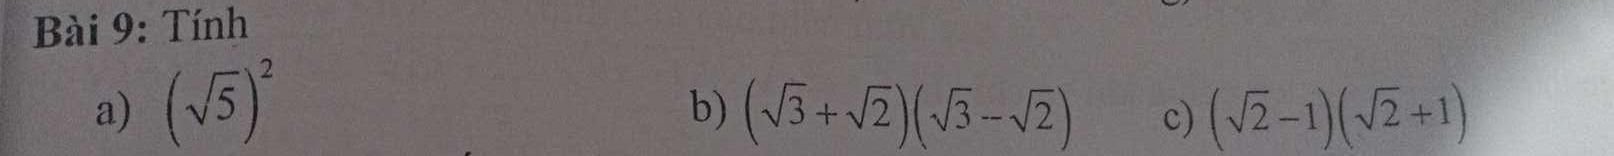

************
PAIRS: 5 - Cosine score: 0.9102073821126903
-- Number of words: 50


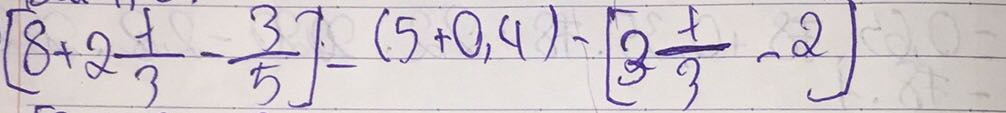

-- Number of words: 49


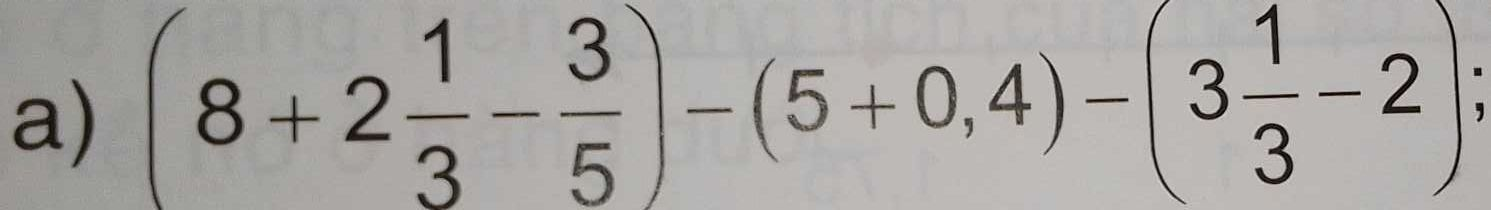

-- Number of words: 326


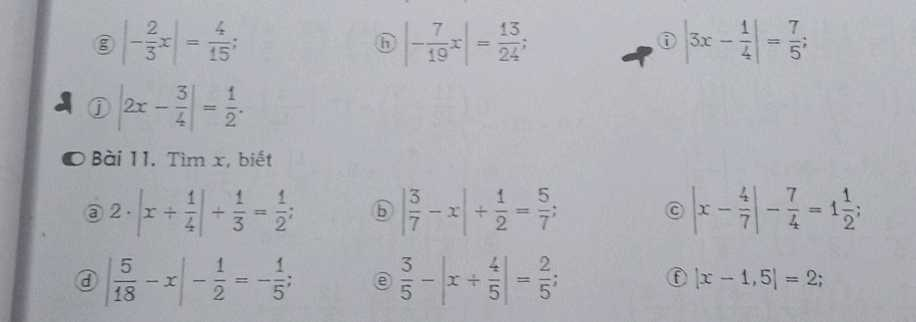

************
PAIRS: 6 - Cosine score: 0.903190085330511
-- Number of words: 57


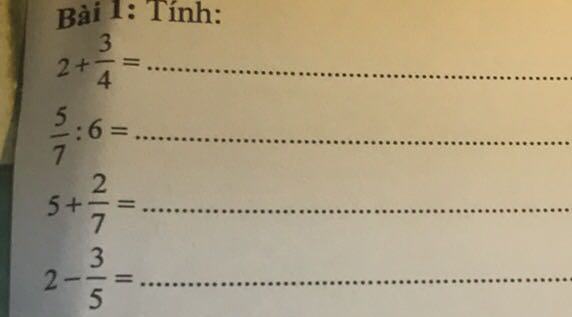

-- Number of words: 75


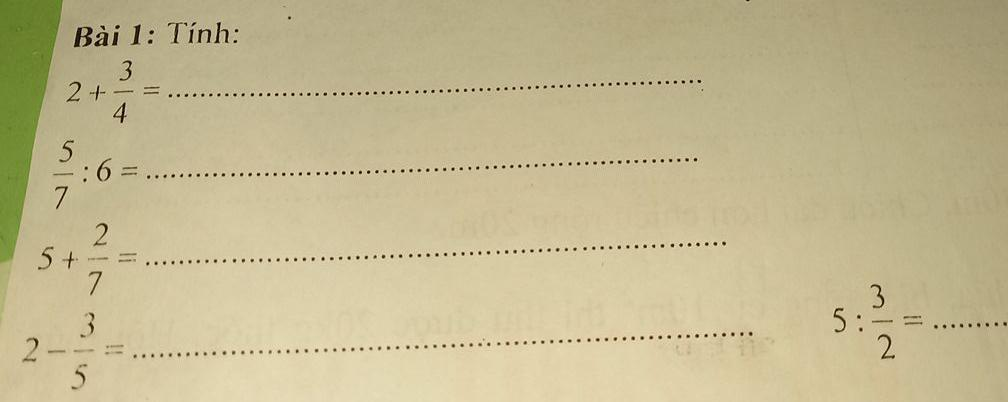

-- Number of words: 22


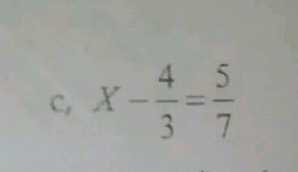

************
PAIRS: 7 - Cosine score: 0.8455283102566036
-- Number of words: 36


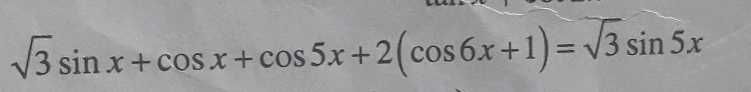

-- Number of words: 43


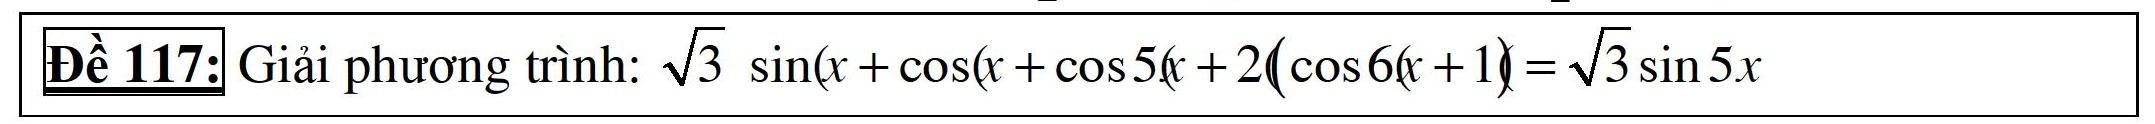

-- Number of words: 28


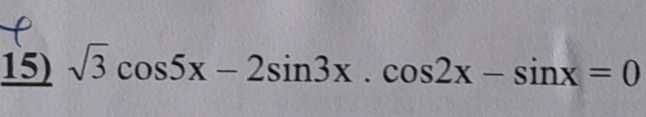

************
PAIRS: 8 - Cosine score: 0.8050569047401072
-- Number of words: 16


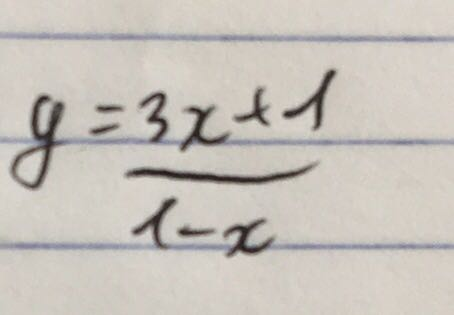

-- Number of words: 30


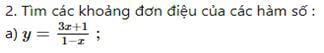

-- Number of words: 89


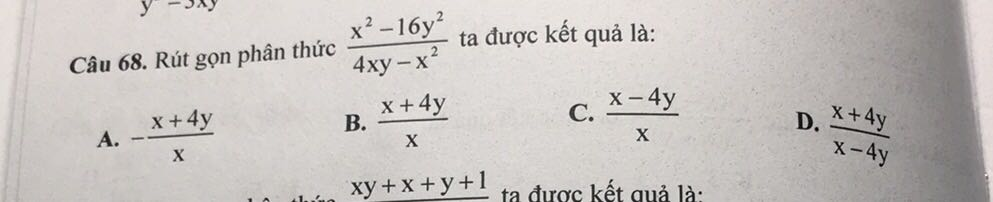

************
PAIRS: 9 - Cosine score: 0.7786831800522402
-- Number of words: 95


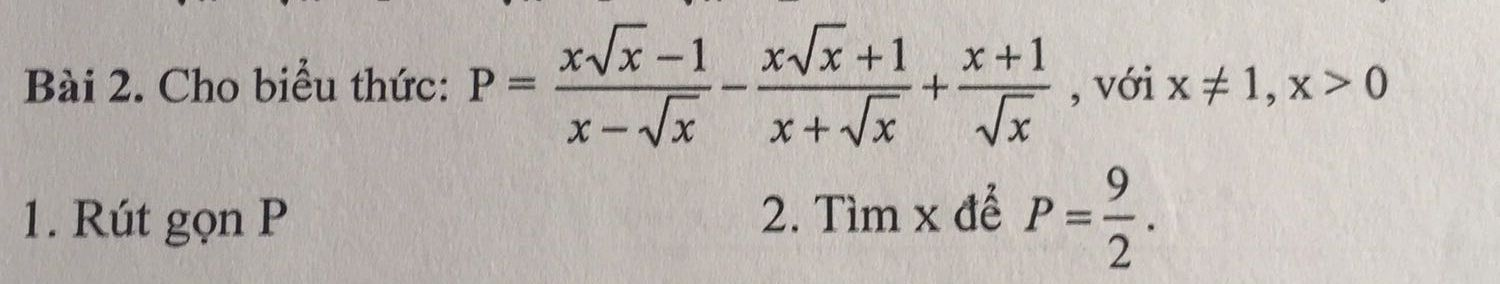

-- Number of words: 98


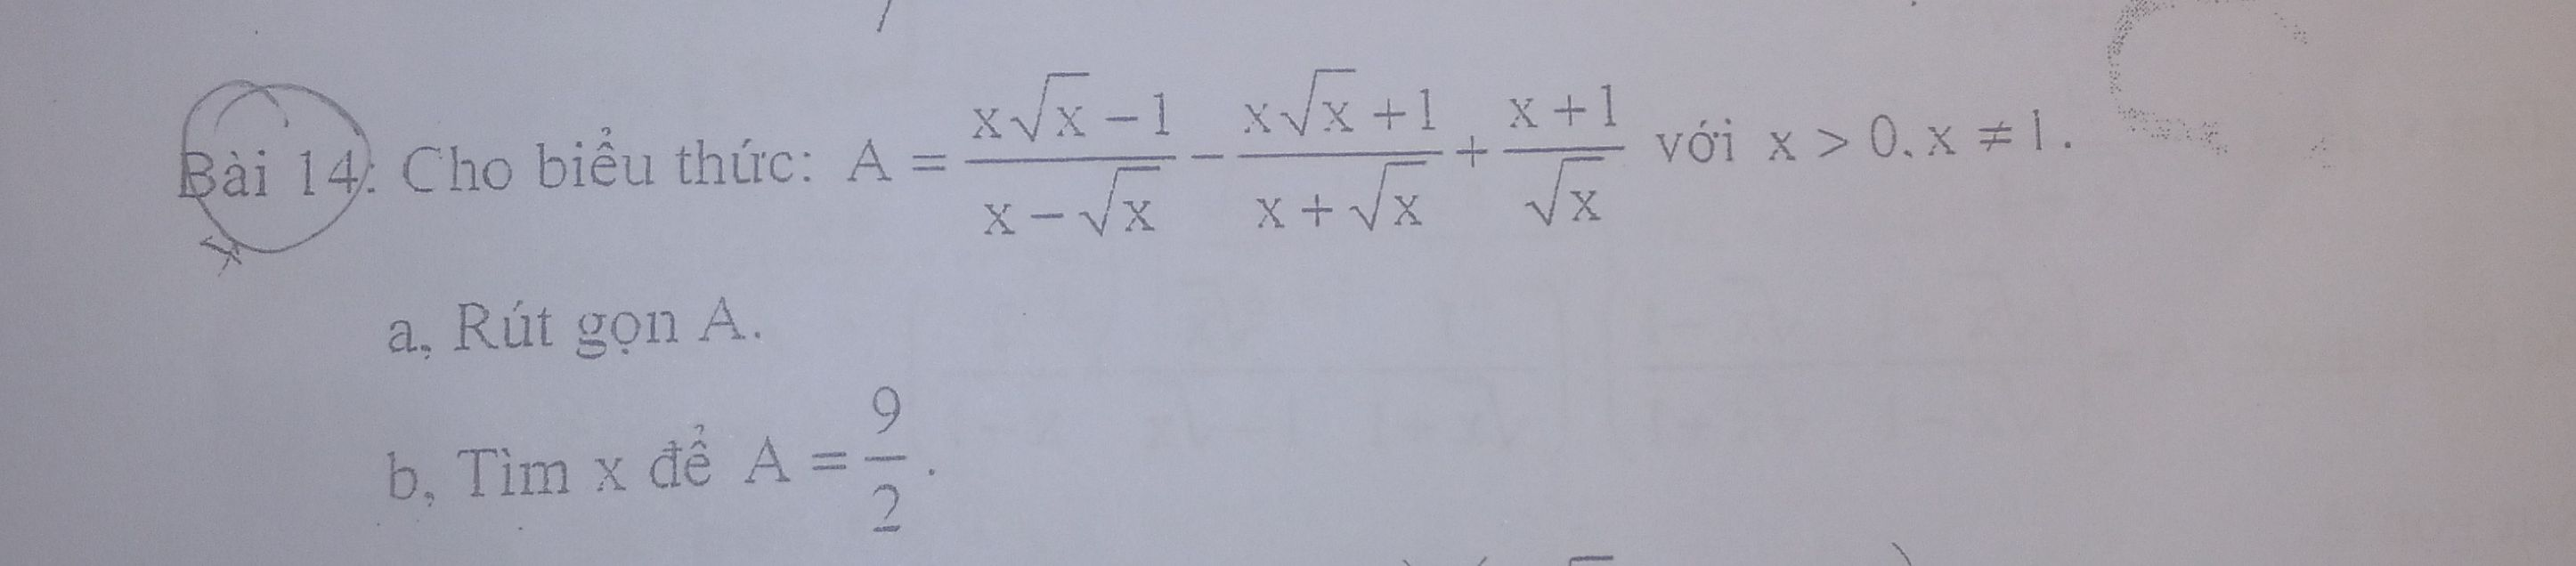

-- Number of words: 36


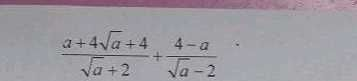

************
PAIRS: 10 - Cosine score: 0.6006343975395881
-- Number of words: 72


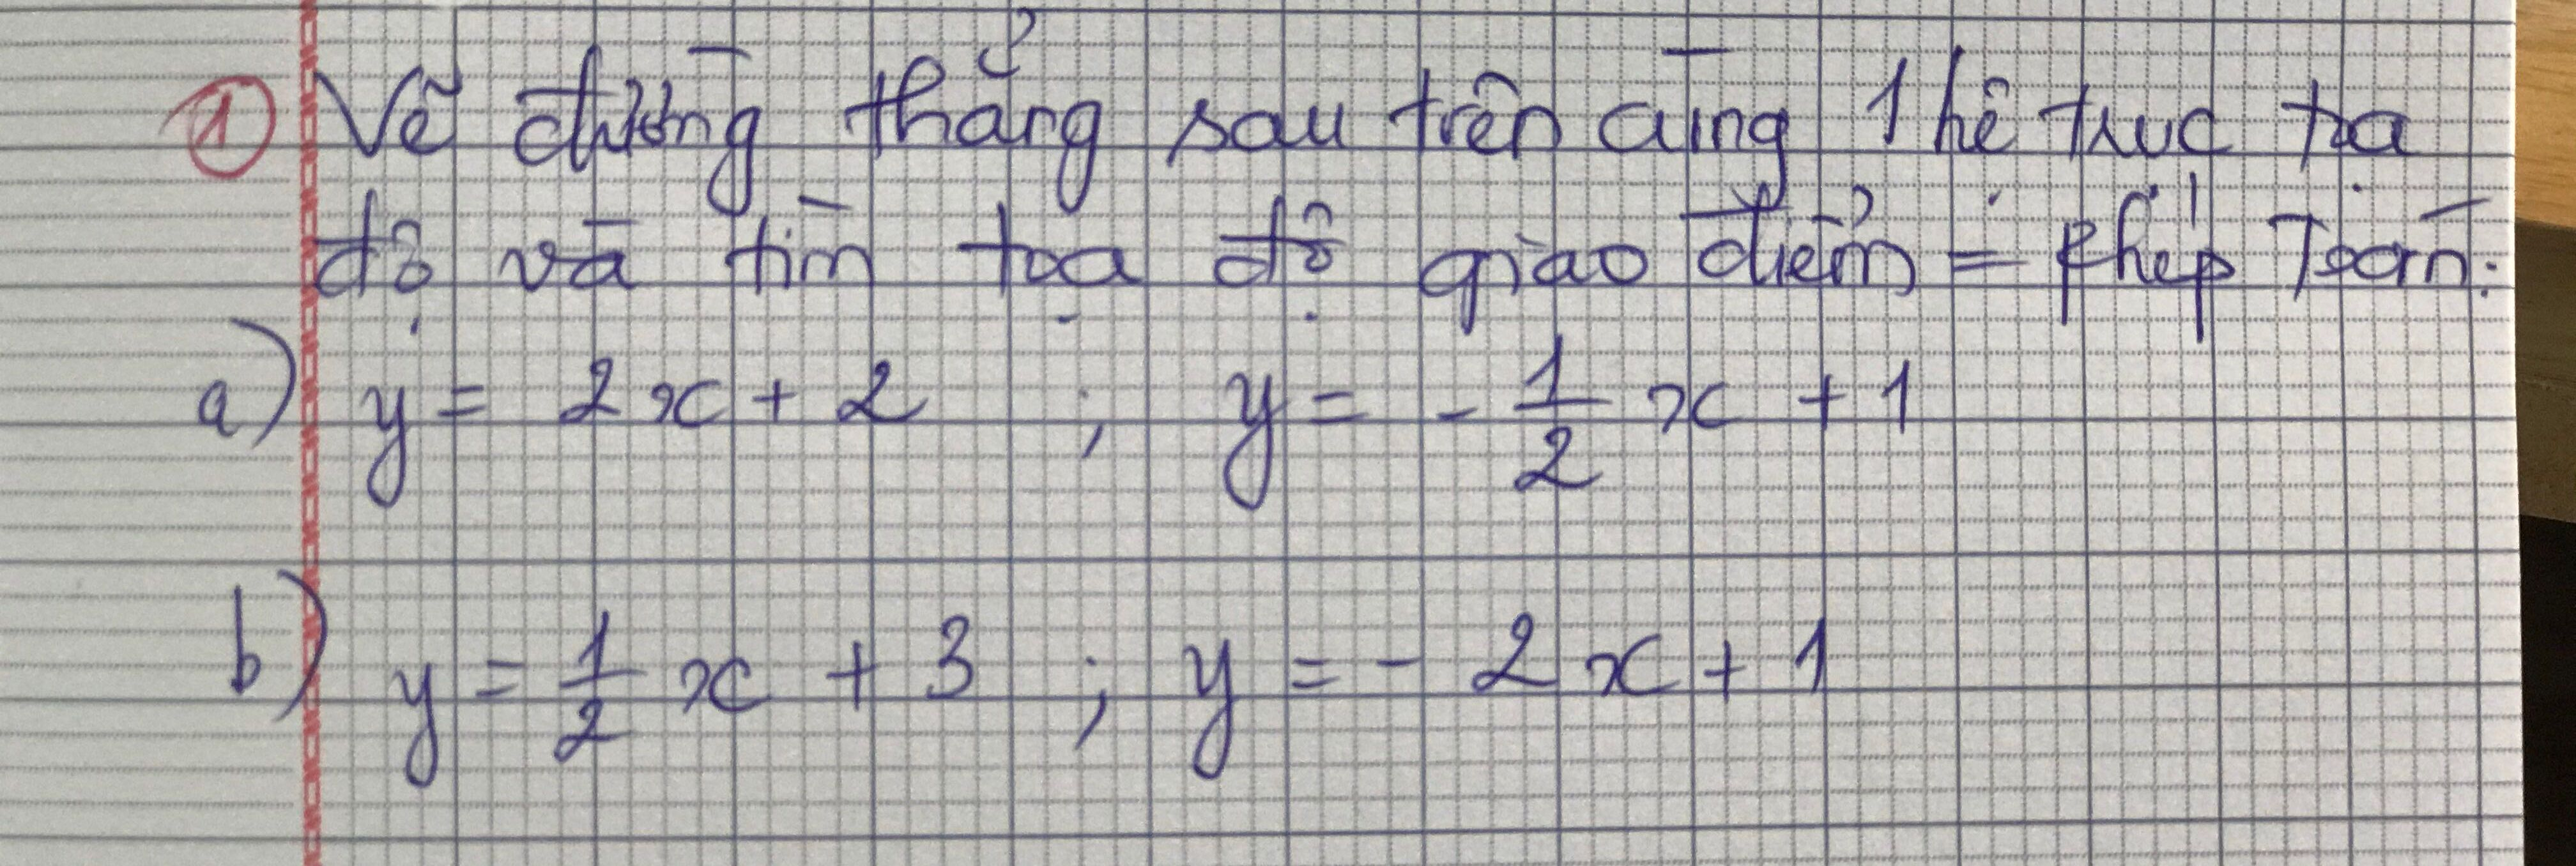

-- Number of words: 90


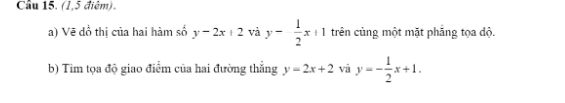

-- Number of words: 118


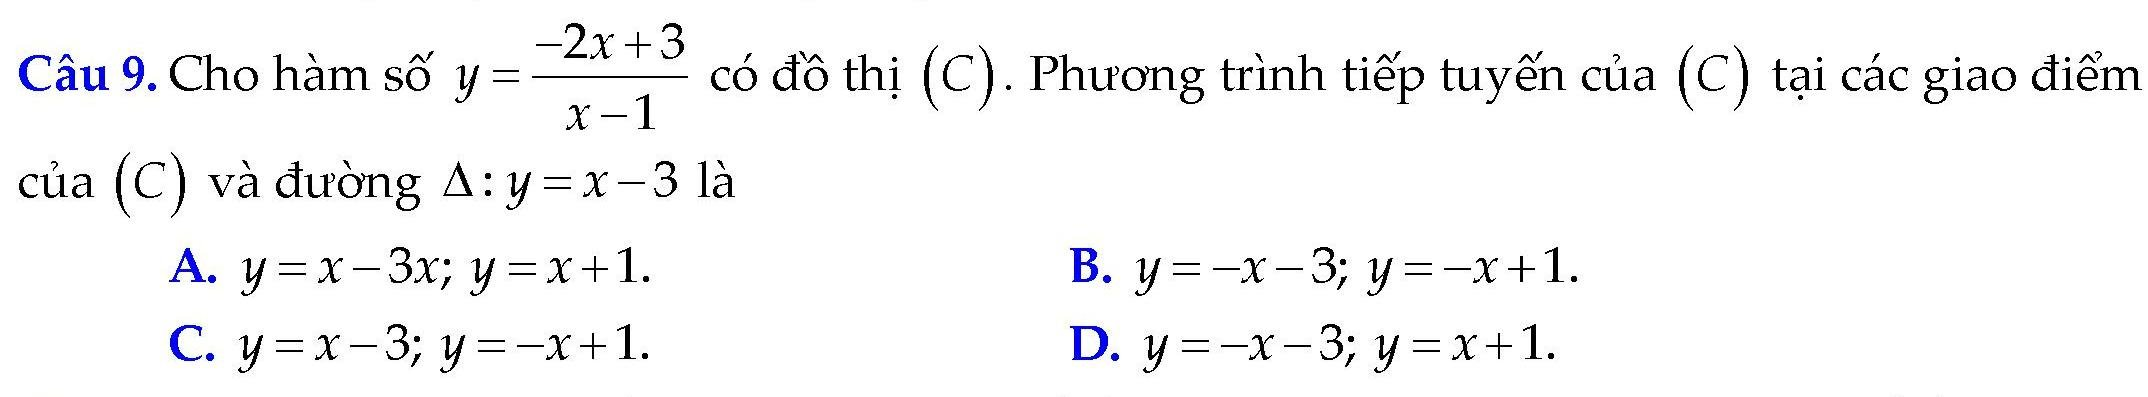

************
PAIRS: 11 - Cosine score: 0.5978223620490908
-- Number of words: 33


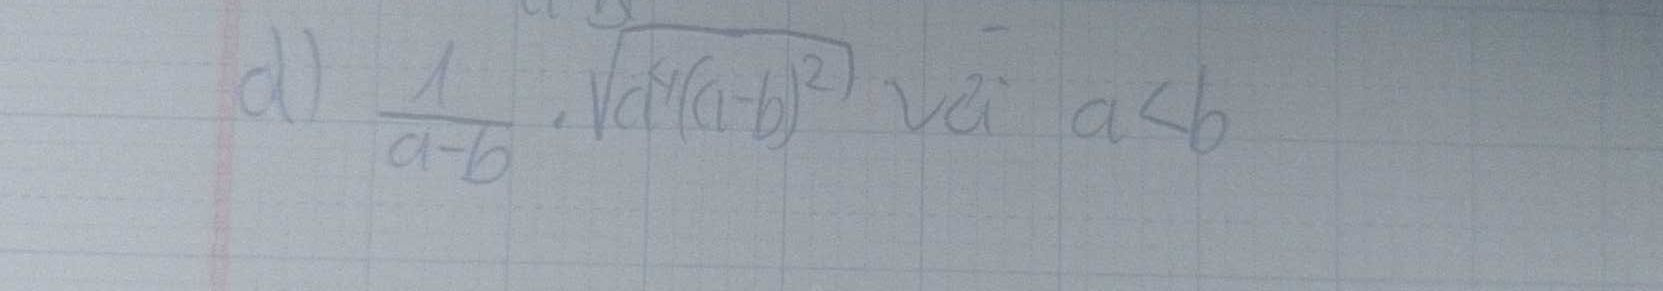

-- Number of words: 35


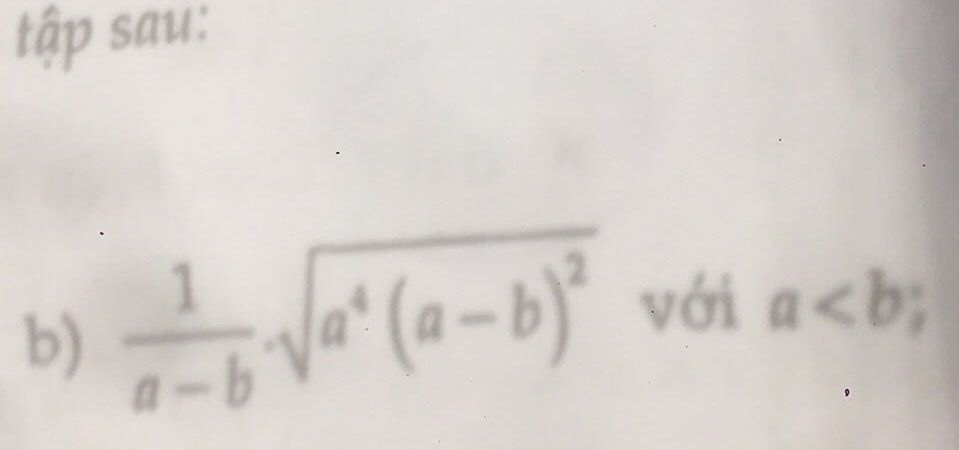

-- Number of words: 122


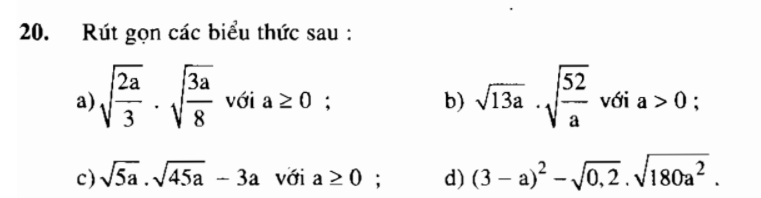

************
PAIRS: 12 - Cosine score: 0.5360611064324313
-- Number of words: 12


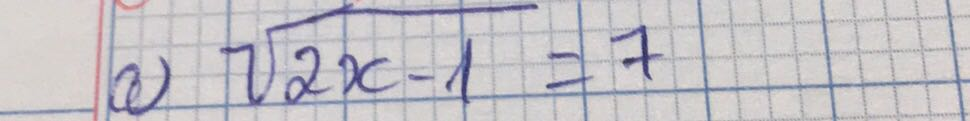

-- Number of words: 46


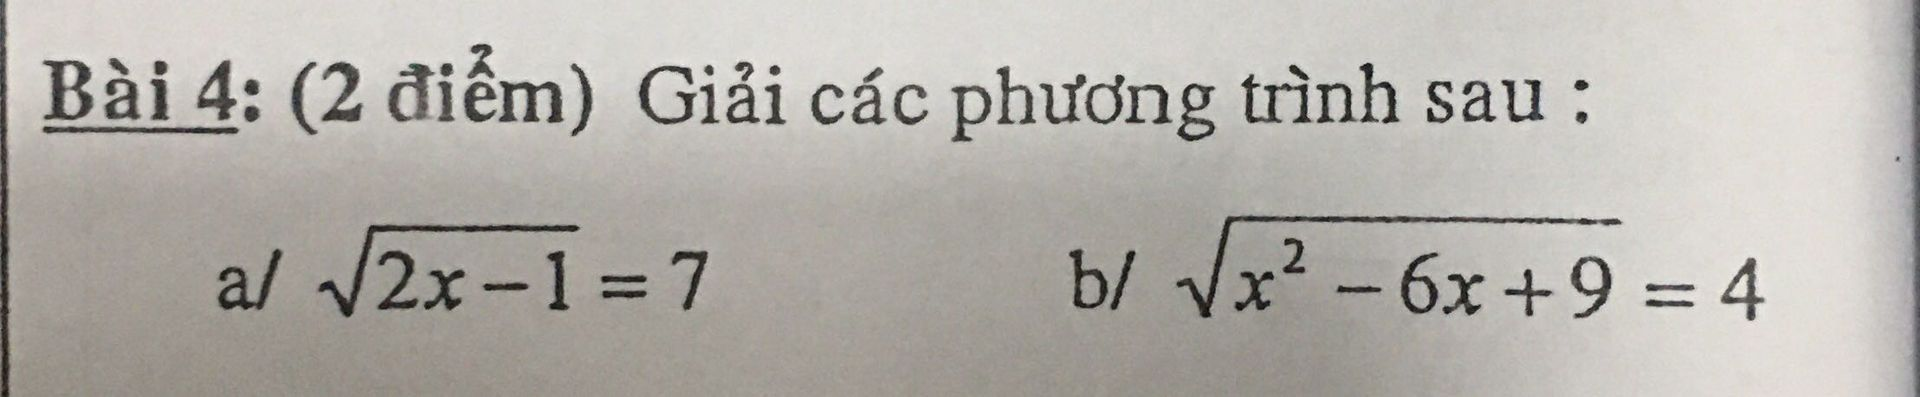

-- Number of words: 13


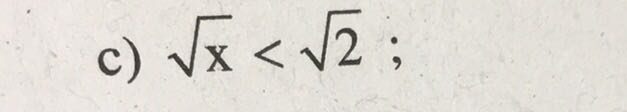

************
PAIRS: 13 - Cosine score: 0.4958372771494451
-- Number of words: 78


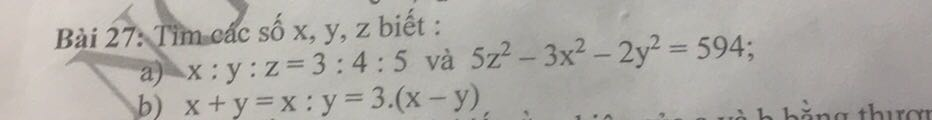

-- Number of words: 79


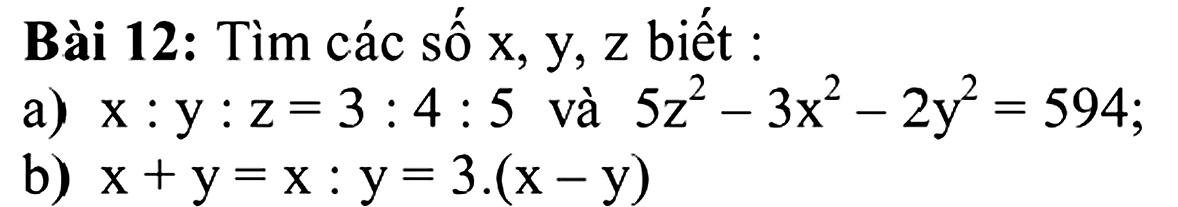

-- Number of words: 16


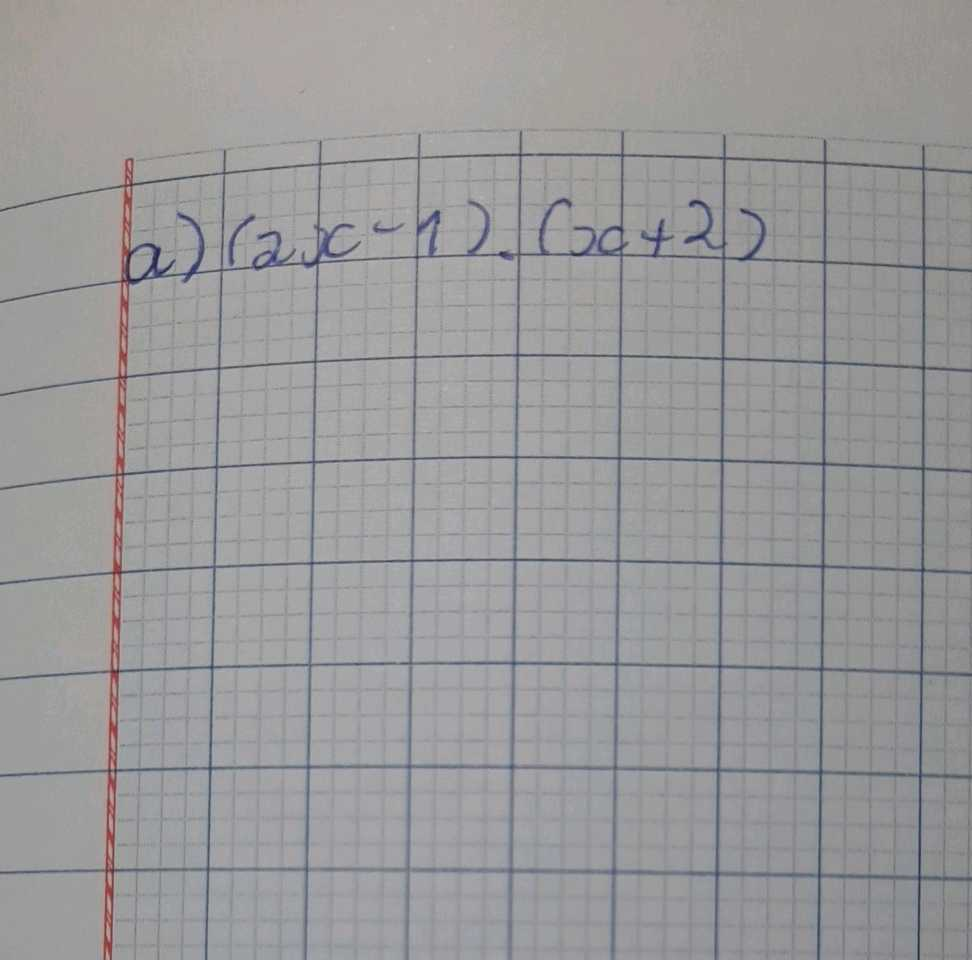

************
PAIRS: 14 - Cosine score: 0.47601178473909783
-- Number of words: 45


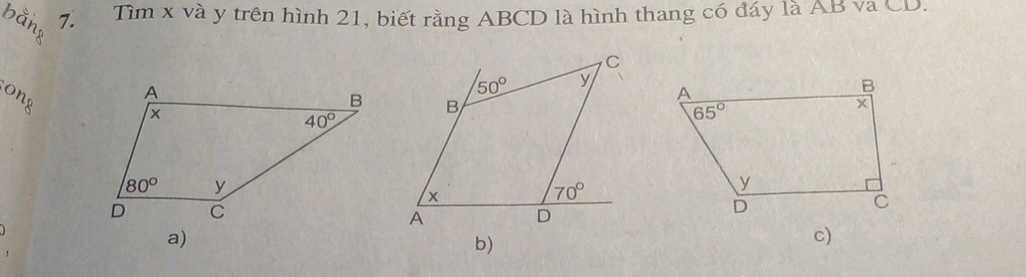

-- Number of words: 40


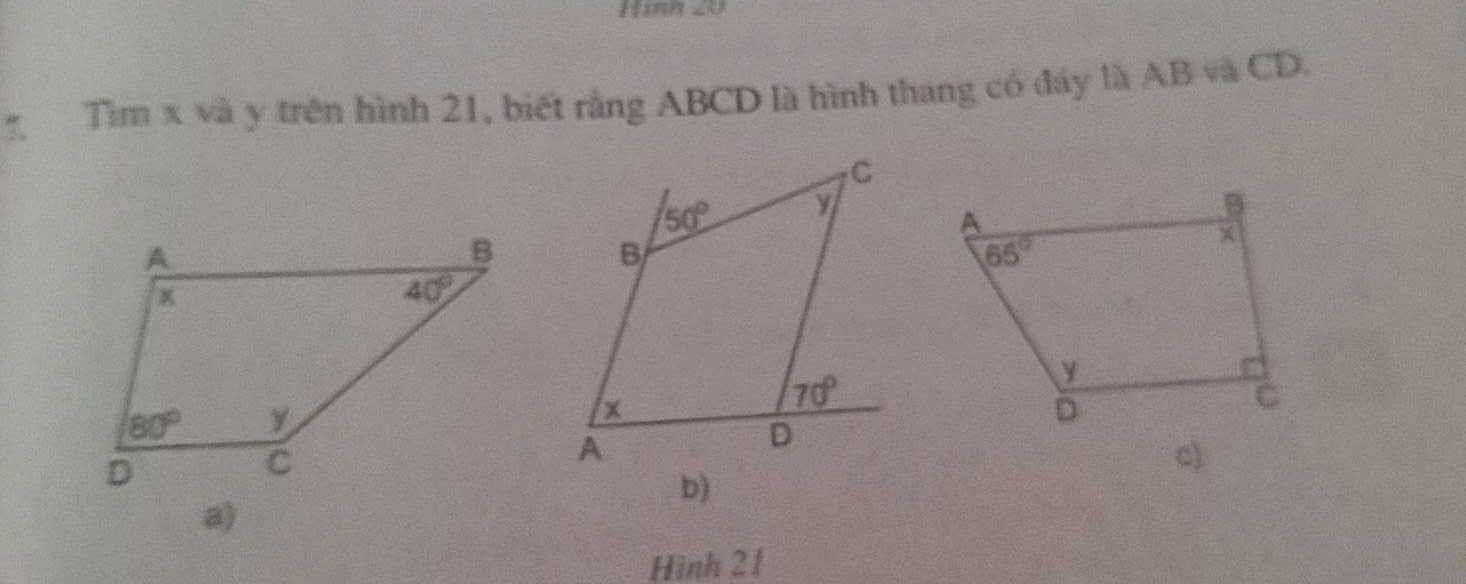

-- Number of words: 86


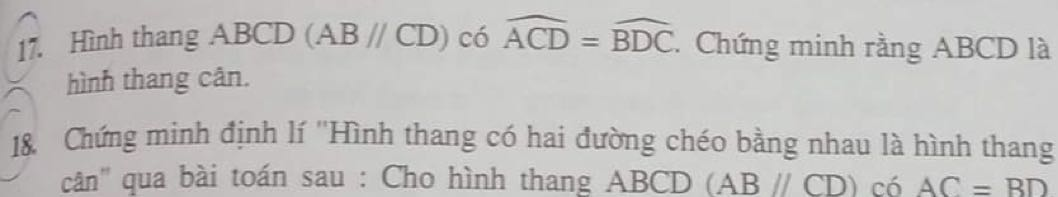

************
PAIRS: 15 - Cosine score: 0.42243581520900697
-- Number of words: 100


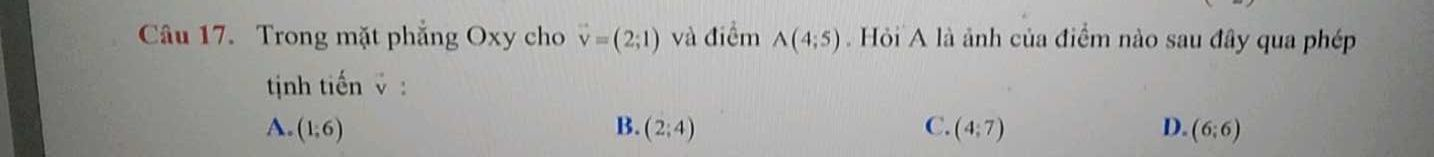

-- Number of words: 104


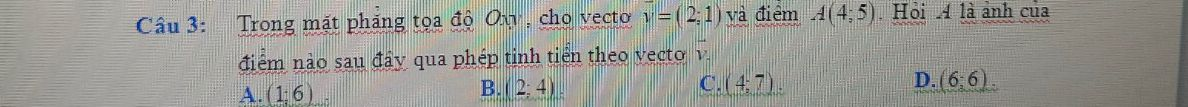

-- Number of words: 64


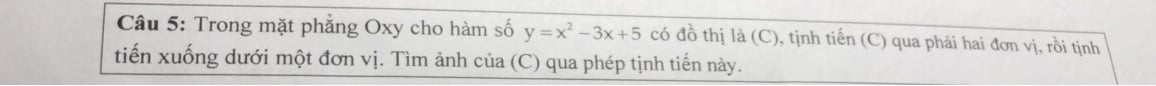

************
PAIRS: 16 - Cosine score: 0.27239616038446285
-- Number of words: 62


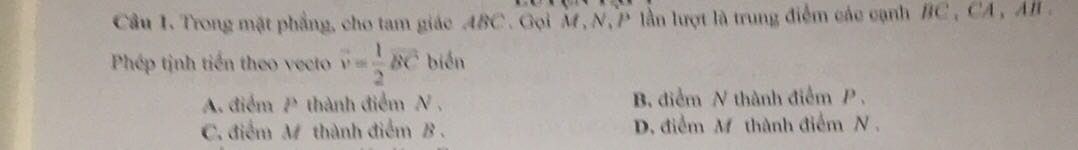

-- Number of words: 121


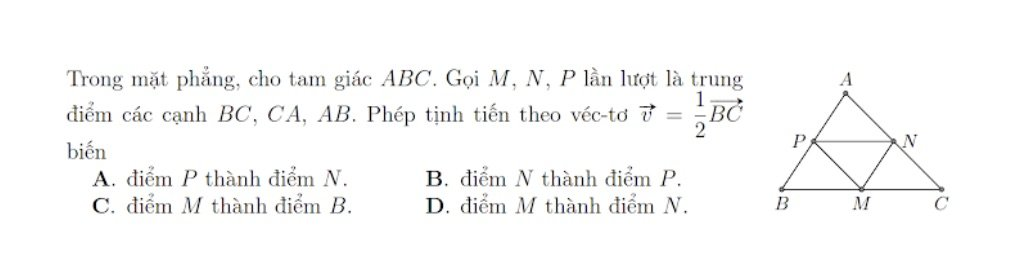

-- Number of words: 90


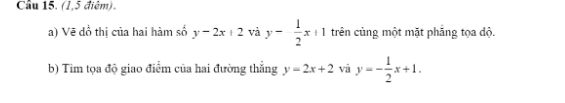

************
PAIRS: 17 - Cosine score: 0.26670224062637404
-- Number of words: 19


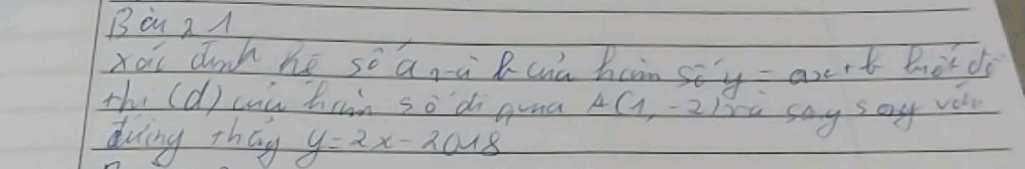

-- Number of words: 66


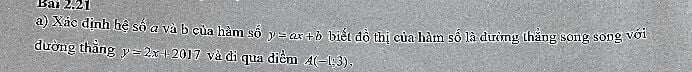

-- Number of words: 118


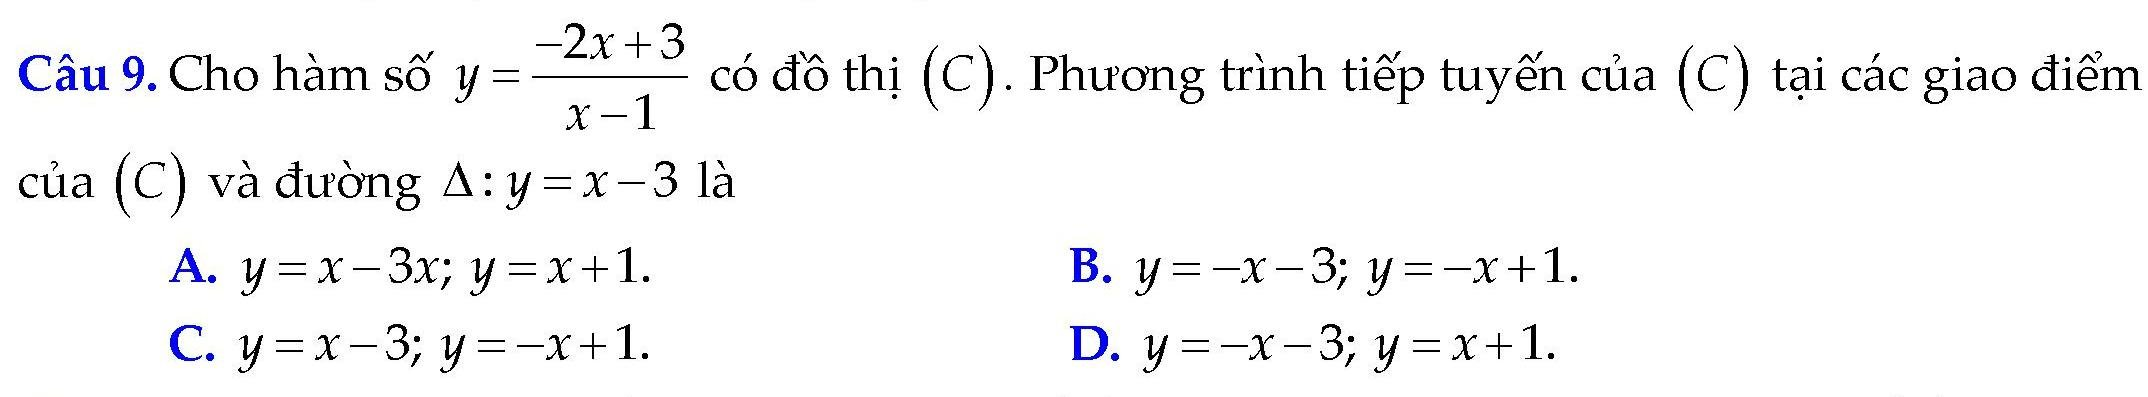

************
PAIRS: 18 - Cosine score: 0.26006885587355016
-- Number of words: 68


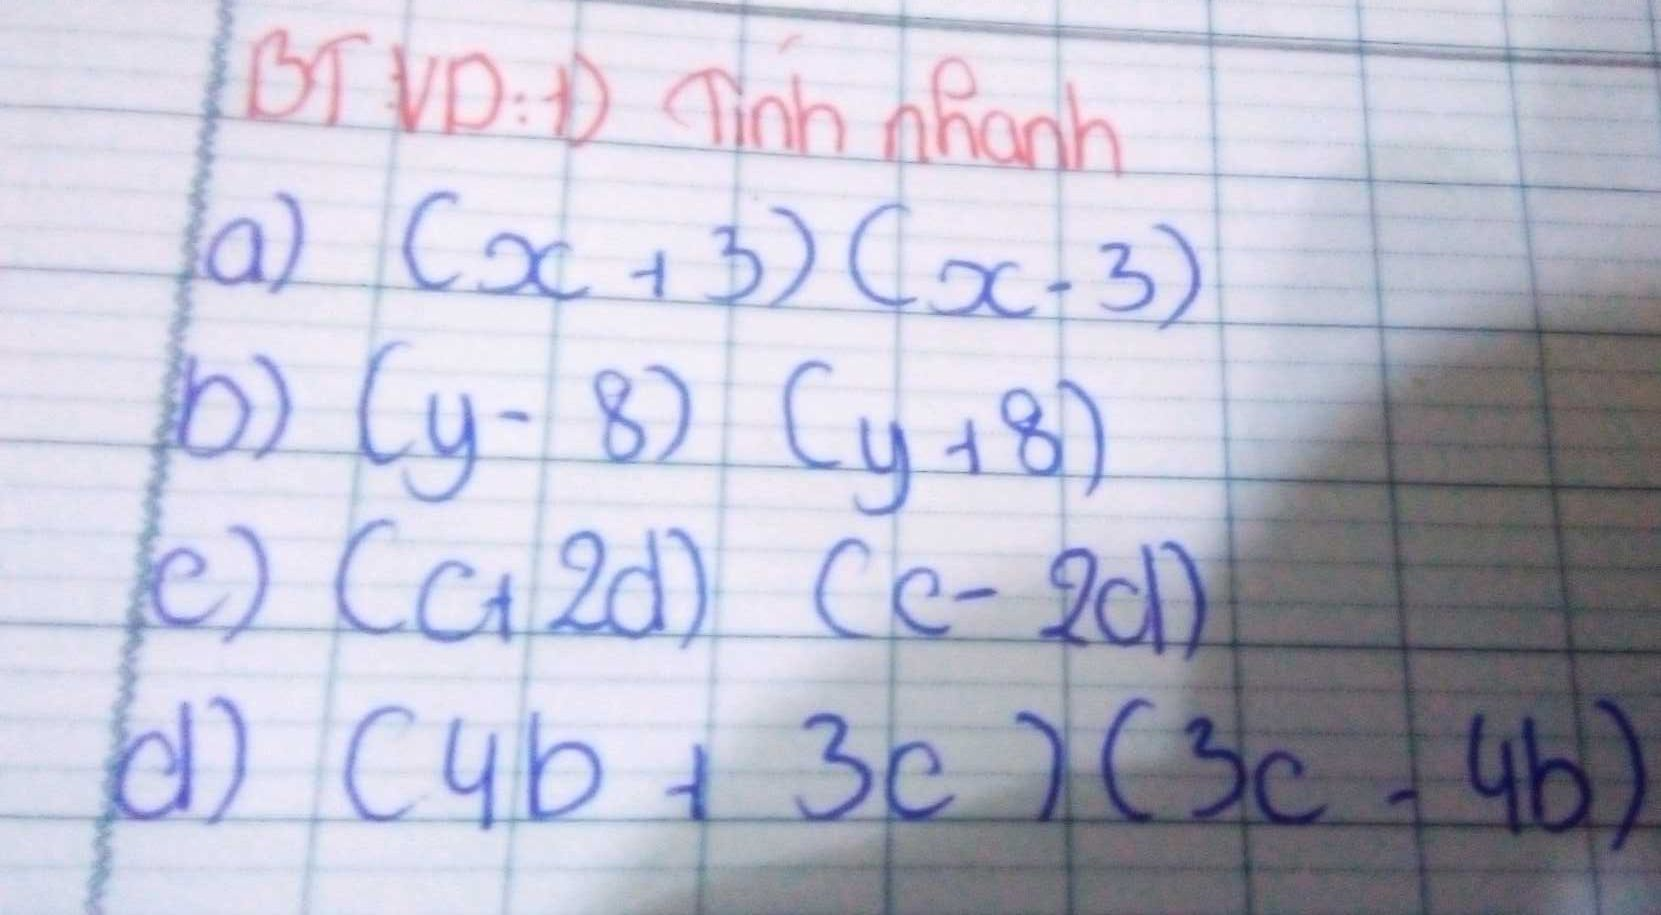

-- Number of words: 62


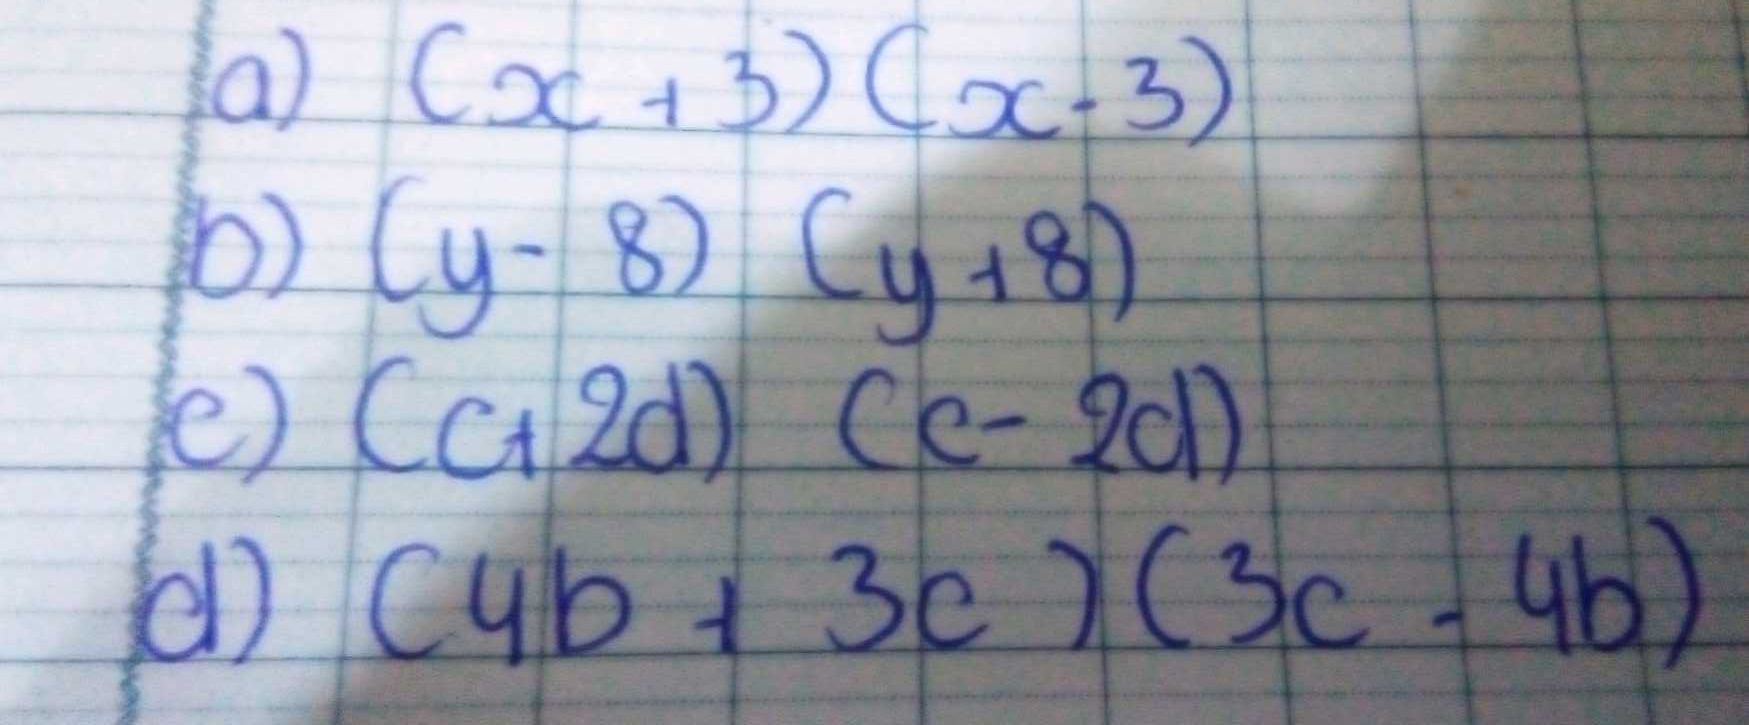

-- Number of words: 99


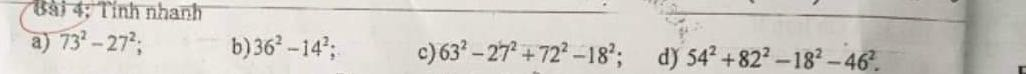

************
PAIRS: 19 - Cosine score: 0.0
-- Number of words: 34


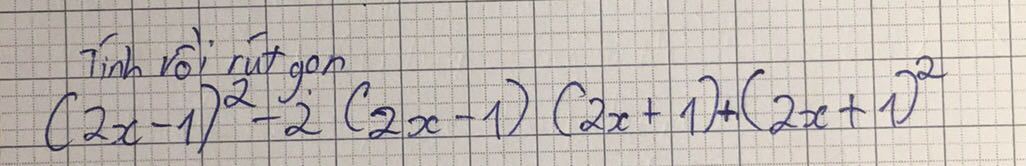

-- Number of words: 40


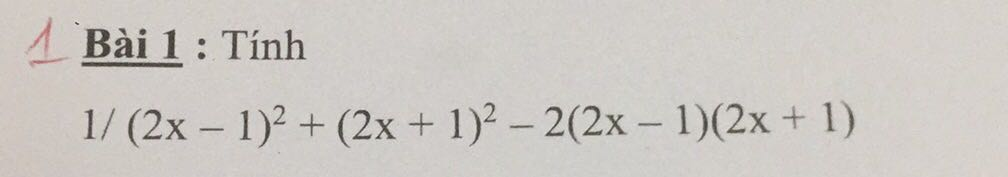

-- Number of words: 157


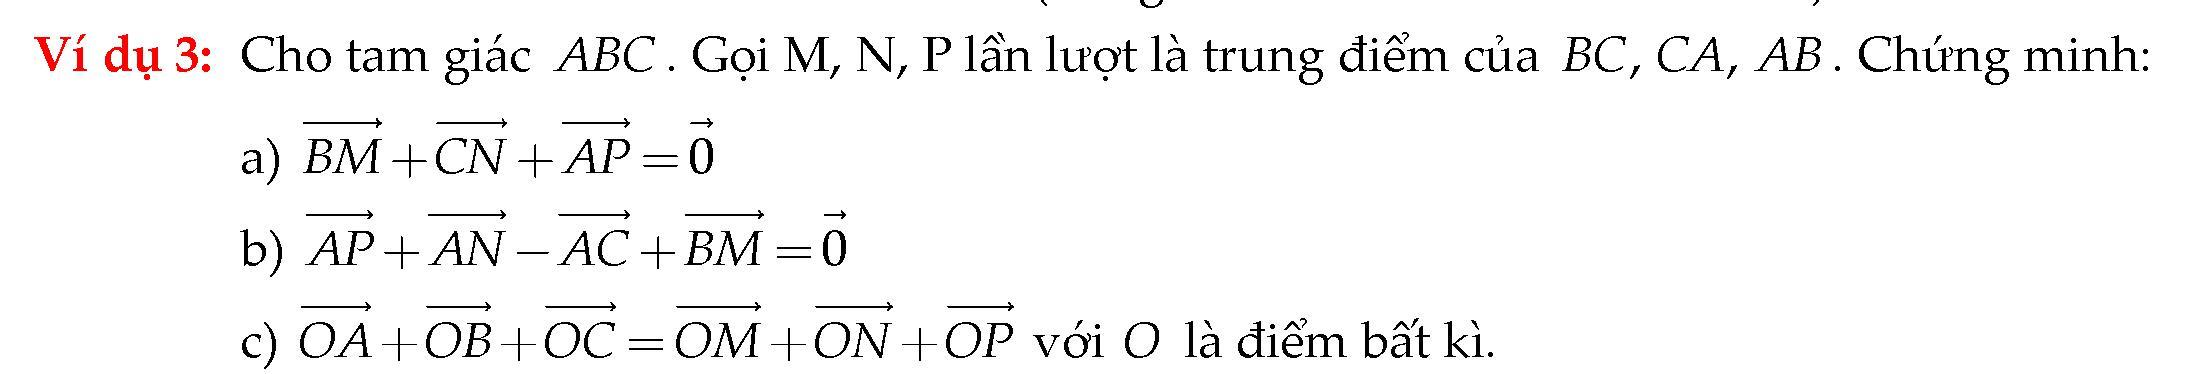

************
PAIRS: 20 - Cosine score: 0.0
-- Number of words: 20


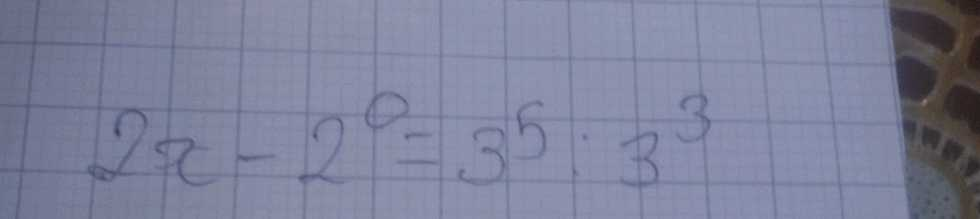

-- Number of words: 22


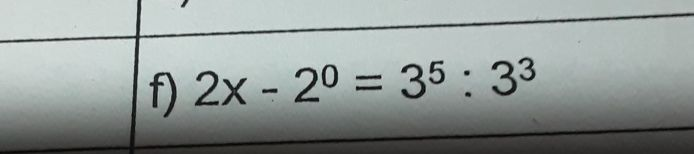

-- Number of words: 157


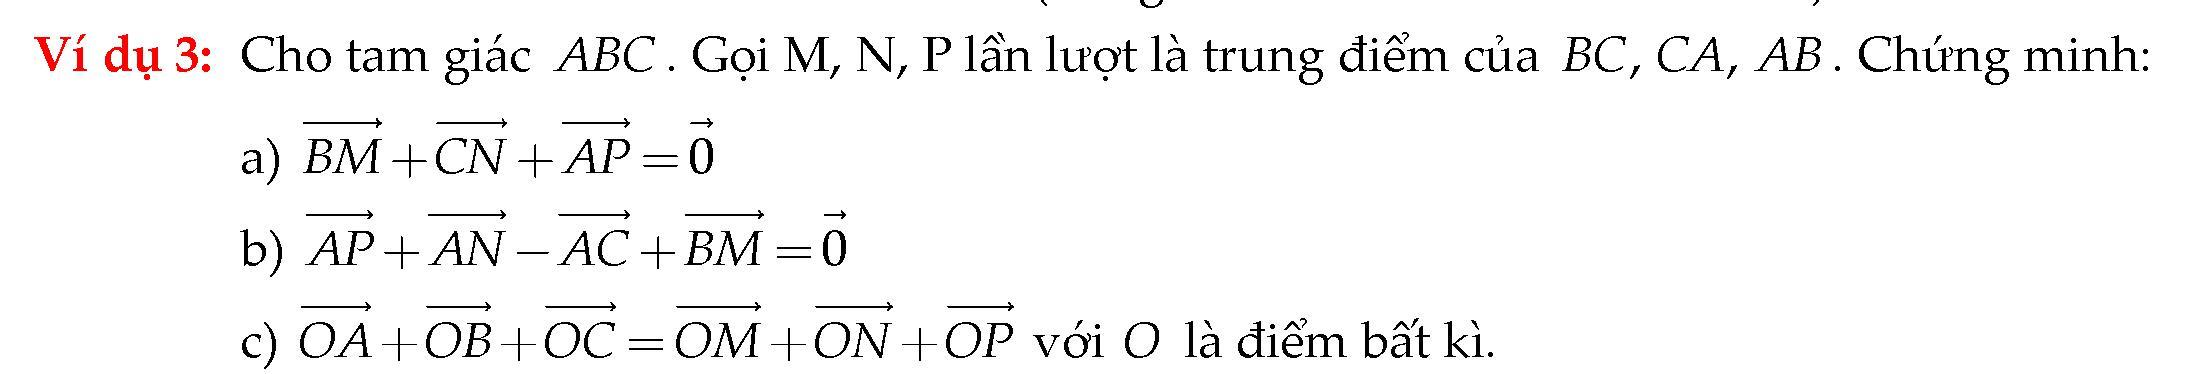

************
PAIRS: 21 - Cosine score: 0.0
-- Number of words: 24


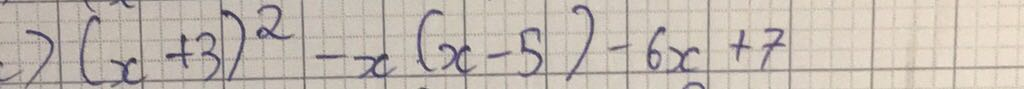

-- Number of words: 25


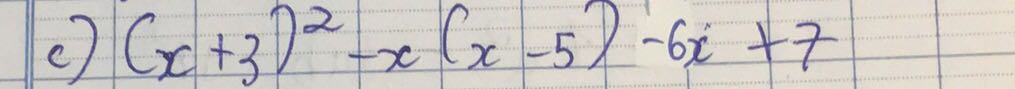

-- Number of words: 157


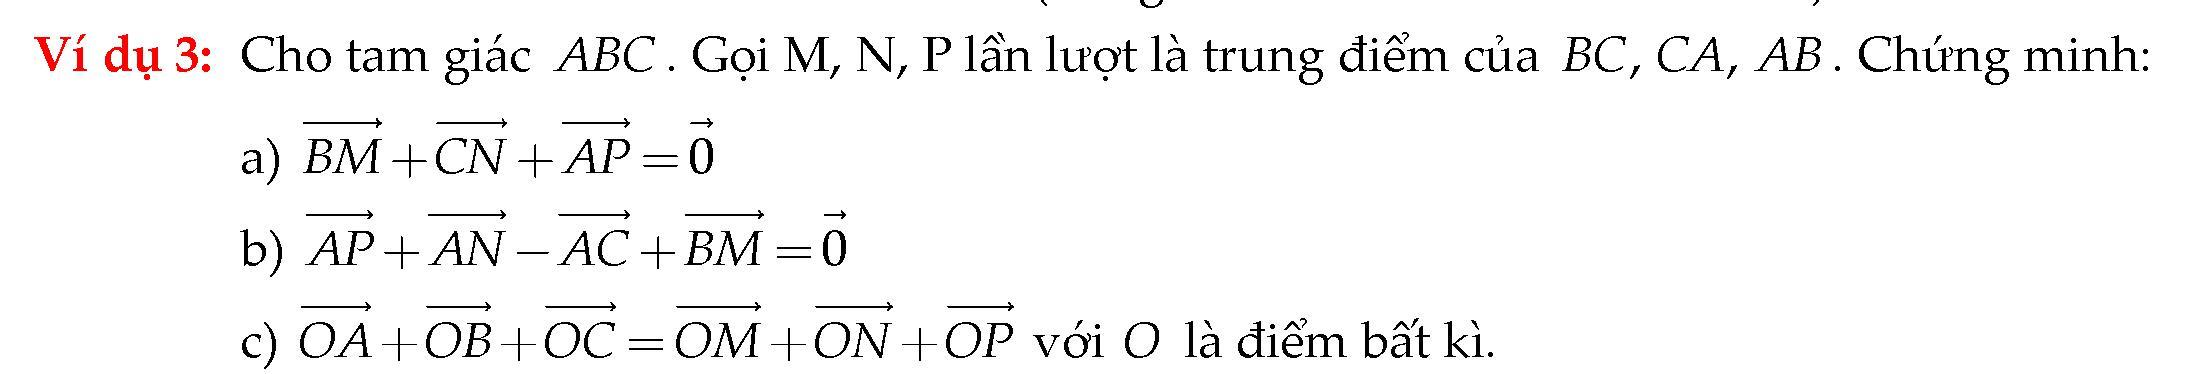

************
PAIRS: 22 - Cosine score: 0.0
-- Number of words: 10


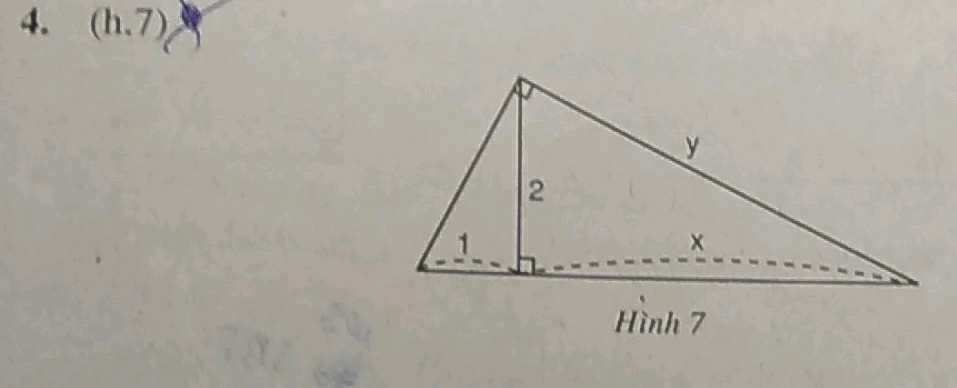

-- Number of words: 10


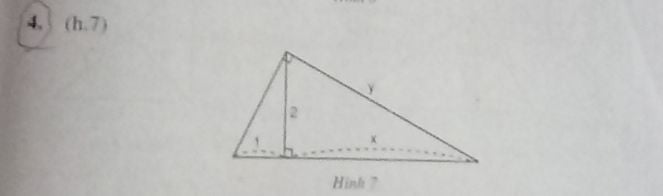

-- Number of words: 157


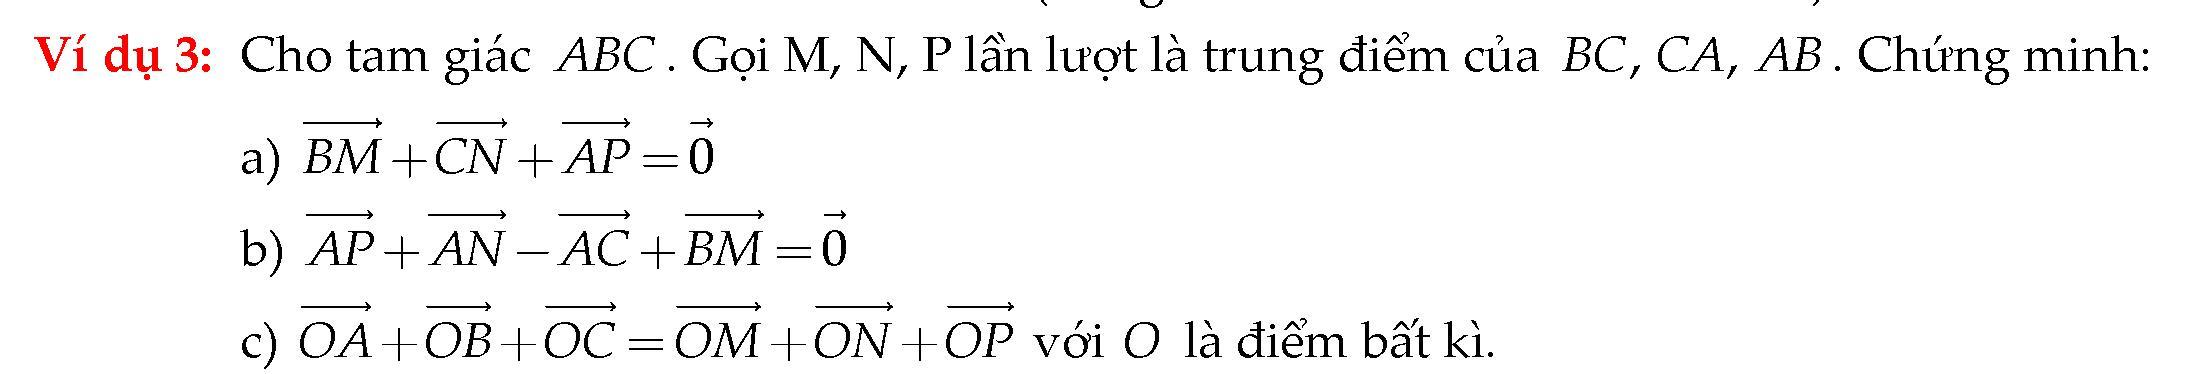

************
PAIRS: 23 - Cosine score: 0.0
-- Number of words: 19


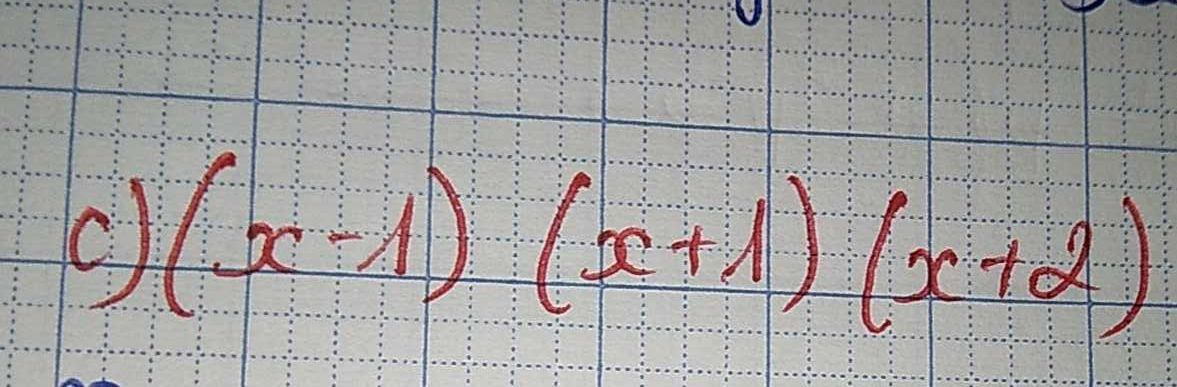

-- Number of words: 19


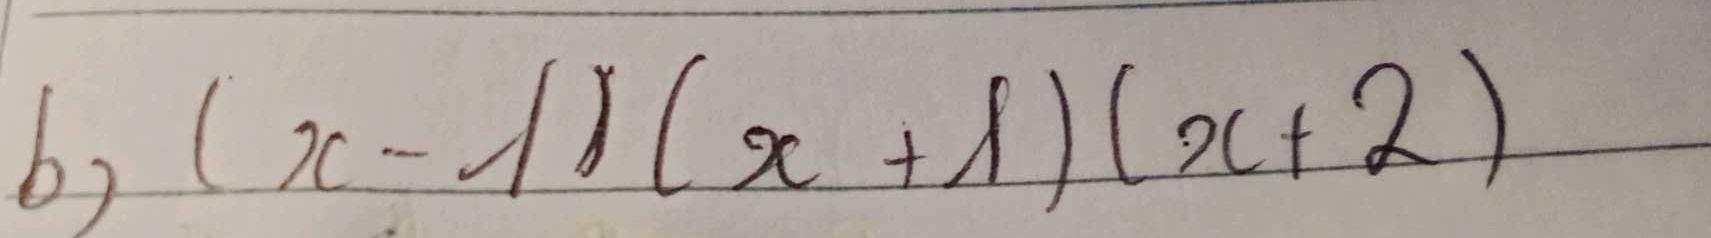

-- Number of words: 157


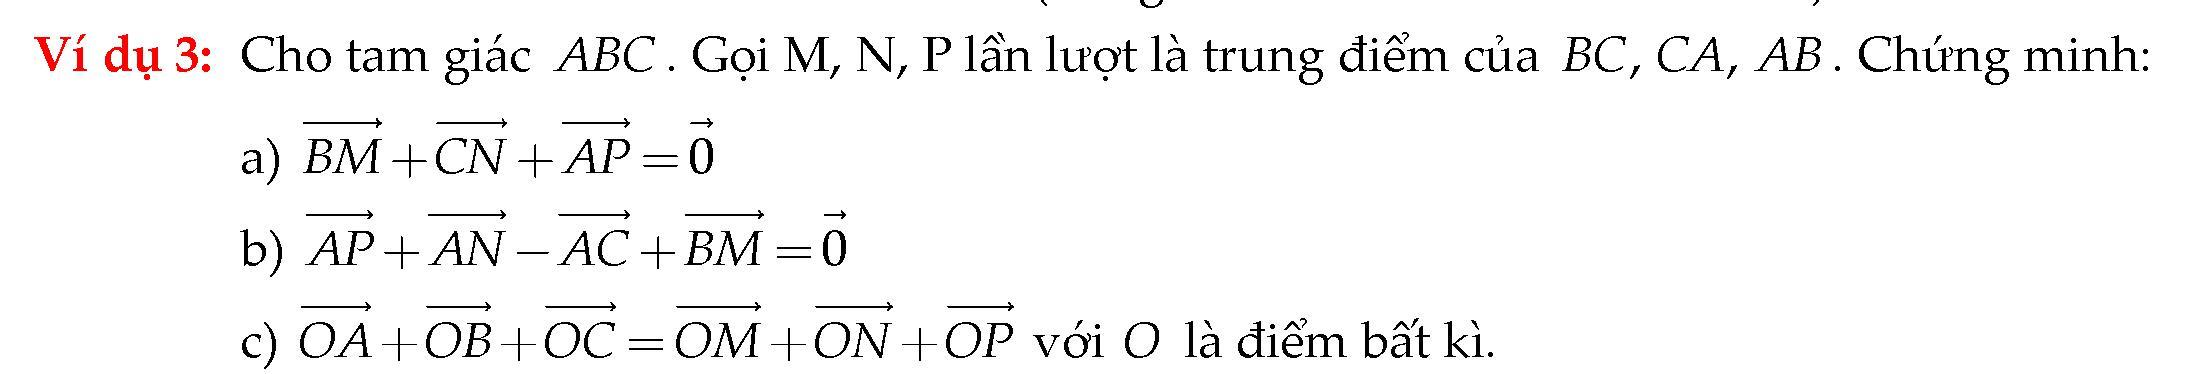

************
PAIRS: 24 - Cosine score: 0.0
-- Number of words: 26


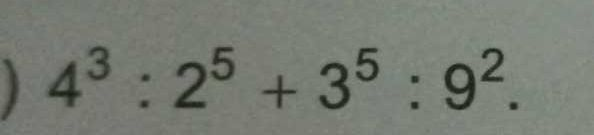

-- Number of words: 28


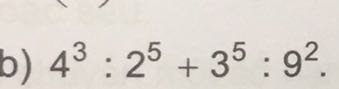

-- Number of words: 157


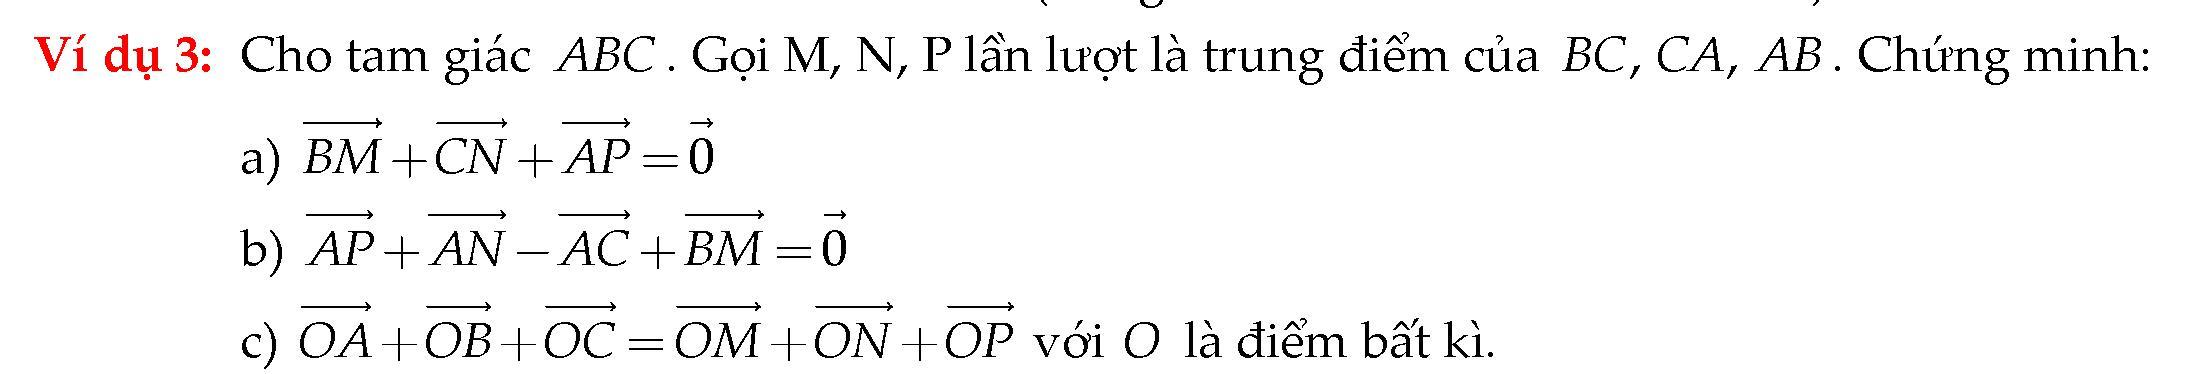

************
PAIRS: 25 - Cosine score: 0.0
-- Number of words: 34


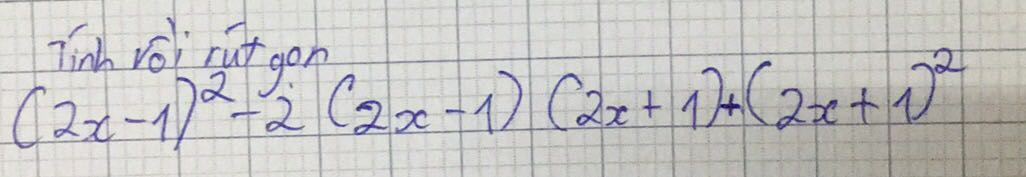

-- Number of words: 34


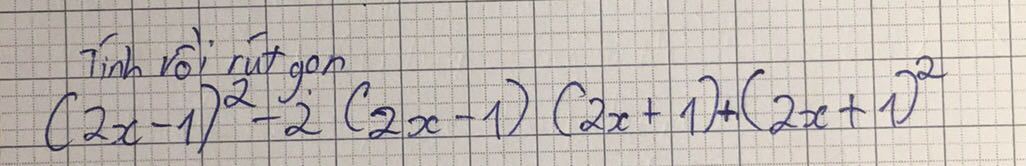

-- Number of words: 157


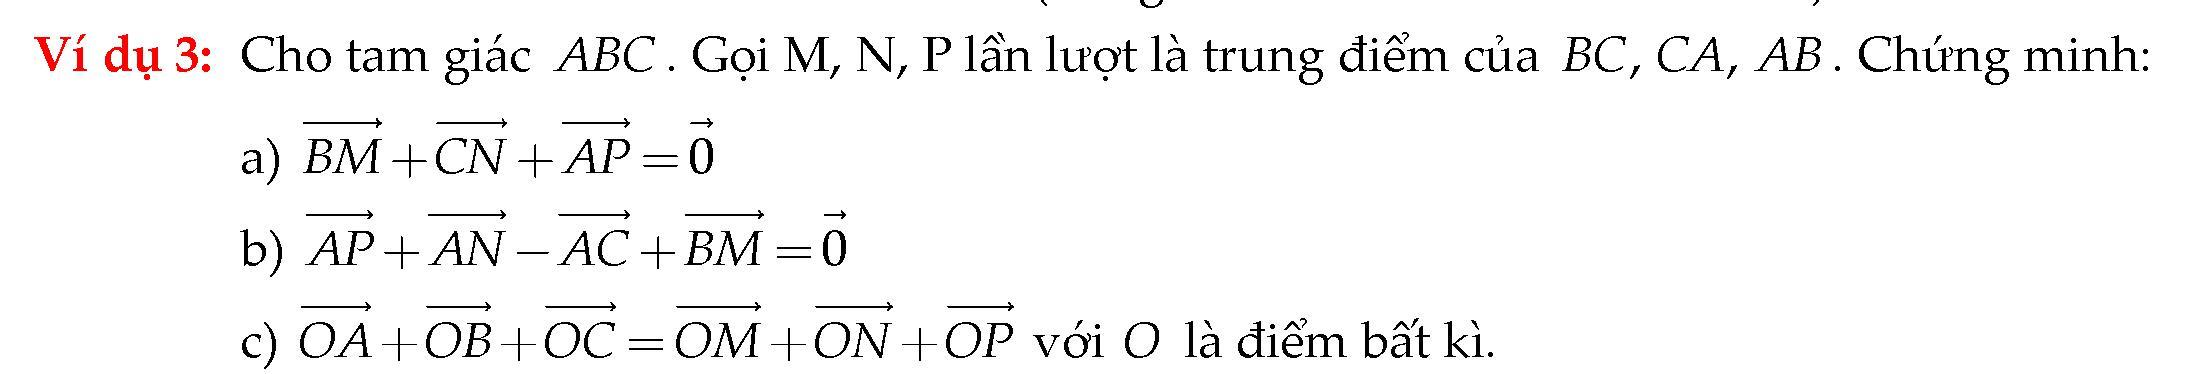

************


In [56]:
idx = 0
for url1, url2 in zip(df_no_pos['Question Image'].values, df_no_pos['cosine_image'].values):
    print('PAIRS: {} - Cosine score: {}'.format(idx + 1, df_no_pos['score'].values[idx]))
    print('-- Number of words:', df_no_pos['word_count_lookup'].values[idx])
    img0 = Disp.Image(requests.get(df_no_pos['Lookup Image'].values[idx]).content)
    display(img0)
    print('-- Number of words:', df_no_pos['word_count_question'].values[idx])
    img1 = Disp.Image(requests.get(url1).content)
    display(img1)
    print('-- Number of words:', df_no_pos['cosine_word_count_question'].values[idx])
    img2 = Disp.Image(requests.get(url2).content)
    display(img2)
    print('************')
    idx += 1

PAIRS: 1 - Cosine score: 0.9215186504454124
-- Number of words: 129


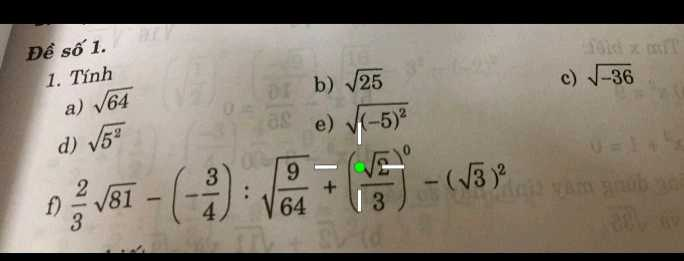

-- Number of words: 131


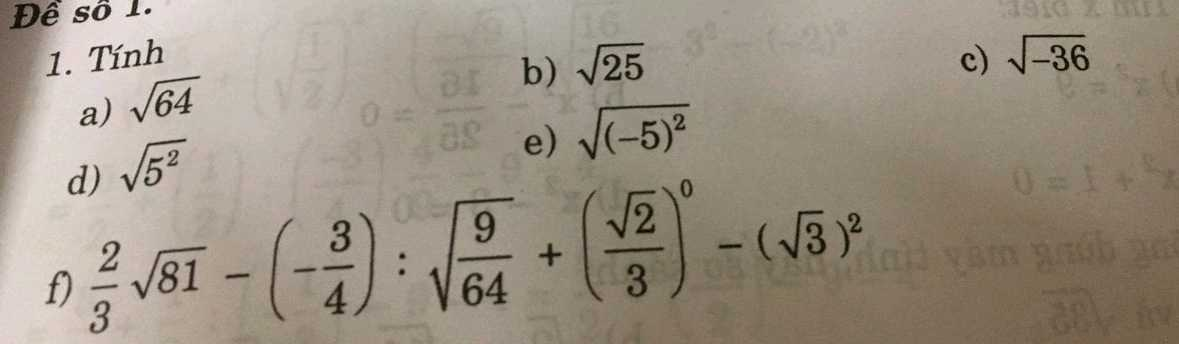

-- Number of words: 131


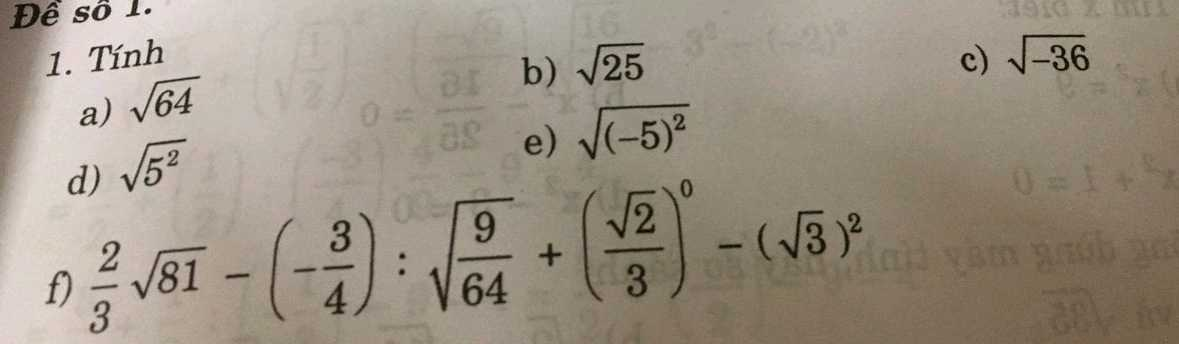

************
PAIRS: 2 - Cosine score: 1.0000000000000002
-- Number of words: 73


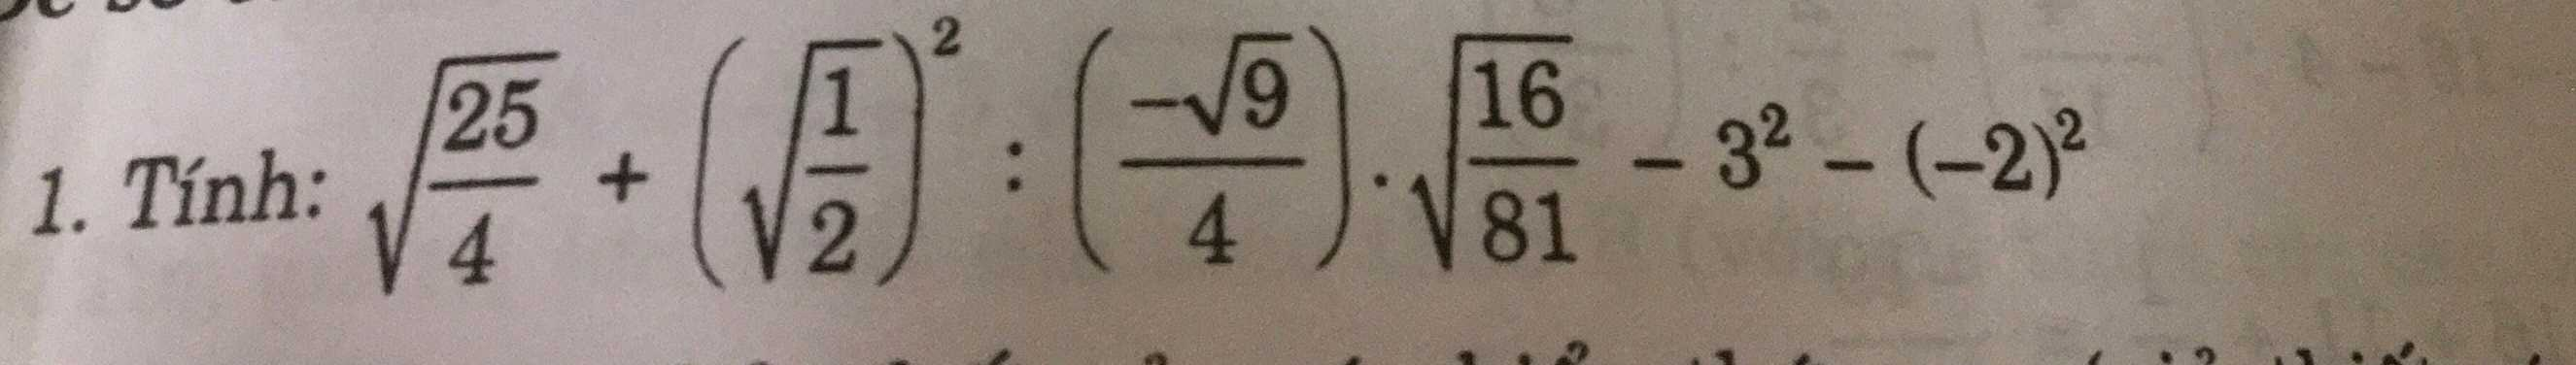

-- Number of words: 80


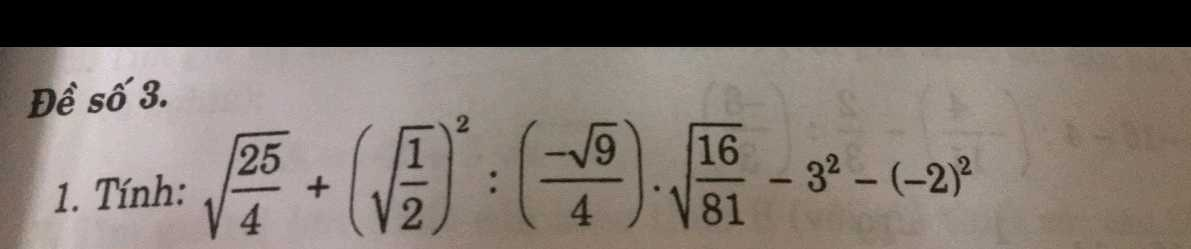

-- Number of words: 80


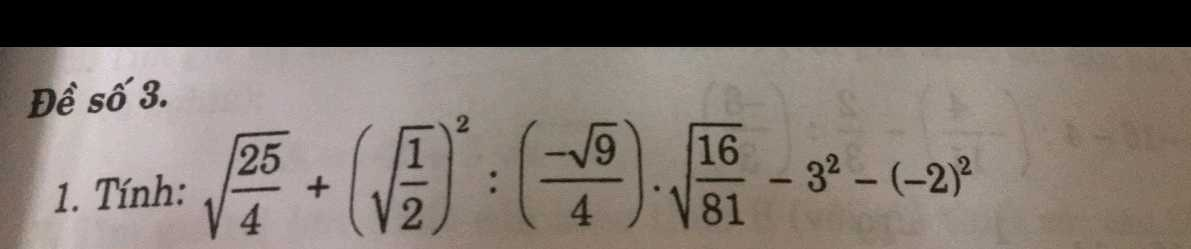

************
PAIRS: 3 - Cosine score: 0.768646921516972
-- Number of words: 36


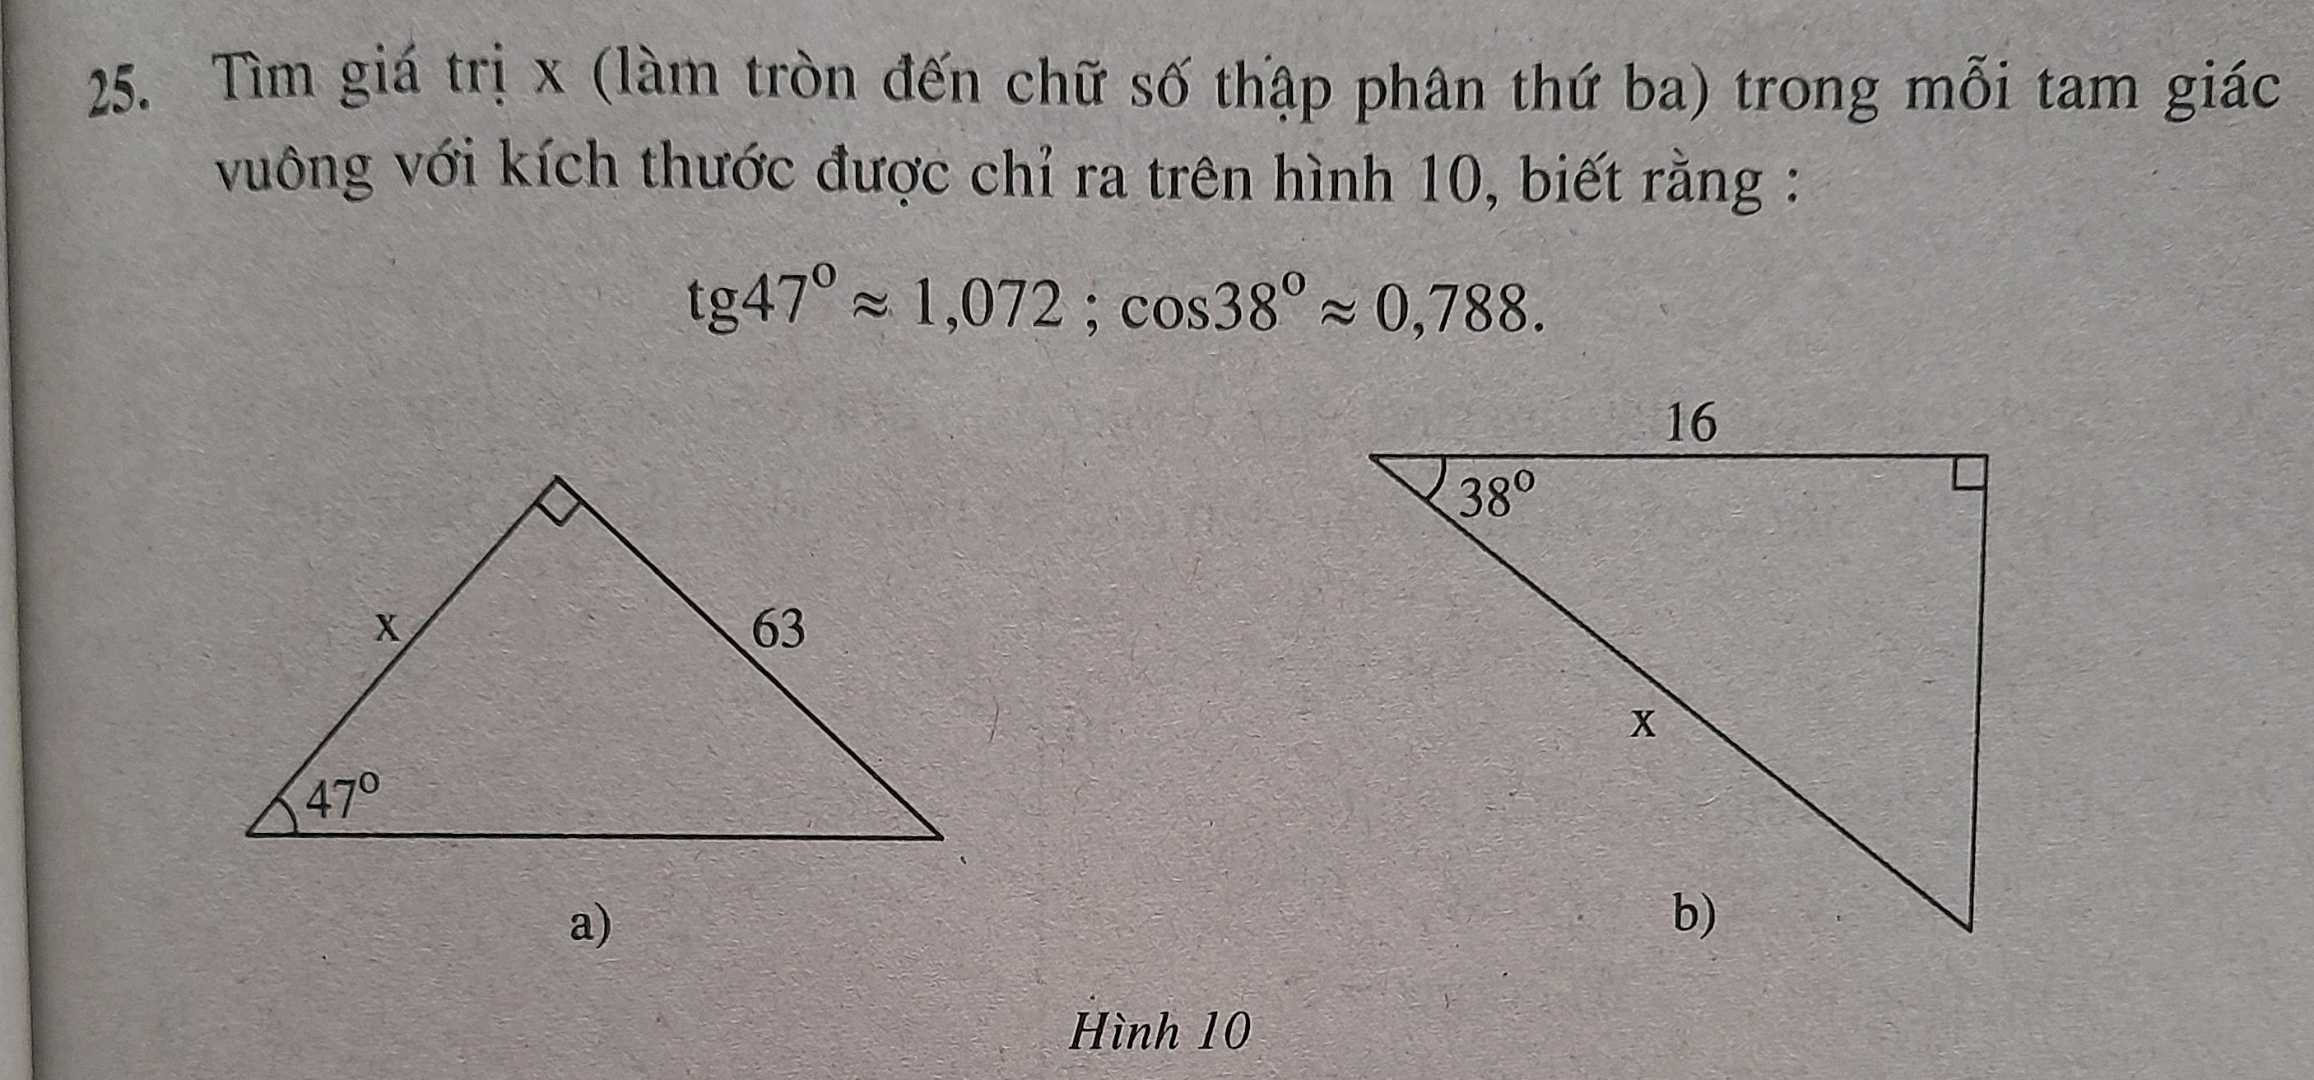

-- Number of words: 45


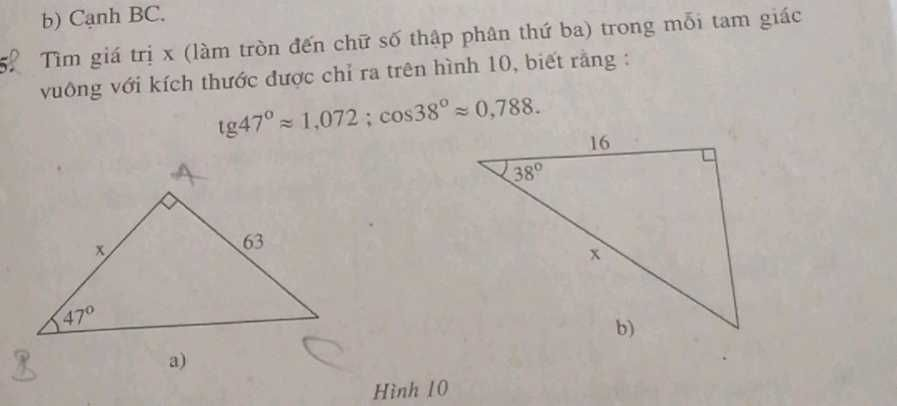

-- Number of words: 45


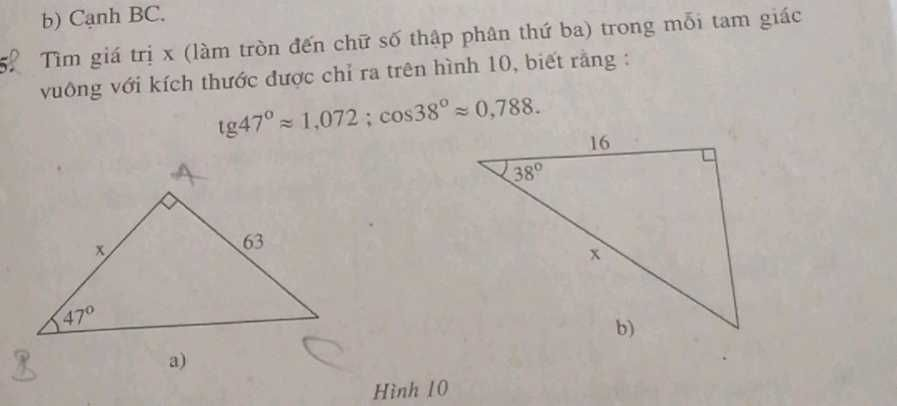

************
PAIRS: 4 - Cosine score: 0.9938157782487124
-- Number of words: 72


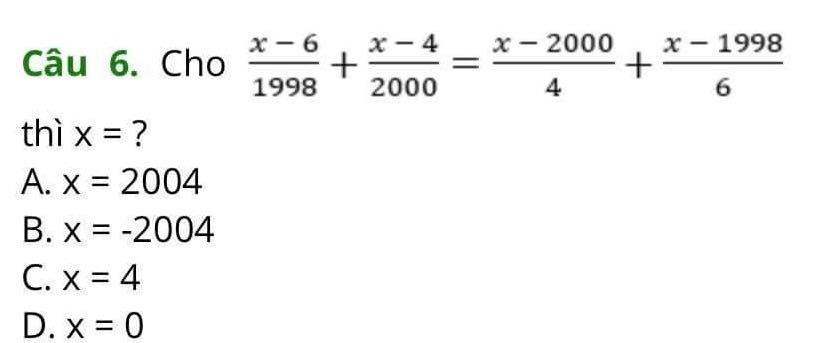

-- Number of words: 72


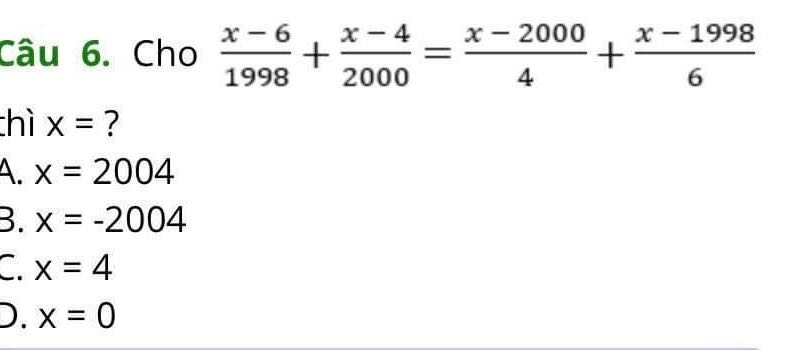

-- Number of words: 72


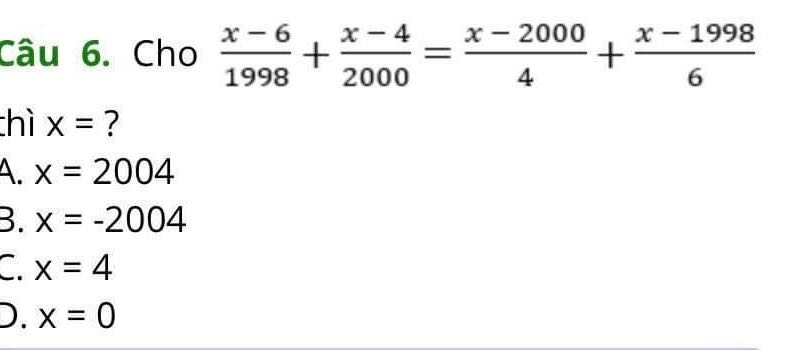

************
PAIRS: 5 - Cosine score: 0.9848337016104216
-- Number of words: 153


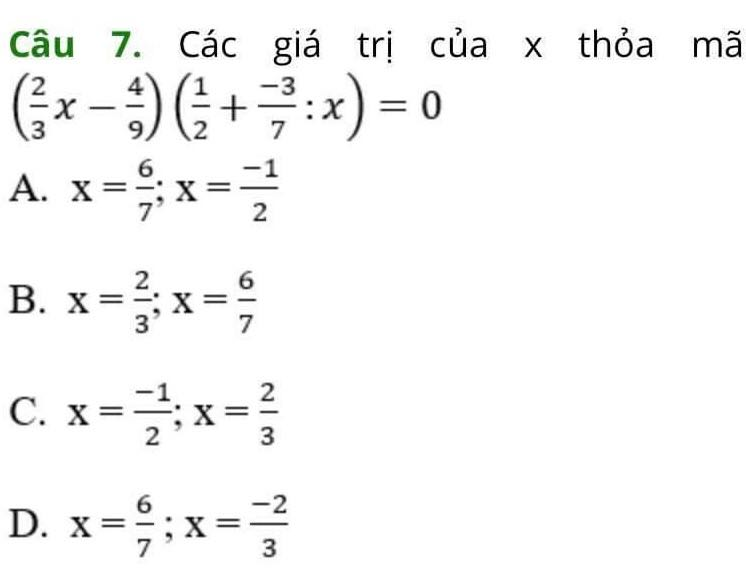

-- Number of words: 153


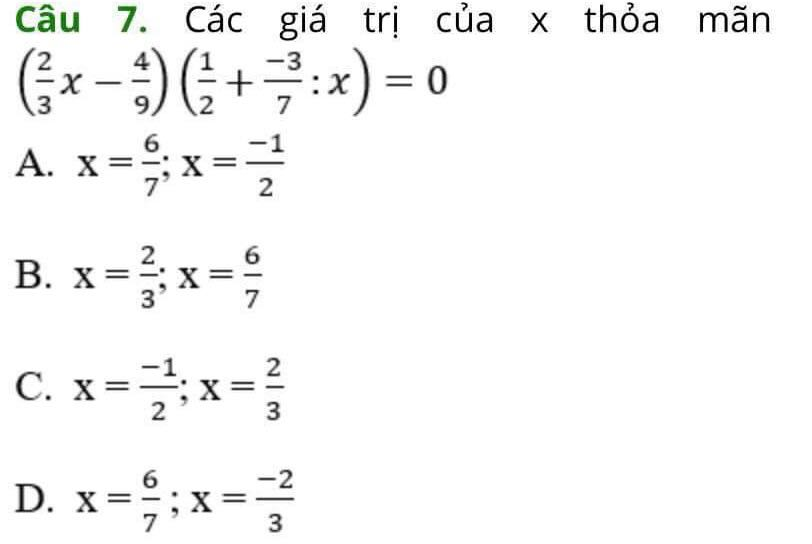

-- Number of words: 153


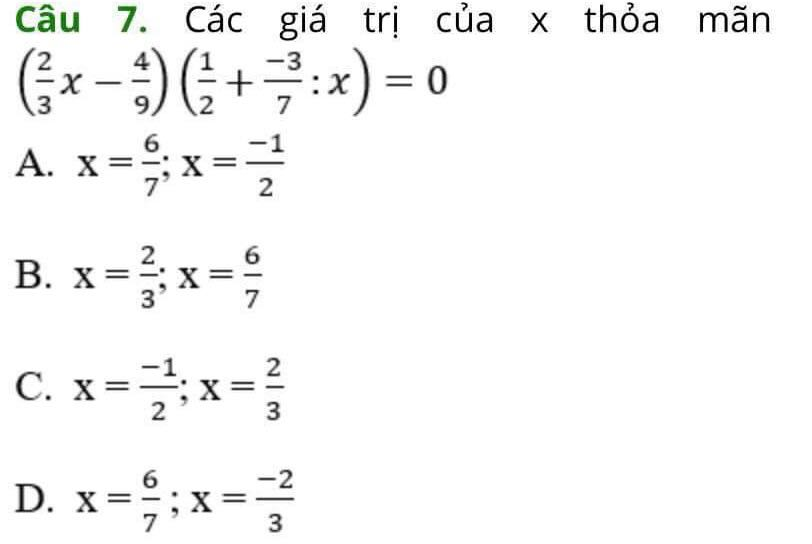

************
PAIRS: 6 - Cosine score: 1.0000000000000002
-- Number of words: 50


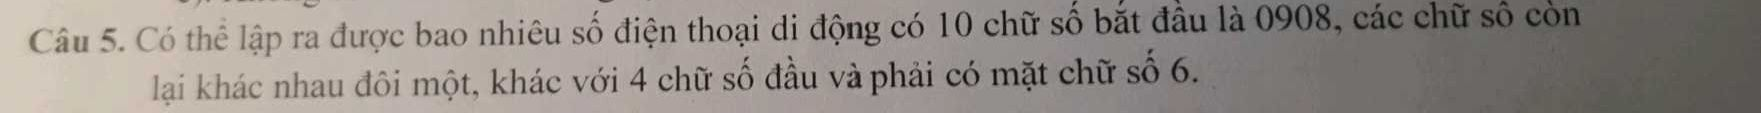

-- Number of words: 47


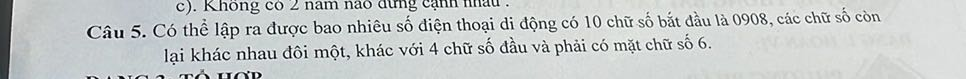

-- Number of words: 47


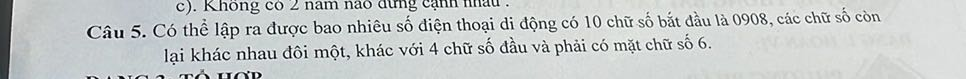

************
PAIRS: 7 - Cosine score: 1.0
-- Number of words: 89


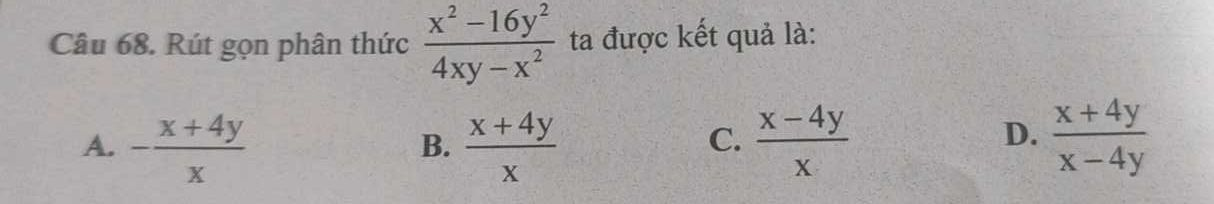

-- Number of words: 89


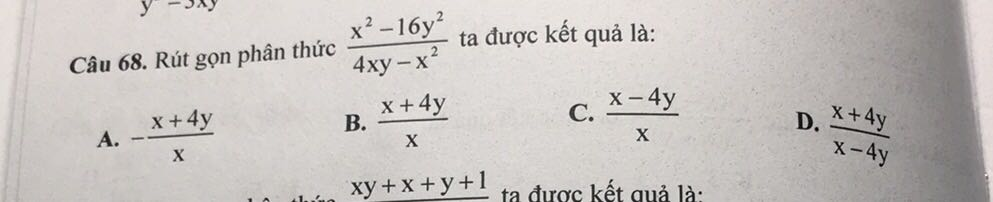

-- Number of words: 89


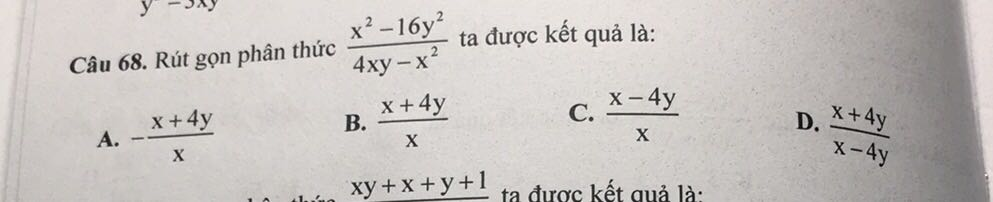

************
PAIRS: 8 - Cosine score: 0.9213130878626523
-- Number of words: 29


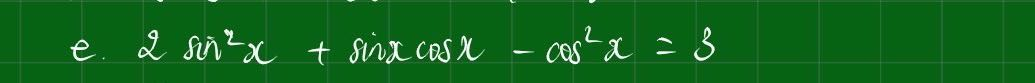

-- Number of words: 31


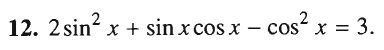

-- Number of words: 31


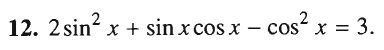

************
PAIRS: 9 - Cosine score: 1.0
-- Number of words: 68


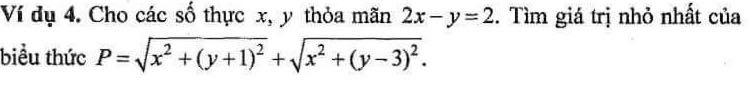

-- Number of words: 68


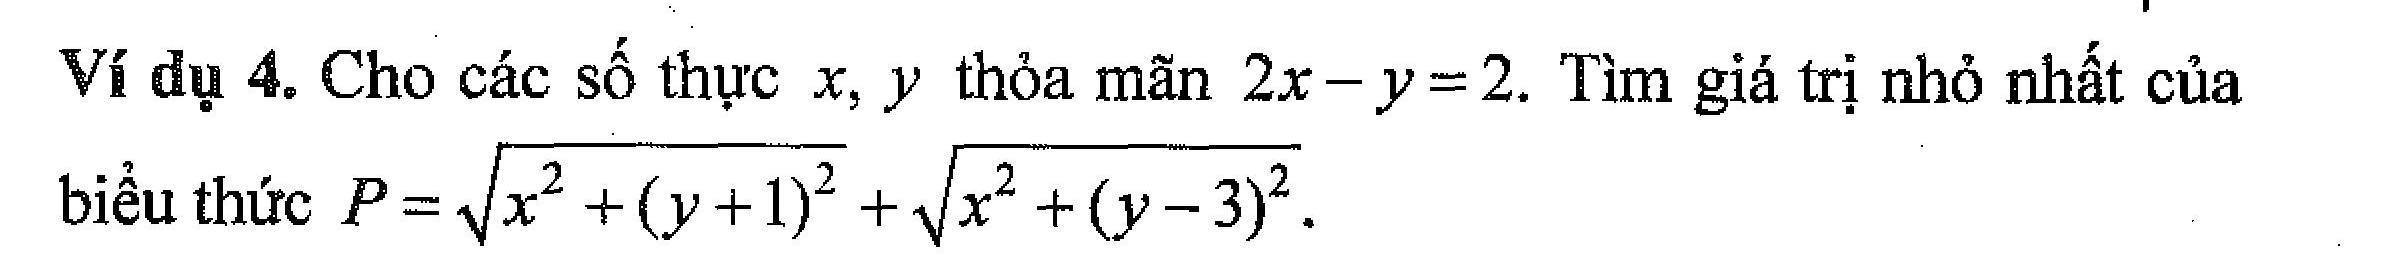

-- Number of words: 68


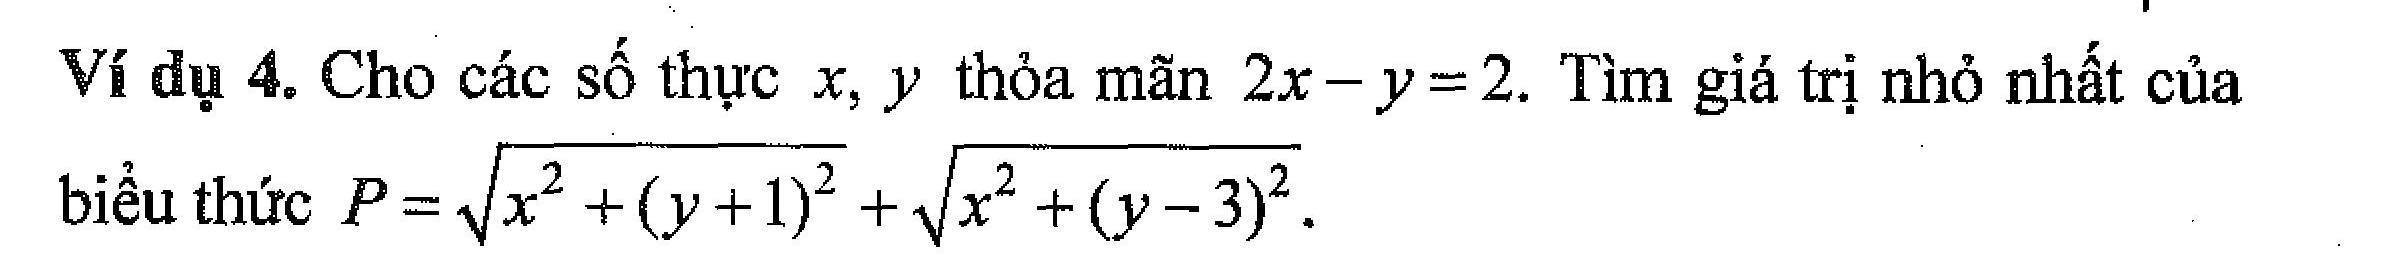

************
PAIRS: 10 - Cosine score: 0.6319883631935467
-- Number of words: 38


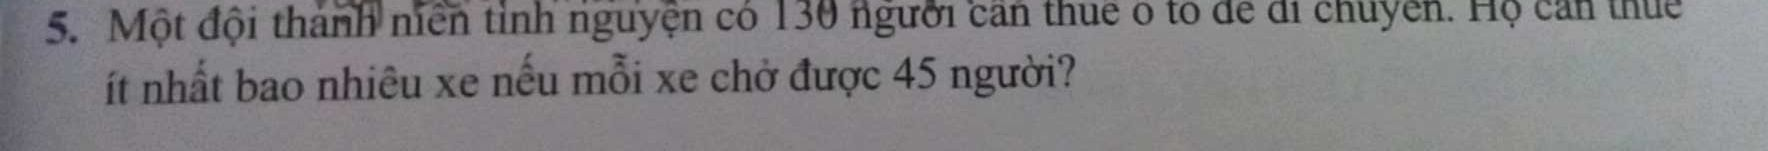

-- Number of words: 32


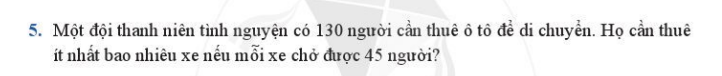

-- Number of words: 32


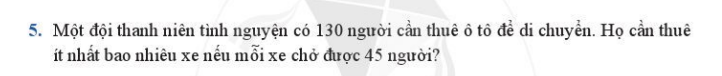

************
PAIRS: 11 - Cosine score: 1.0
-- Number of words: 18


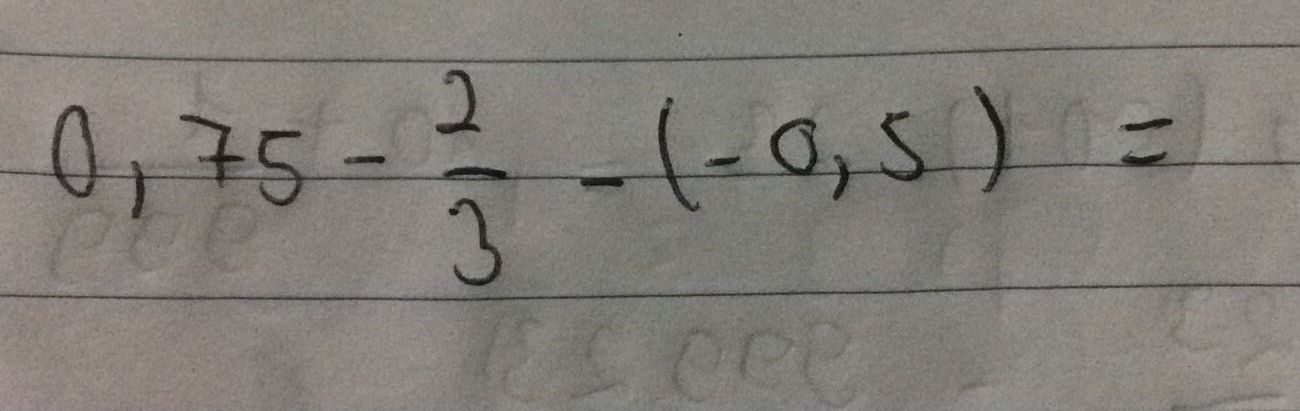

-- Number of words: 18


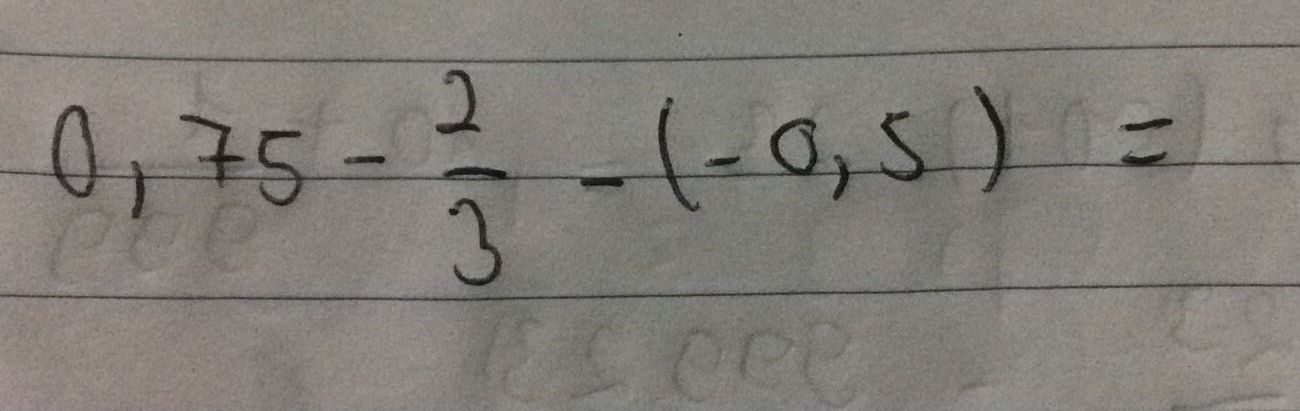

-- Number of words: 18


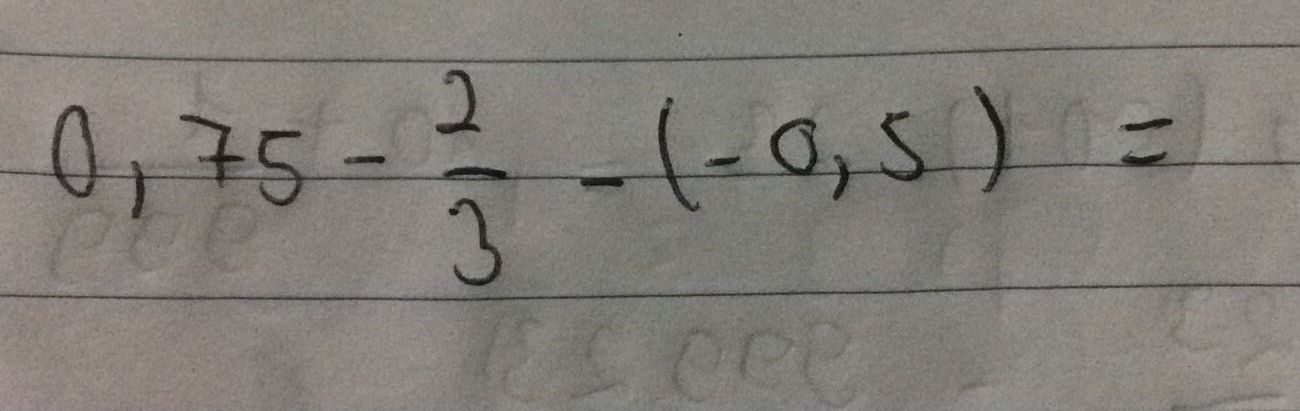

************
PAIRS: 12 - Cosine score: 0.9429694175778431
-- Number of words: 69


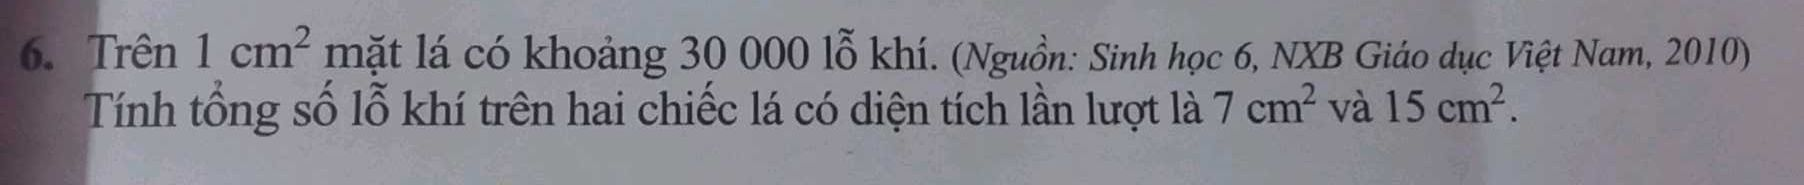

-- Number of words: 69


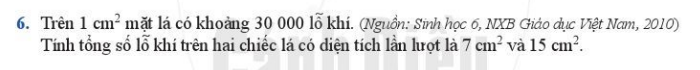

-- Number of words: 69


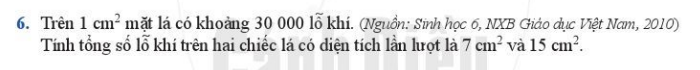

************
PAIRS: 13 - Cosine score: 0.9568527555941102
-- Number of words: 91


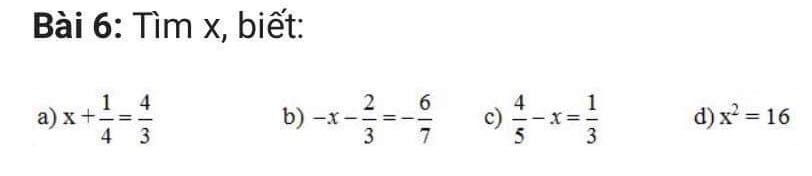

-- Number of words: 96


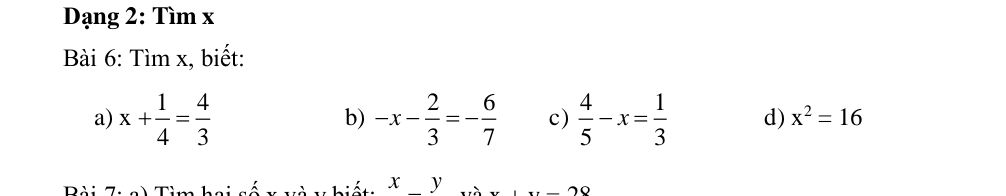

-- Number of words: 96


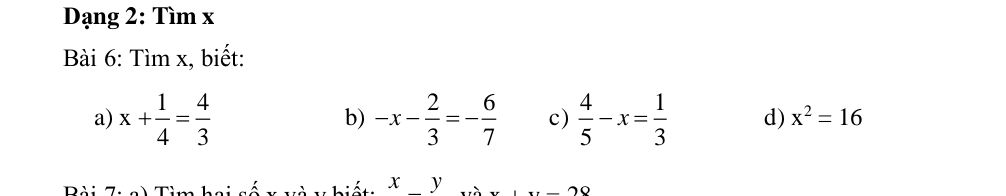

************
PAIRS: 14 - Cosine score: 0.905687652815743
-- Number of words: 147


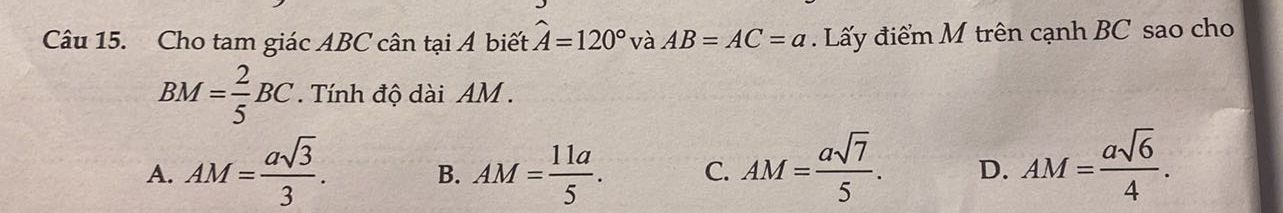

-- Number of words: 134


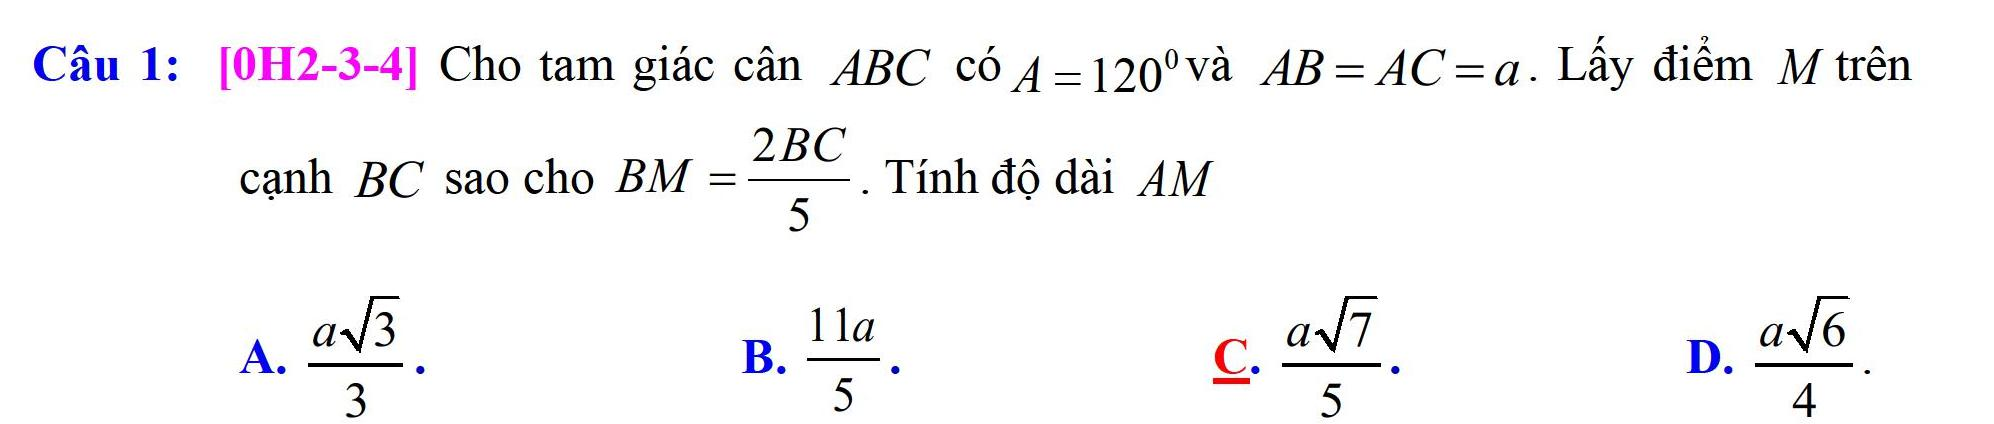

-- Number of words: 134


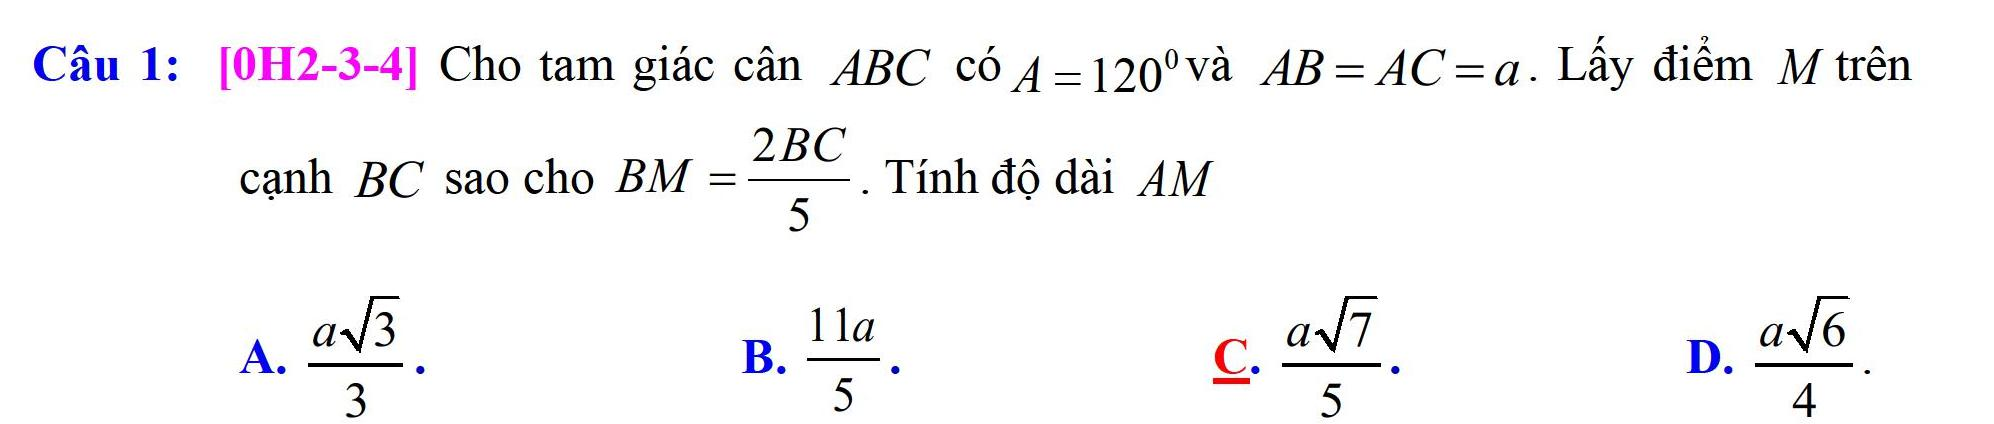

************
PAIRS: 15 - Cosine score: 1.0000000000000002
-- Number of words: 40


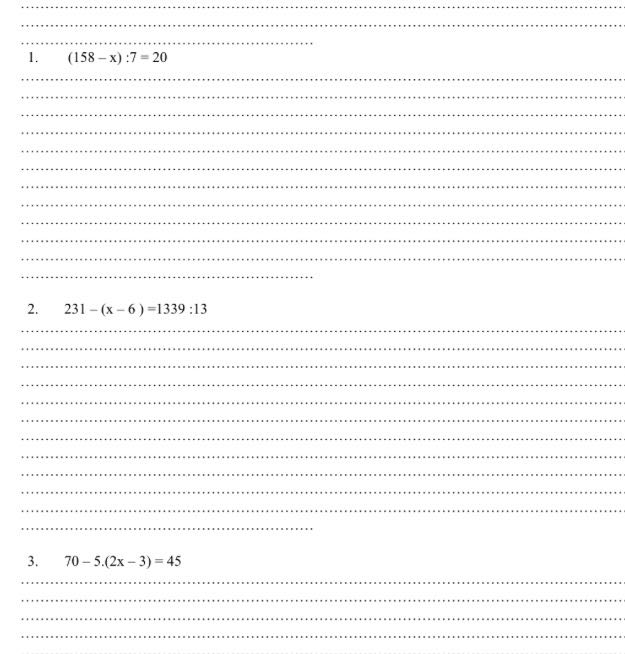

-- Number of words: 40


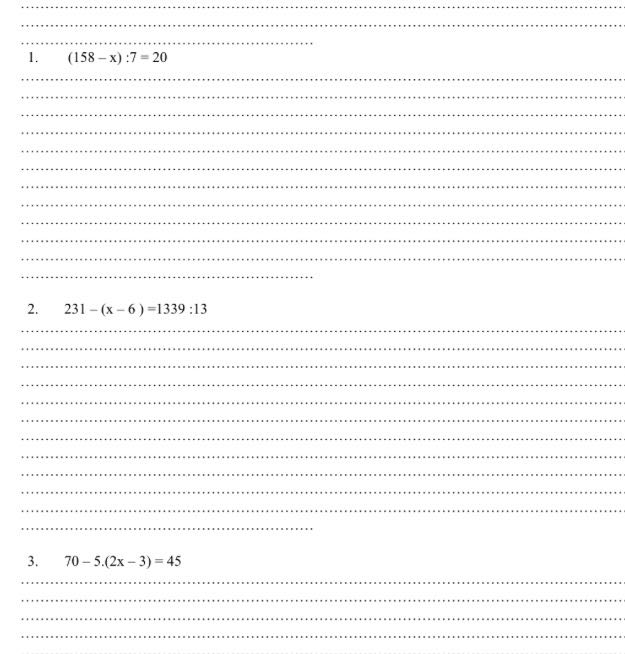

-- Number of words: 40


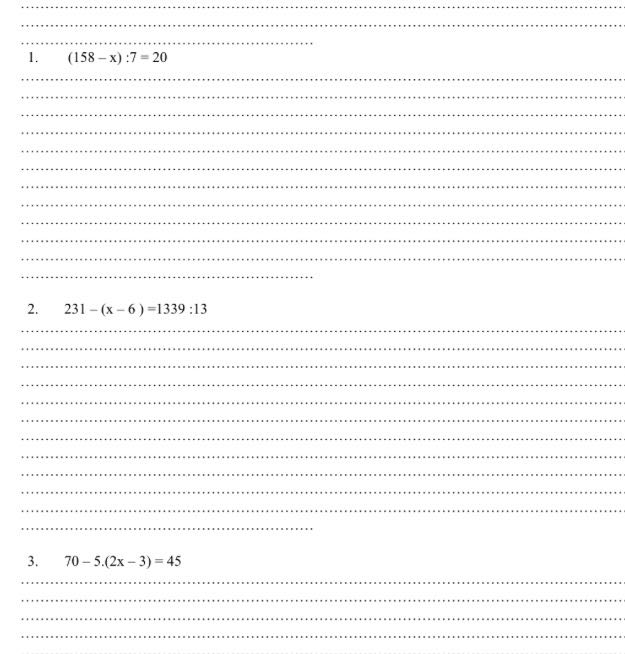

************
PAIRS: 16 - Cosine score: 1.0
-- Number of words: 103


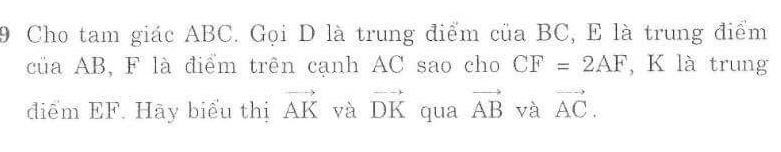

-- Number of words: 103


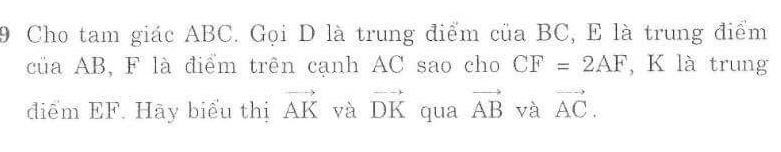

-- Number of words: 103


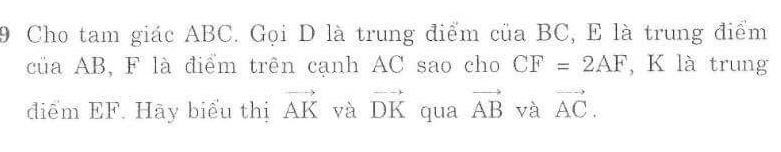

************
PAIRS: 17 - Cosine score: 1.0
-- Number of words: 74


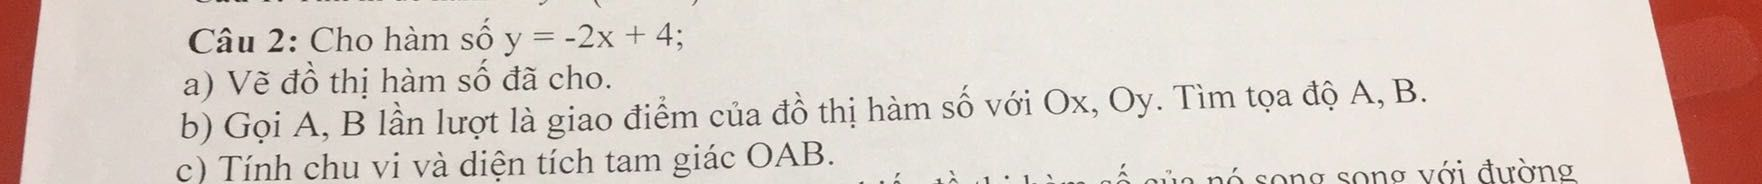

-- Number of words: 74


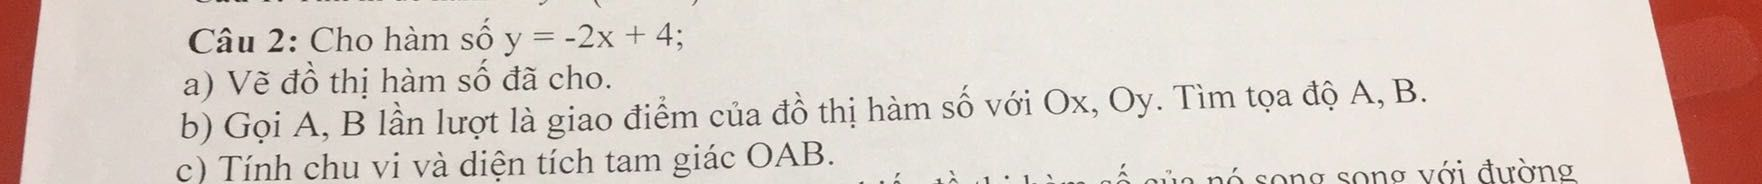

-- Number of words: 74


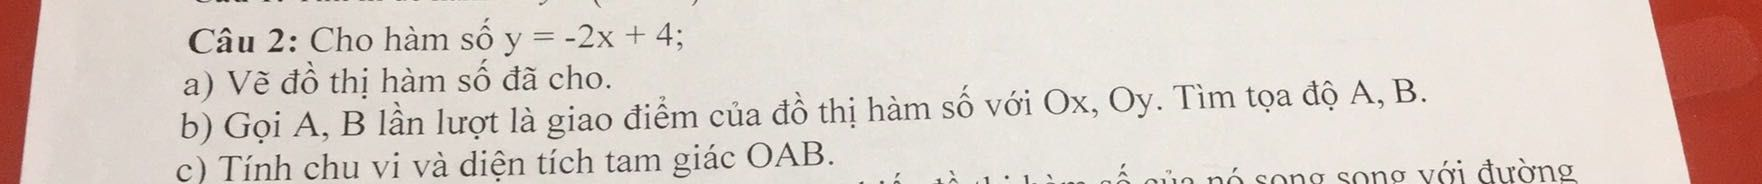

************
PAIRS: 18 - Cosine score: 0.9972396522105682
-- Number of words: 155


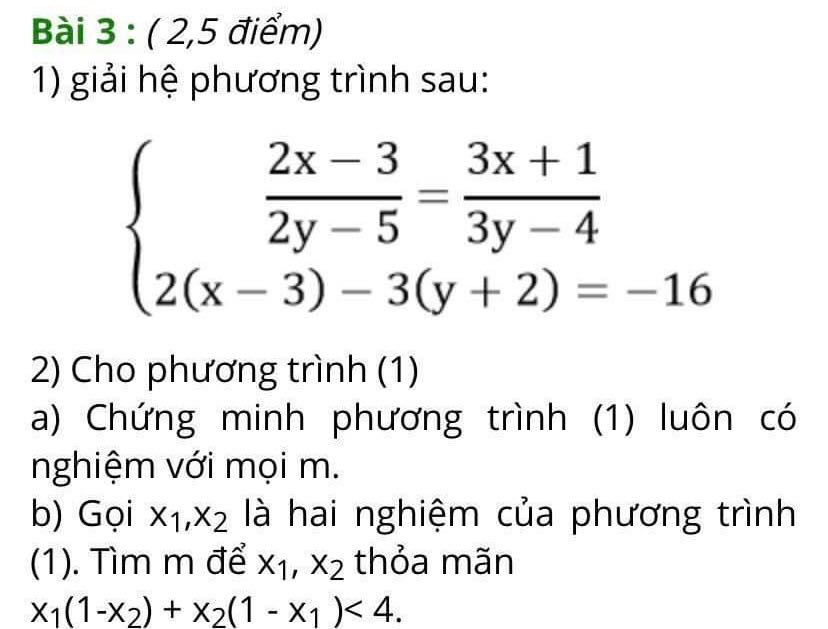

-- Number of words: 161


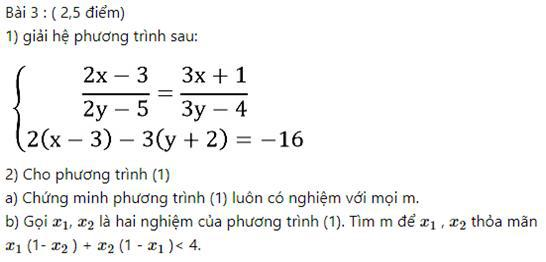

-- Number of words: 161


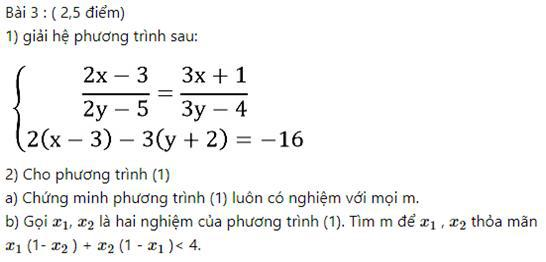

************
PAIRS: 19 - Cosine score: 0.9999999999999999
-- Number of words: 60


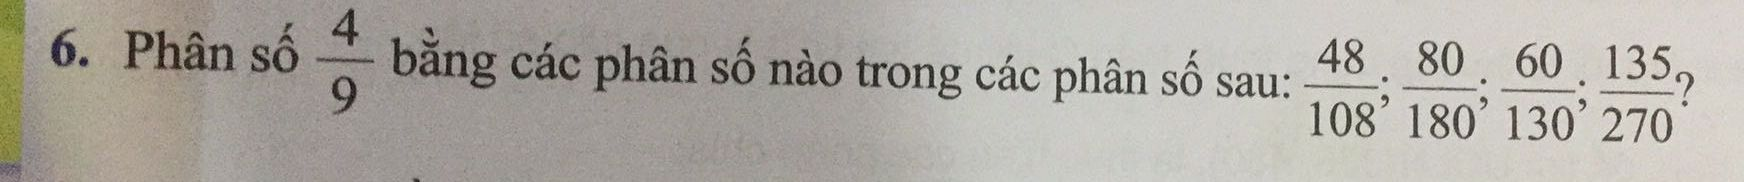

-- Number of words: 60


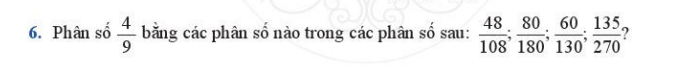

-- Number of words: 60


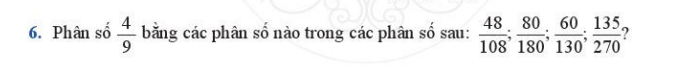

************
PAIRS: 20 - Cosine score: 0.5955571089299284
-- Number of words: 61


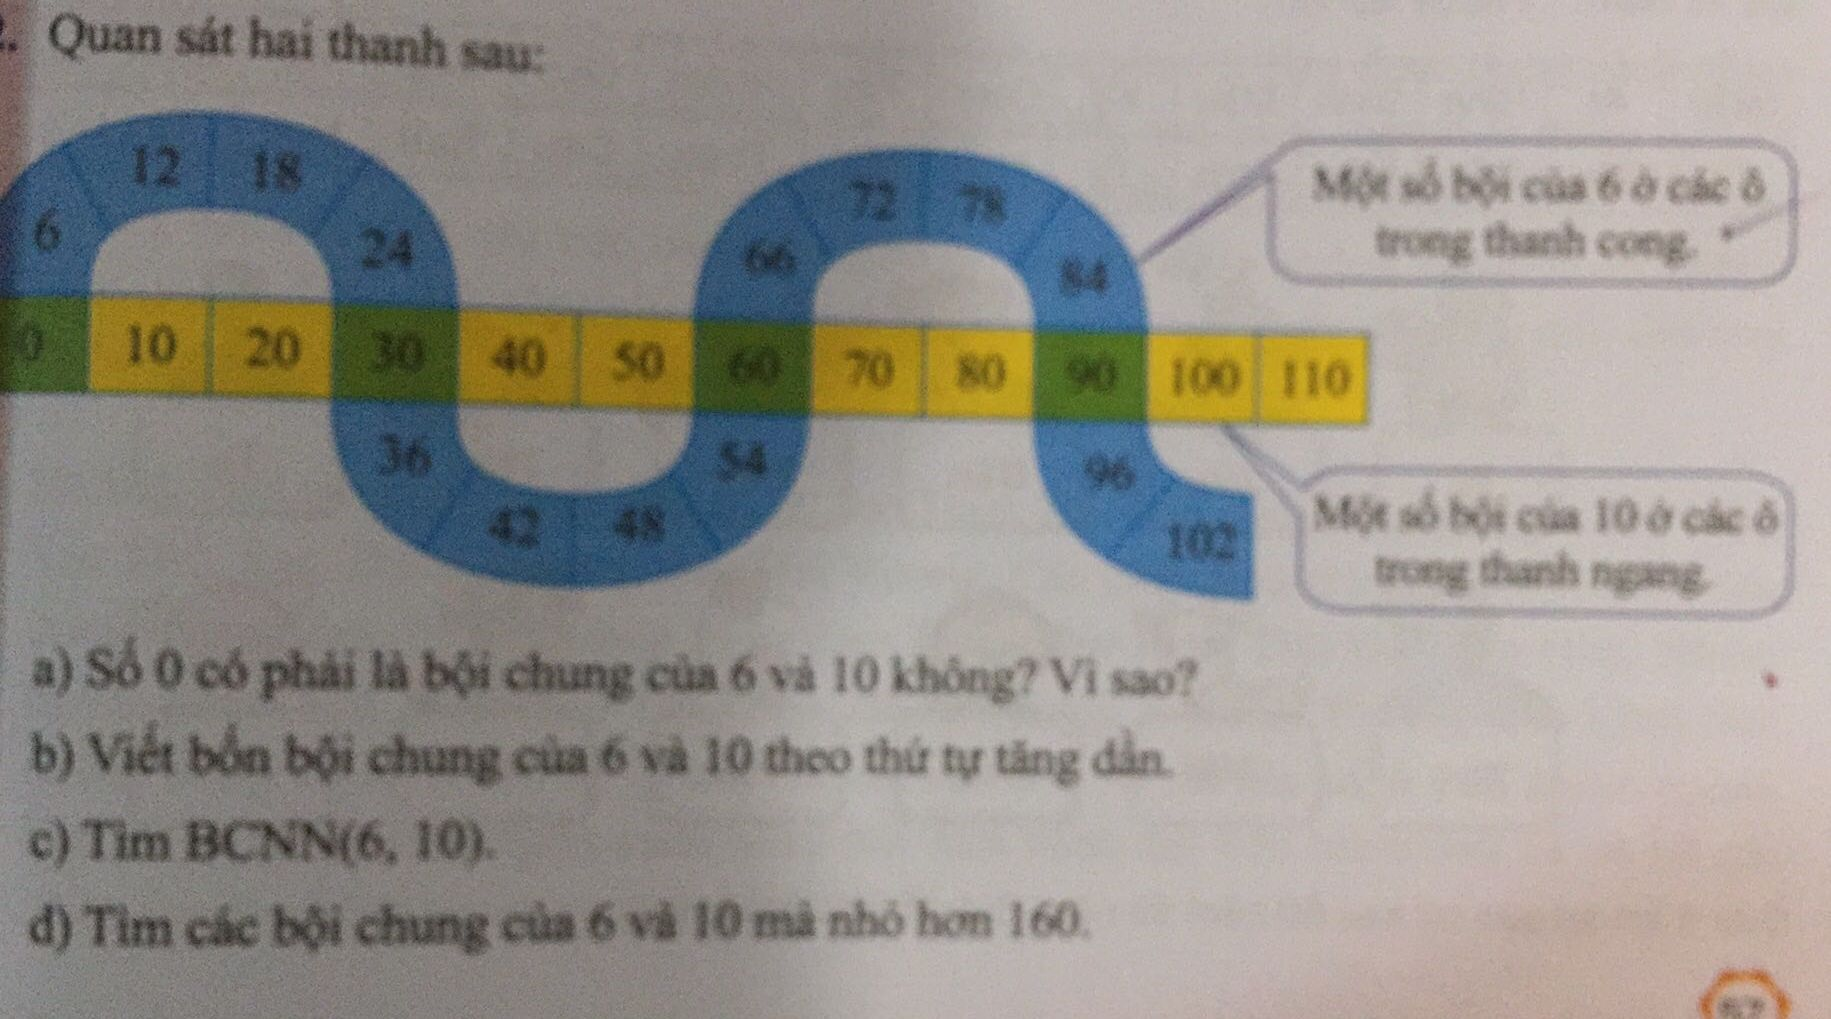

-- Number of words: 111


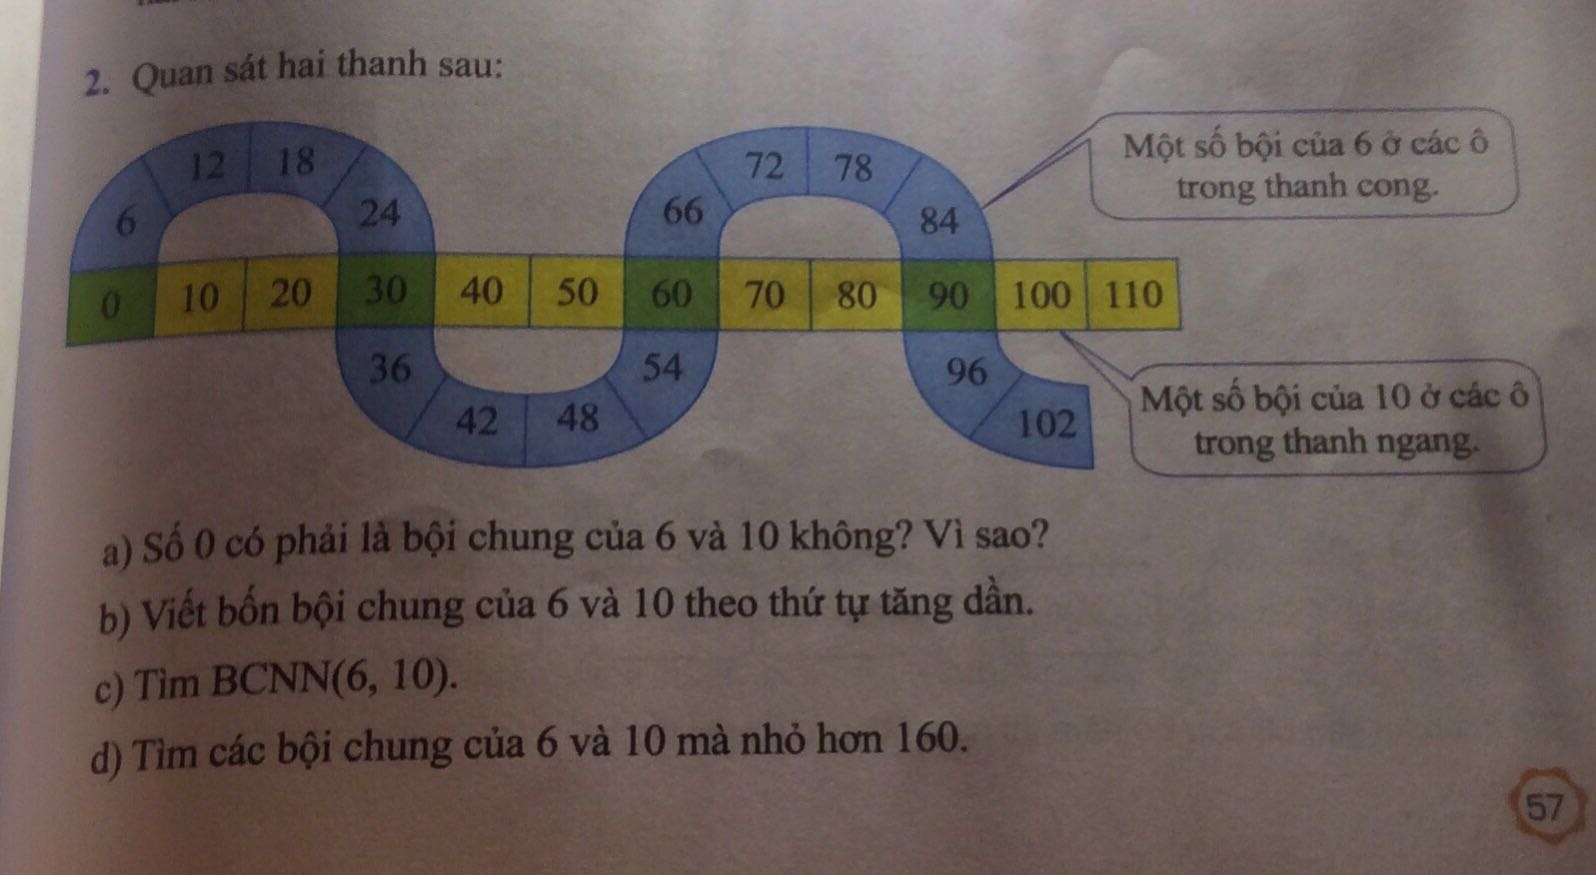

-- Number of words: 111


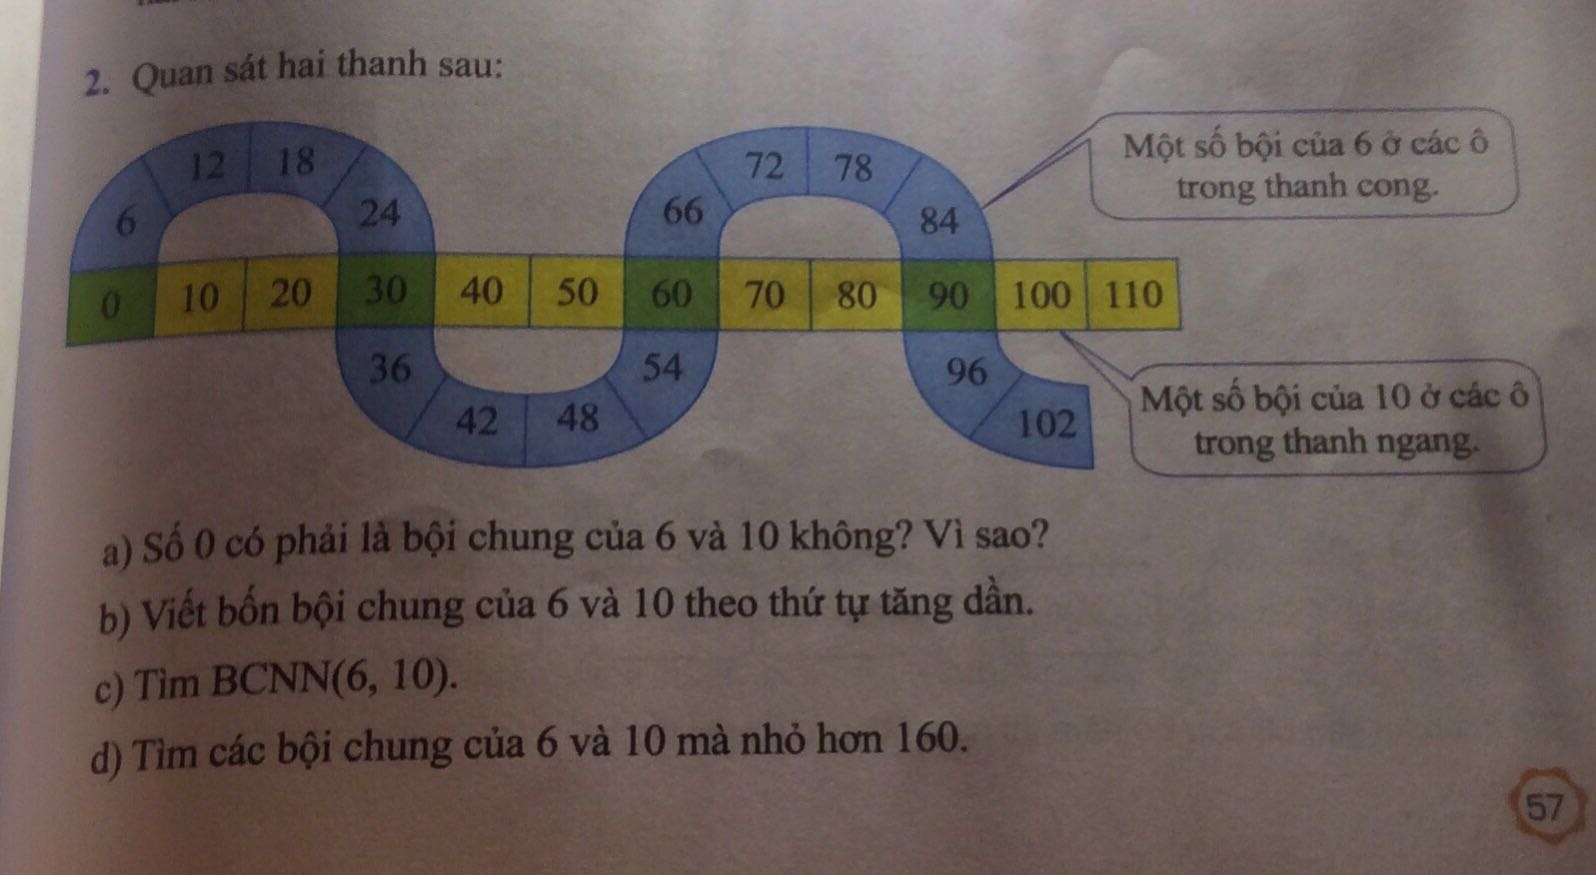

************
PAIRS: 21 - Cosine score: 0.994829680331069
-- Number of words: 191


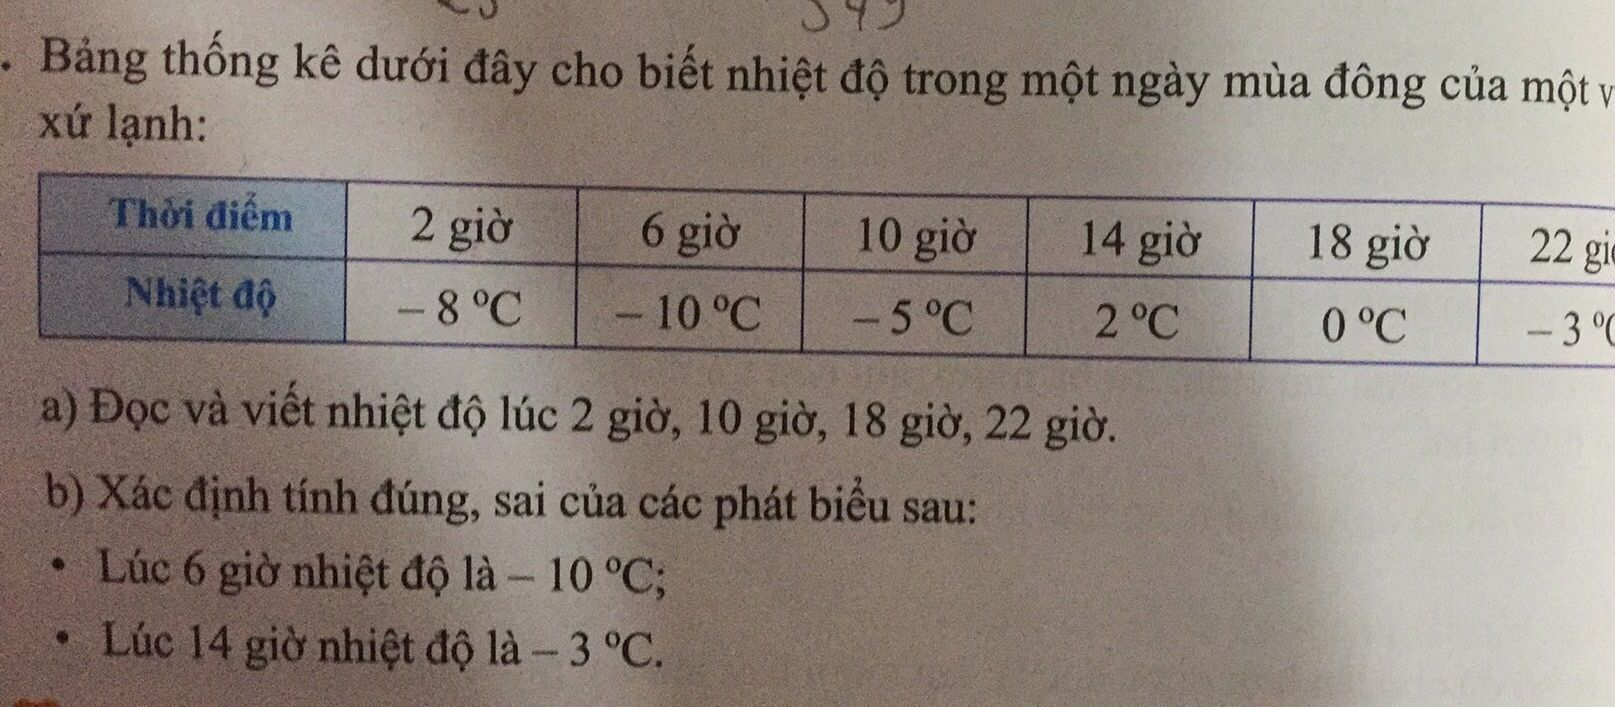

-- Number of words: 197


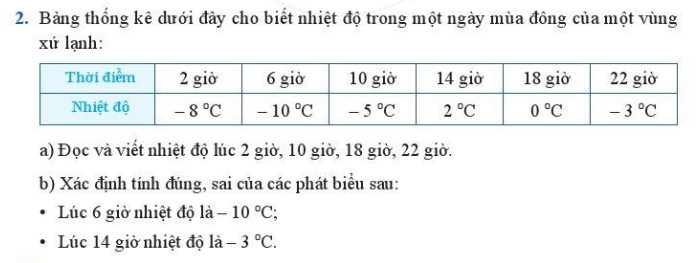

-- Number of words: 197


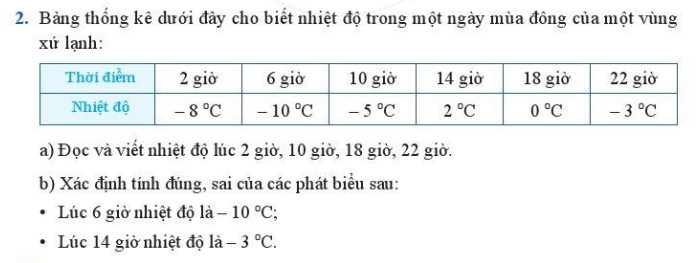

************


In [57]:
idx = 0
end = 20
for url1, url2 in zip(df_match_pos['Question Image'].values, df_match_pos['cosine_image'].values):
    print('PAIRS: {} - Cosine score: {}'.format(idx + 1, df_match_pos['score'].values[idx]))
    print('-- Number of words:', df_match_pos['word_count_lookup'].values[idx])
    img0 = Disp.Image(requests.get(df_match_pos['Lookup Image'].values[idx]).content)
    display(img0)
    print('-- Number of words:', df_match_pos['word_count_question'].values[idx])
    img1 = Disp.Image(requests.get(url1).content)
    display(img1)
    print('-- Number of words:', df_match_pos['cosine_word_count_question'].values[idx])
    img2 = Disp.Image(requests.get(url2).content)
    display(img2)
    print('************')
    idx += 1
    if idx > 20:
        break

In [58]:
# N=5
# menMeans = (20,35,30,35,27)
# womenMeans = (25,32,34,20,25)

# ind = np.arange(N)
# width =0.5

# p1 = plt.bar(ind,menMeans, width,label='Men')
# p2 = plt.bar(ind,womenMeans, width,bottom=menMeans,label='Women')



# plt.ylabel('Scores')
# plt.title('Scores by group and gender')
# plt.xticks(ind,('G1','G2','G3','G4','G5'))
# plt.yticks(np.arange(0,81,10))
# plt.legend()
# plt.figure(figsize=(10, 6))
# plt.show()

# import pandas
# import matplotlib.pylab as plt
# import seaborn as sns
# plt.rcParams["figure.figsize"] = [7.00, 3.50]
# plt.rcParams["figure.autolayout"] = True
# df = pandas.DataFrame(dict(
#    number=[2, 5, 1, 6, 3],
#    count=[56, 21, 34, 36, 12],
#    select=[29, 13, 17, 21, 8]
# ))
# bar_plot1 = sns.barplot(x='number', y='count', data=df, label="count", color="red")
# bar_plot2 = sns.barplot(x='number', y='select', data=df, label="select", color="green")
# plt.legend(ncol=2, loc="upper right", frameon=True)
# plt.show()